# Predicting customer churn for SyriaTel

#### Project description: **SyriaTel Customer Churn**

Build a classifier to predict whether a customer will ("soon") stop doing business with SyriaTel, a telecommunications company. This is a binary classification problem. Most naturally, your audience here would be the telecom business itself, interested in reducing how much money is lost because of customers who don't stick around very long. The question you can ask is: are there any predictable patterns here?

#### A predictive finding might include:

How well your model is able to predict the target
What features are most important to your model
A predictive recommendation might include:

The contexts/situations where the predictions made by your model would and would not be useful for your stakeholder and business problem
Suggestions for how the business might modify certain input variables to achieve certain target results

#### Iterative Approach to Modeling
You should demonstrate an iterative approach to modeling. This means that you must build multiple models. Begin with a basic model, evaluate it, and then provide justification for and proceed to a new model. After you finish refining your models, you should provide 1-3 paragraphs in the notebook discussing your final model.

With the additional techniques you have learned in Phase 3, be sure to explore:

Model features and preprocessing approaches
Different kinds of models (logistic regression, decision trees, etc.)
Different model hyperparameters
At minimum you must build two models:

A simple, interpretable baseline model (logistic regression or single decision tree)
A version of the simple model with tuned hyperparameters

#### Classification Metrics
You must choose appropriate classification metrics and use them to evaluate your models. Choosing the right classification metrics is a key data science skill, and should be informed by data exploration and the business problem itself. You must then use this metric to evaluate your model performance using both training and testing data.

**Potential Business Questions:**

* What were the factors influencing customer churn?
* What is the best model for predicting customer churn?
* How can the insights from feature importance help improve customer churn?
* Which services have the highest impact on customer churn?
* What services do customers with longer tenure have?
* What types of customers buy into long term contracts?
* What percentage of customers leave after one month/6 months/1 year
* Which state has the highest churn rate?

Plan:
* identify the key features that determine if a customer is likely to churn
* determine the most suitable model to predict Customer Churn 
* create customer retention strategy to reduce churn

### Data understanding

In [4070]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

from scipy.stats import chi2_contingency

In [3818]:
df = pd.read_csv('churn_data.csv')
df.head(5)

state  account length  area code phone number international plan  \
0    KS             128        415     382-4657                 no   
1    OH             107        415     371-7191                 no   
2    NJ             137        415     358-1921                 no   
3    OH              84        408     375-9999                yes   
4    OK              75        415     330-6626                yes   

  voice mail plan  number vmail messages  total day minutes  total day calls  \
0             yes                     25              265.1              110   
1             yes                     26              161.6              123   
2              no                      0              243.4              114   
3              no                      0              299.4               71   
4              no                      0              166.7              113   

   total day charge  ...  total eve calls  total eve charge  \
0             45.07  ...               99             16.78   
1             27.47  ...              103             16.62   
2             41.38  ...              110             10.30   
3             50.90  ...               88              5.26   
4             28.34  ...              122             12.61   

   total night minutes  total night calls  total night charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   total intl minutes  total intl calls  total intl charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   customer service calls  churn  
0                       1  False  
1                       1  False  
2                       0  False  
3                       2  False  
4                       3  False  

[5 rows x 21 columns]

In [3819]:
# Making copy to help with EDA at end of notebook
df_copy = df

In [3820]:
df.shape

(3333, 21)

In [3821]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [3822]:
df.describe()

account length    area code  number vmail messages  total day minutes  \
count     3333.000000  3333.000000            3333.000000        3333.000000   
mean       101.064806   437.182418               8.099010         179.775098   
std         39.822106    42.371290              13.688365          54.467389   
min          1.000000   408.000000               0.000000           0.000000   
25%         74.000000   408.000000               0.000000         143.700000   
50%        101.000000   415.000000               0.000000         179.400000   
75%        127.000000   510.000000              20.000000         216.400000   
max        243.000000   510.000000              51.000000         350.800000   

       total day calls  total day charge  total eve minutes  total eve calls  \
count      3333.000000       3333.000000        3333.000000      3333.000000   
mean        100.435644         30.562307         200.980348       100.114311   
std          20.069084          9.259435          50.713844        19.922625   
min           0.000000          0.000000           0.000000         0.000000   
25%          87.000000         24.430000         166.600000        87.000000   
50%         101.000000         30.500000         201.400000       100.000000   
75%         114.000000         36.790000         235.300000       114.000000   
max         165.000000         59.640000         363.700000       170.000000   

       total eve charge  total night minutes  total night calls  \
count       3333.000000          3333.000000        3333.000000   
mean          17.083540           200.872037         100.107711   
std            4.310668            50.573847          19.568609   
min            0.000000            23.200000          33.000000   
25%           14.160000           167.000000          87.000000   
50%           17.120000           201.200000         100.000000   
75%           20.000000           235.300000         113.000000   
max           30.910000           395.000000         175.000000   

       total night charge  total intl minutes  total intl calls  \
count         3333.000000         3333.000000       3333.000000   
mean             9.039325           10.237294          4.479448   
std              2.275873            2.791840          2.461214   
min              1.040000            0.000000          0.000000   
25%              7.520000            8.500000          3.000000   
50%              9.050000           10.300000          4.000000   
75%             10.590000           12.100000          6.000000   
max             17.770000           20.000000         20.000000   

       total intl charge  customer service calls  
count        3333.000000             3333.000000  
mean            2.764581                1.562856  
std             0.753773                1.315491  
min             0.000000                0.000000  
25%             2.300000                1.000000  
50%             2.780000                1.000000  
75%             3.270000                2.000000  
max             5.400000                9.000000

In [3823]:
df.duplicated().sum()

np.int64(0)

In [3824]:
df['phone number'].duplicated().value_counts()

phone number
False    3333
Name: count, dtype: int64

In [3825]:
df.isnull().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

### Data dictionary 

* state: State where the customer resides
* account length: Duration (in days) the account has been active
* area code: Customer's area code
* phone number: Customer's phone number
* international plan: Indicates if the customer subscribes to the international plan
* voice mail plan: Indicates if the customer subscribes to the voice mail plan
* number vmail messages: Number of voicemails sent by the customer
* total day minutes: Total minutes of calls made during the day
* total day calls: Total number of daytime calls made
* total day charge: Charges for daytime calls
* total eve minutes: Total minutes of calls made during the evening
* total eve calls: Total number of evening calls made
* total eve charge: Charges for evening calls
* total night minutes: Total minutes of calls made at night
* total night calls: Total number of nighttime calls made
* total night charge: Charges for nighttime calls
* total intl minutes: Total minutes of international calls made
* total intl calls: Total number of international calls made
* total intl charge: Charges for international calls
* customer service calls: Number of customer service calls made
* churn: Indicates if the customer has terminated their contract

We have a datagrame with 3333 rows, 21 columns, with no missing values and no dupilcates.

### Data cleaning

The data set is originally very clean, we just need to make a couple if adjustments:  
* We replace spaces with a underline in the column name for a convinient format and to avoid mistakes.  
* We drop phone number column, as it doesn't bring any value for future analysis, it's a unique value for each row and we already used it to check for duplicates.  
* We replace values in three columns to 1s and 0s for further steps.

In [3826]:
#renaming columns
df.columns = df.columns.str.replace(' ', '_')

In [3827]:
#replacing objects and bool to numbers

df['international_plan'] = df['international_plan'].map({'yes': 1, 'no': 0}).astype(int)

df['voice_mail_plan'] = df['voice_mail_plan'].map({'yes': 1, 'no': 0}).astype(int)

df['churn'] = df['churn'].astype(int)

### Identify Relevant Columns

Let's examine our columns a little further, to determine which ones contain relevant information to our dataset.

In [3828]:
df.keys()

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn'],
      dtype='object')

### State

In [3829]:
df['state'].value_counts(normalize=True, ascending=False)

state
WV    0.031803
MN    0.025203
NY    0.024902
AL    0.024002
WI    0.023402
OH    0.023402
OR    0.023402
WY    0.023102
VA    0.023102
CT    0.022202
MI    0.021902
ID    0.021902
VT    0.021902
TX    0.021602
UT    0.021602
IN    0.021302
MD    0.021002
KS    0.021002
NC    0.020402
NJ    0.020402
MT    0.020402
CO    0.019802
NV    0.019802
WA    0.019802
RI    0.019502
MA    0.019502
MS    0.019502
AZ    0.019202
FL    0.018902
MO    0.018902
NM    0.018602
ME    0.018602
ND    0.018602
NE    0.018302
OK    0.018302
DE    0.018302
SC    0.018002
SD    0.018002
KY    0.017702
IL    0.017402
NH    0.016802
AR    0.016502
GA    0.016202
DC    0.016202
HI    0.015902
TN    0.015902
AK    0.015602
LA    0.015302
PA    0.013501
IA    0.013201
CA    0.010201
Name: proportion, dtype: float64

Looks like our data is pretty evenly distributed across the states...the value_counts range betwen 1-3%, which is a slight difference, but probably not a great enough discrepancy to draw great conclusions. 

### Account Length

In [3830]:
df['account_length'].value_counts(normalize=True, ascending=False)

account_length
105    0.012901
87     0.012601
101    0.012001
93     0.012001
90     0.011701
         ...   
243    0.000300
200    0.000300
232    0.000300
5      0.000300
221    0.000300
Name: proportion, Length: 212, dtype: float64

### Area Code

In [3831]:
df['area_code'].value_counts(normalize=True, ascending=False)

area_code
415    0.496550
510    0.252025
408    0.251425
Name: proportion, dtype: float64

In [3832]:
df['state'].nunique()

51

This is very odd. Why is there information from only three area codes? Especially given that we have calls from customers across all 50 states? 

Let's look at what geographic locations correspond to these three area-codes.

**415**: San Francisco, CA

**510**: East Bay cities in Northern California

**408**: San Jose, CA

### California Customers

All of the customers in our dataset have **California area codes**. Why is this?

It will probably be more helpful (if at all) to determine *from where the customer is calling*, rather than the area-code in which they originally purchased their cell-phone plan.

Let's create a key with this information, in case we need to easily and quickly refer to it later on. 

In [3833]:
area_codes = {
    415: 'San Francisco, CA',
    510: 'East Bay cities, Northern CA',
    408: 'San Jose, CA'
}

In [3834]:
keys = {
    'area_codes' : area_codes
}

#### Extracting prefix codes from phone_number

We can extract the 'prefix' from each phone_number, which gives us information about a smaller region within a given area code. This might be helpful later on.

In [3835]:
# Extract area code function
def extract_prefix(phone_number):
    prefix = phone_number[:3]  # Extracts first three characters
    return prefix

# Apply function to create new column
df['prefix'] = df['phone_number'].apply(extract_prefix)

df.head()

state  account_length  area_code phone_number  international_plan  \
0    KS             128        415     382-4657                   0   
1    OH             107        415     371-7191                   0   
2    NJ             137        415     358-1921                   0   
3    OH              84        408     375-9999                   1   
4    OK              75        415     330-6626                   1   

   voice_mail_plan  number_vmail_messages  total_day_minutes  total_day_calls  \
0                1                     25              265.1              110   
1                1                     26              161.6              123   
2                0                      0              243.4              114   
3                0                      0              299.4               71   
4                0                      0              166.7              113   

   total_day_charge  ...  total_eve_charge  total_night_minutes  \
0             45.07  ...             16.78                244.7   
1             27.47  ...             16.62                254.4   
2             41.38  ...             10.30                162.6   
3             50.90  ...              5.26                196.9   
4             28.34  ...             12.61                186.9   

   total_night_calls  total_night_charge  total_intl_minutes  \
0                 91               11.01                10.0   
1                103               11.45                13.7   
2                104                7.32                12.2   
3                 89                8.86                 6.6   
4                121                8.41                10.1   

   total_intl_calls  total_intl_charge  customer_service_calls  churn  prefix  
0                 3               2.70                       1      0     382  
1                 3               3.70                       1      0     371  
2                 5               3.29                       0      0     358  
3                 7               1.78                       2      0     375  
4                 3               2.73                       3      0     330  

[5 rows x 22 columns]

In [3836]:
df['prefix'].value_counts()

prefix
405    53
408    48
352    47
406    47
417    46
       ..
342    24
421    24
412    23
422    19
327    19
Name: count, Length: 96, dtype: int64

In [3837]:
df['prefix'].nunique()

96

### Customer Service

In [3838]:
df['customer_service_calls'].value_counts(normalize=True, ascending=False)

customer_service_calls
1    0.354335
2    0.227723
0    0.209121
3    0.128713
4    0.049805
5    0.019802
6    0.006601
7    0.002700
9    0.000600
8    0.000600
Name: proportion, dtype: float64

Interesting!! Out of all the data in our dataset, only 21% of customers did **not** call customer service at least once.

We should examine how many of these are related to churn in our EDA.

### Total Call-Time, and Call-Charge.

It would be great if we could make a new column, documenting the total number of minutes spent calling and/or the total charges made to a particular phone number. However, there seems to be an overlap between the *international* data, and the data based on *time of day*. (AKA, we can assume that "total_day_calls" includes the international calls made during the day, which are also documented in "total_intl_calls").

Time of day probably doesn't matter as much as location with regards to quality of telecommunications. We can feel good about focusing on the total number of minutes called & charged, regardless of time of day.

In [3839]:
# Creating new columns total_minutes and total_charge
df['total_minutes'] = df['total_day_minutes'] + df['total_eve_minutes'] + df['total_night_minutes'] 
df['total_charge'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge']

### International Calls

At first glance, it might not seem necessary to have both 'international_plan' as well as 'total_intl_minutes'. We can assume someone has an international_plan, if they're logging a lot of minutes in international calls...why would we need to know both?

However, there might be instances in which people purchase an international_plan, then have technical difficulties preventing them from spending as many 'intl_minutes' on international calls as they'd like to...leading to churn. We'll keep these columns, and keep this in mind as we explore our data and run some tests.

### Dropping Columns

Let's drop our 'phone_number' column. We'll want to drop a bunch more, in order to hone in on feature selection. But we'll wait until we run some tests to check for multicollinearity.

In [3840]:
#drop unnecessary column
df = df.drop('phone_number', axis=1)

Let's take a look at a final clean columns -  3333 rows and 20 columns. Edited column names and replaces values in three columns

In [3841]:
df

state  account_length  area_code  international_plan  voice_mail_plan  \
0       KS             128        415                   0                1   
1       OH             107        415                   0                1   
2       NJ             137        415                   0                0   
3       OH              84        408                   1                0   
4       OK              75        415                   1                0   
...    ...             ...        ...                 ...              ...   
3328    AZ             192        415                   0                1   
3329    WV              68        415                   0                0   
3330    RI              28        510                   0                0   
3331    CT             184        510                   1                0   
3332    TN              74        415                   0                1   

      number_vmail_messages  total_day_minutes  total_day_calls  \
0                        25              265.1              110   
1                        26              161.6              123   
2                         0              243.4              114   
3                         0              299.4               71   
4                         0              166.7              113   
...                     ...                ...              ...   
3328                     36              156.2               77   
3329                      0              231.1               57   
3330                      0              180.8              109   
3331                      0              213.8              105   
3332                     25              234.4              113   

      total_day_charge  total_eve_minutes  ...  total_night_calls  \
0                45.07              197.4  ...                 91   
1                27.47              195.5  ...                103   
2                41.38              121.2  ...                104   
3                50.90               61.9  ...                 89   
4                28.34              148.3  ...                121   
...                ...                ...  ...                ...   
3328             26.55              215.5  ...                 83   
3329             39.29              153.4  ...                123   
3330             30.74              288.8  ...                 91   
3331             36.35              159.6  ...                137   
3332             39.85              265.9  ...                 77   

      total_night_charge  total_intl_minutes  total_intl_calls  \
0                  11.01                10.0                 3   
1                  11.45                13.7                 3   
2                   7.32                12.2                 5   
3                   8.86                 6.6                 7   
4                   8.41                10.1                 3   
...                  ...                 ...               ...   
3328               12.56                 9.9                 6   
3329                8.61                 9.6                 4   
3330                8.64                14.1                 6   
3331                6.26                 5.0                10   
3332               10.86                13.7                 4   

      total_intl_charge  customer_service_calls  churn  prefix  total_minutes  \
0                  2.70                       1      0     382          707.2   
1                  3.70                       1      0     371          611.5   
2                  3.29                       0      0     358          527.2   
3                  1.78                       2      0     375          558.2   
4                  2.73                       3      0     330          501.9   
...                 ...                     ...    ...     ...            ...   
3328               2.67                       2      0     414          65

### EDA

Let's plot and take a look at distribution of all numerical columns. 

In [3842]:
numeric = df.select_dtypes(include=['float64','int64'])

num_plots = len(numeric.columns)
num_plots

21

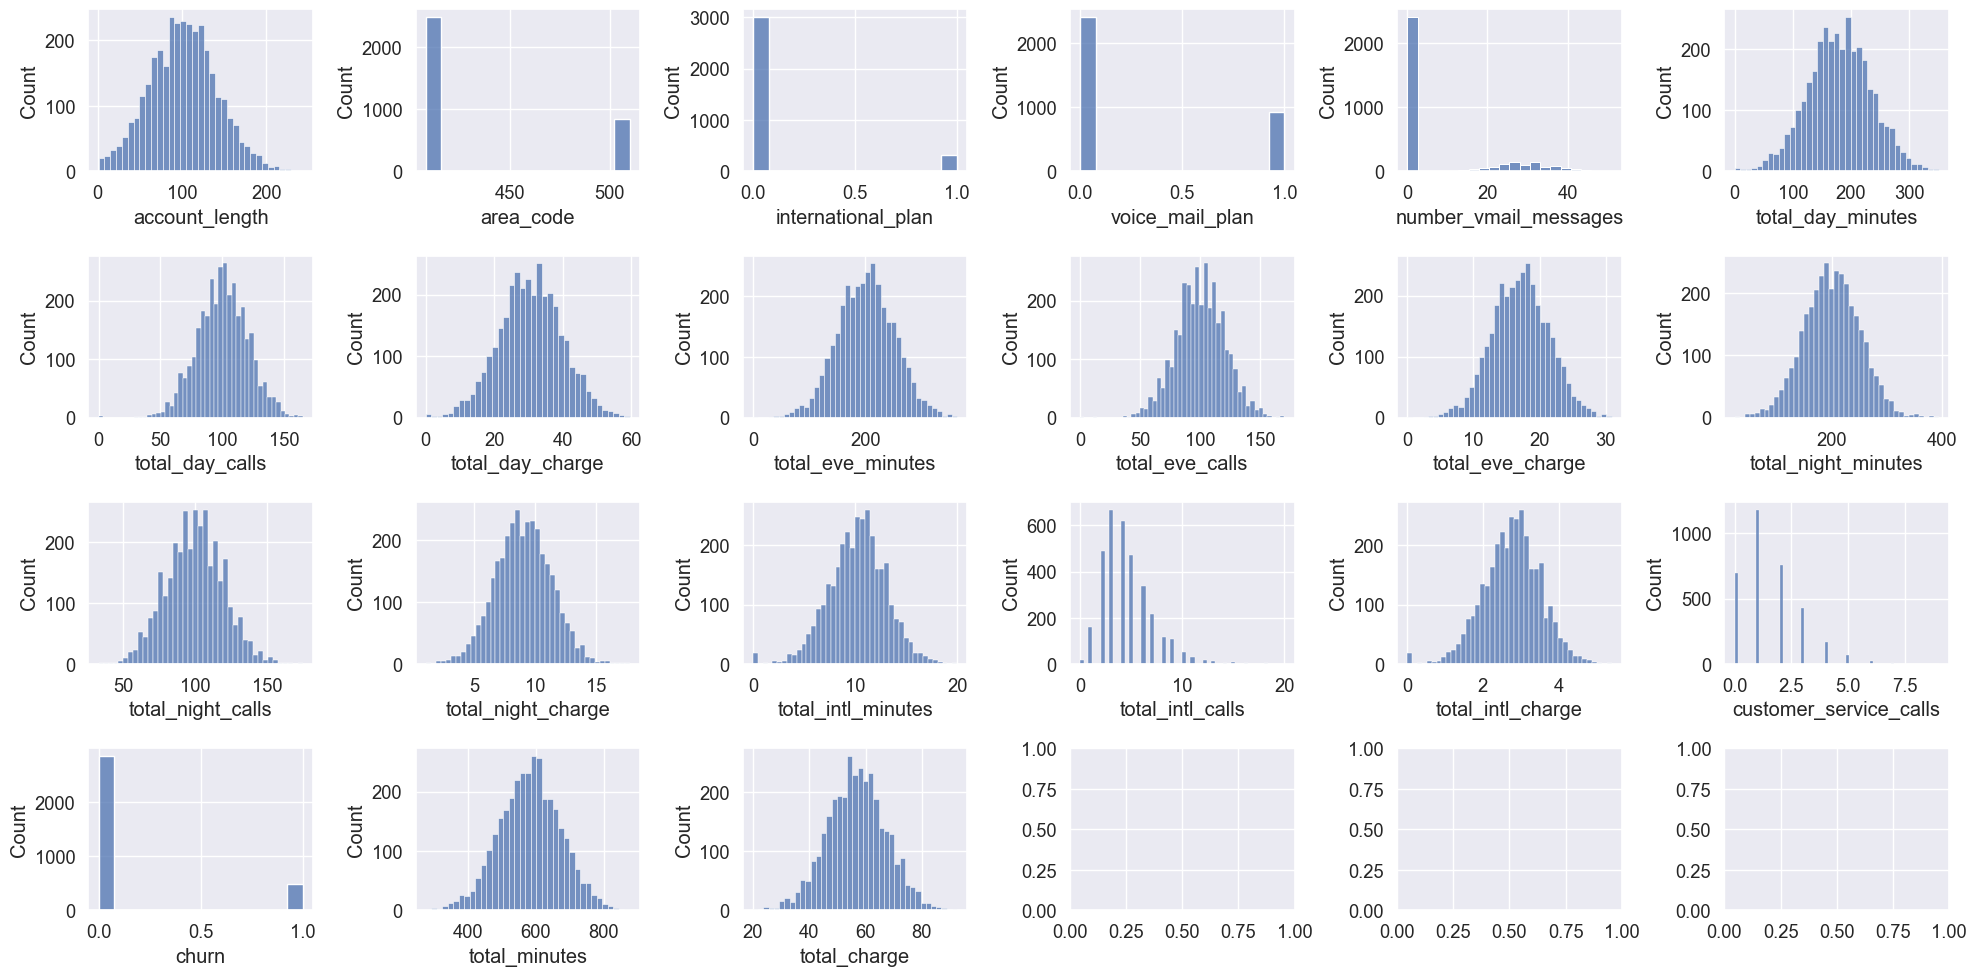

In [3843]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 10))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Iterate through numeric columns and plot histograms
for i, feature in enumerate(numeric):
    sns.histplot(df[feature], ax=axes[i])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Target variable

Target variable is churn. It is a binary variable.

The dataset is imbalanced. Around 85% of target variable has a value of 0, and around 15% value of 1.

A dataset is considered imbalanced for regression tasks when the distribution of the target variable is skewed or has outliers that can disproportionately influence the model's performance. It can make the model biased towards more frequent values.

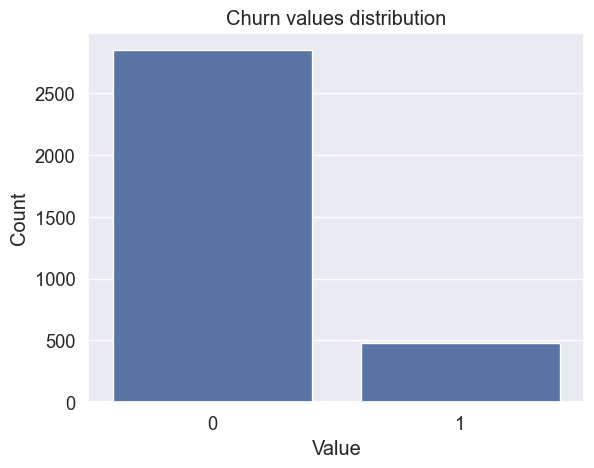

In [3844]:
sns.countplot(x='churn', data=df)
plt.title('Churn values distribution')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

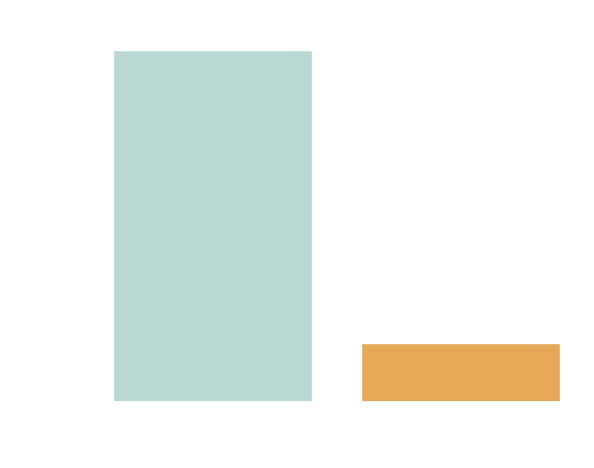

In [3845]:
# Custom colors
colors = ['#b4ddd6', '#ffab40']

# Create countplot with custom colors
sns.countplot(x='churn', data=df, hue='churn', palette=colors, order=df['churn'].value_counts().index, legend=False)

# Set custom xtick labels
plt.xticks([0, 1], ['No-Churn', 'Churn'])

# Set title and labels with white text color
plt.title('Churn values distribution', color='white')
plt.xlabel('Value', color='white')
plt.ylabel('Count', color='white')

# Set tick params for x and y axes to be white
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Set spines color to white
ax = plt.gca()
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Set background to be transparent
ax.set_facecolor('none')

# Save figure with transparent background
plt.savefig('countplot_custom.png', transparent=True, bbox_inches='tight')

# Show plot
plt.show()

In [3846]:
df['churn'].value_counts(normalize=True)

churn
0    0.855086
1    0.144914
Name: proportion, dtype: float64

### Feature analysis

In [3847]:
# Create numeric and categorical lists

categorical = ['state','area_code','international_plan','voice_mail_plan', 'phone_number']

numerical = ['account_length','number_vmail_messages','total_day_minutes','total_day_calls','total_day_charge',
                'total_eve_minutes','total_eve_calls','total_eve_charge','total_night_minutes','total_night_calls',
                'total_night_charge','total_intl_minutes','total_intl_calls','total_intl_charge','customer_service_calls']

We have three different area codes. 50% of clients are in area 415, 25% in area 510, 25% in area 408.

In [3848]:
df['area_code'].value_counts(normalize=True)

area_code
415    0.496550
510    0.252025
408    0.251425
Name: proportion, dtype: float64

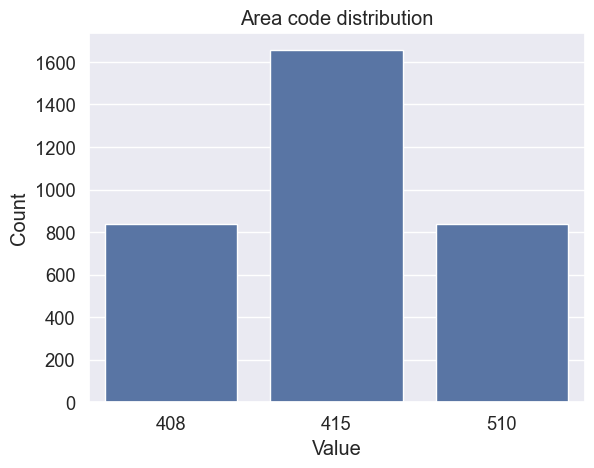

In [3849]:
sns.countplot(x='area_code', data=df)
plt.title('Area code distribution')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

90% of clients dont have an international plan

In [3850]:
df['international_plan'].value_counts(normalize=True)

international_plan
0    0.90309
1    0.09691
Name: proportion, dtype: float64

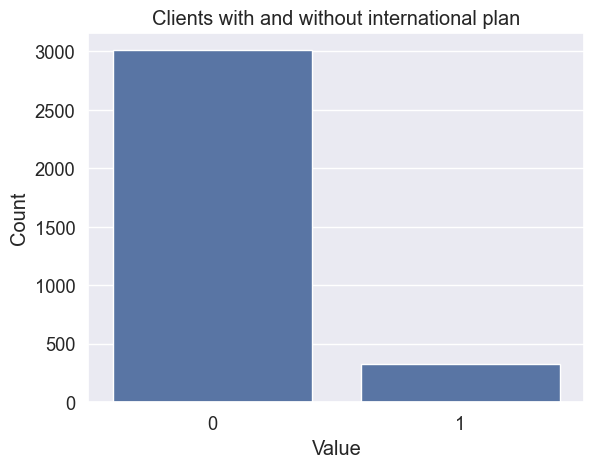

In [3851]:
sns.countplot(x='international_plan', data=df)
plt.title('Clients with and without international plan')
plt.xlabel('Value')
plt.ylabel('Count')

plt.show()

27% of clients have voice mail plan and 72% dont have a voice mail plan

In [3852]:
df['voice_mail_plan'].value_counts(normalize=True)

voice_mail_plan
0    0.723372
1    0.276628
Name: proportion, dtype: float64

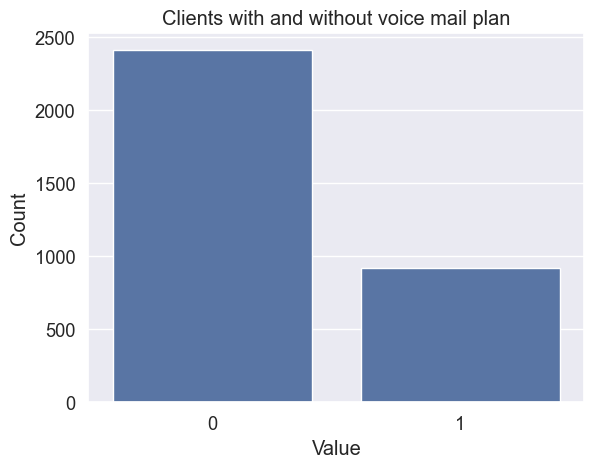

In [3853]:
sns.countplot(x='voice_mail_plan', data=df)
plt.title('Clients with and without voice mail plan')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

Let's take a look at how clients are dictributed geographically among states.
Least amount of clients are located in California, most amount of clients are in West Virginia.

In [3854]:
df['state'].value_counts(normalize=True)

state
WV    0.031803
MN    0.025203
NY    0.024902
AL    0.024002
WI    0.023402
OH    0.023402
OR    0.023402
WY    0.023102
VA    0.023102
CT    0.022202
MI    0.021902
ID    0.021902
VT    0.021902
TX    0.021602
UT    0.021602
IN    0.021302
MD    0.021002
KS    0.021002
NC    0.020402
NJ    0.020402
MT    0.020402
CO    0.019802
NV    0.019802
WA    0.019802
RI    0.019502
MA    0.019502
MS    0.019502
AZ    0.019202
FL    0.018902
MO    0.018902
NM    0.018602
ME    0.018602
ND    0.018602
NE    0.018302
OK    0.018302
DE    0.018302
SC    0.018002
SD    0.018002
KY    0.017702
IL    0.017402
NH    0.016802
AR    0.016502
GA    0.016202
DC    0.016202
HI    0.015902
TN    0.015902
AK    0.015602
LA    0.015302
PA    0.013501
IA    0.013201
CA    0.010201
Name: proportion, dtype: float64

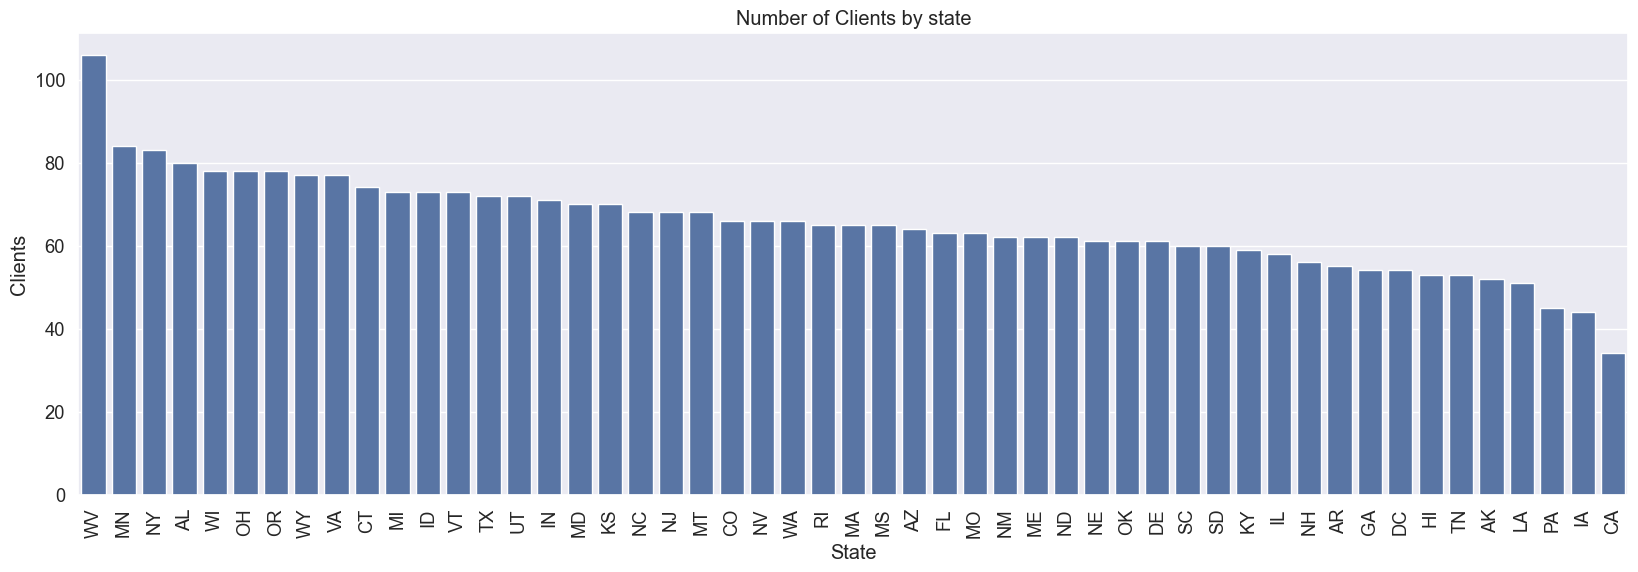

In [3855]:
plt.figure(figsize=(20, 6))
ax = sns.countplot(x='state', data=df, order=df['state'].value_counts().index)

plt.title('Number of Clients by state')
plt.xlabel('State')
plt.ylabel('Clients')

plt.xticks(rotation=90)
plt.show()

### Multicollinearity

In order to detect multicollinearity we make a matrix of Pearson correlation coefficients among the predictor variables. High correlation coefficients (e.g., above 0.75) suggest multicollinearity.

We need to avoid multicollinearity because it can lead to unreliable and unstable estimates of regression coefficients, making it difficult to determine the effect of each independent variable on the dependent variable. This can also result in inflated standard errors, leading to a higher chance of failing to identify significant variables.


In [3856]:
#
numeric.corr()

account_length  area_code  international_plan  \
account_length                1.000000  -0.012463            0.024735   
area_code                    -0.012463   1.000000            0.048551   
international_plan            0.024735   0.048551            1.000000   
voice_mail_plan               0.002918  -0.000747            0.006006   
number_vmail_messages        -0.004628  -0.001994            0.008745   
total_day_minutes             0.006216  -0.008264            0.049396   
total_day_calls               0.038470  -0.009646            0.003755   
total_day_charge              0.006214  -0.008264            0.049398   
total_eve_minutes            -0.006757   0.003580            0.019100   
total_eve_calls               0.019260  -0.011886            0.006114   
total_eve_charge             -0.006745   0.003607            0.019106   
total_night_minutes          -0.008955  -0.005825           -0.028905   
total_night_calls            -0.013176   0.016522            0.012451   
total_night_charge           -0.008960  -0.005845           -0.028913   
total_intl_minutes            0.009514  -0.018288            0.045871   
total_intl_calls              0.020661  -0.024179            0.017366   
total_intl_charge             0.009546  -0.018395            0.045780   
customer_service_calls       -0.003796   0.027572           -0.024522   
churn                         0.016541   0.006174            0.259852   
total_minutes                -0.005080  -0.006259            0.024422   
total_charge                  0.000770  -0.007083            0.045191   

                        voice_mail_plan  number_vmail_messages  \
account_length                 0.002918              -0.004628   
area_code                     -0.000747              -0.001994   
international_plan             0.006006               0.008745   
voice_mail_plan                1.000000               0.956927   
number_vmail_messages          0.956927               1.000000   
total_day_minutes             -0.001684               0.000778   
total_day_calls               -0.011086              -0.009548   
total_day_charge              -0.001686               0.000776   
total_eve_minutes              0.021545               0.017562   
total_eve_calls               -0.006444              -0.005864   
total_eve_charge               0.021559               0.017578   
total_night_minutes            0.006079               0.007681   
total_night_calls              0.015553               0.007123   
total_night_charge             0.006064               0.007663   
total_intl_minutes            -0.001318               0.002856   
total_intl_calls               0.007618               0.013957   
total_intl_charge             -0.001276               0.002884   
customer_service_calls        -0.017824              -0.013263   
churn                         -0.102148              -0.089728   
total_minutes                  0.014542               0.014688   
total_charge                   0.008689               0.009572   

                        total_day_minutes  total_day_calls  total_day_charge  \
account_length                   0.006216         0.038470          0.006214   
area_code                       -0.008264        -0.009646         -0.008264   
international_plan               0.049396         0.003755          0.049398   
voice_mail_plan                 -0.001684        -0.011086         -0.001686   
number_vmail_messages            0.000778        -0.009548          0.000776   
total_day_minutes                1.000000         0.006750          1.000000   
total_day_calls                  0.006750         1.000000          0.006753   
total_day_charge                 1.000000         0.006753          1.000000   
total_eve_minutes                0.007043        -0.021451          0.007050   
total_eve_calls                  0.015769         0.006462          0.015769   
total_eve_charge                 0.007029        -0.021449          0.007036   
tota

In [3857]:
abs(numeric.corr()) > 0.75

account_length  area_code  international_plan  \
account_length                    True      False               False   
area_code                        False       True               False   
international_plan               False      False                True   
voice_mail_plan                  False      False               False   
number_vmail_messages            False      False               False   
total_day_minutes                False      False               False   
total_day_calls                  False      False               False   
total_day_charge                 False      False               False   
total_eve_minutes                False      False               False   
total_eve_calls                  False      False               False   
total_eve_charge                 False      False               False   
total_night_minutes              False      False               False   
total_night_calls                False      False               False   
total_night_charge               False      False               False   
total_intl_minutes               False      False               False   
total_intl_calls                 False      False               False   
total_intl_charge                False      False               False   
customer_service_calls           False      False               False   
churn                            False      False               False   
total_minutes                    False      False               False   
total_charge                     False      False               False   

                        voice_mail_plan  number_vmail_messages  \
account_length                    False                  False   
area_code                         False                  False   
international_plan                False                  False   
voice_mail_plan                    True                   True   
number_vmail_messages              True                   True   
total_day_minutes                 False                  False   
total_day_calls                   False                  False   
total_day_charge                  False                  False   
total_eve_minutes                 False                  False   
total_eve_calls                   False                  False   
total_eve_charge                  False                  False   
total_night_minutes               False                  False   
total_night_calls                 False                  False   
total_night_charge                False                  False   
total_intl_minutes                False                  False   
total_intl_calls                  False                  False   
total_intl_charge                 False                  False   
customer_service_calls            False                  False   
churn                             False                  False   
total_minutes                     False                  False   
total_charge                      False                  False   

                        total_day_minutes  total_day_calls  total_day_charge  \
account_length                      False            False             False   
area_code                           False            False             False   
international_plan                  False            False             False   
voice_mail_plan                     False            False             False   
number_vmail_messages               False            False             False   
total_day_minutes                    True            False              True   
total_day_calls                     False             True             False   
total_day_charge                     True            False              True   
total_eve_minutes                   False            False             False   
total_eve_calls                     False            False             False   
total_eve_charge                    False            False             False   
tota

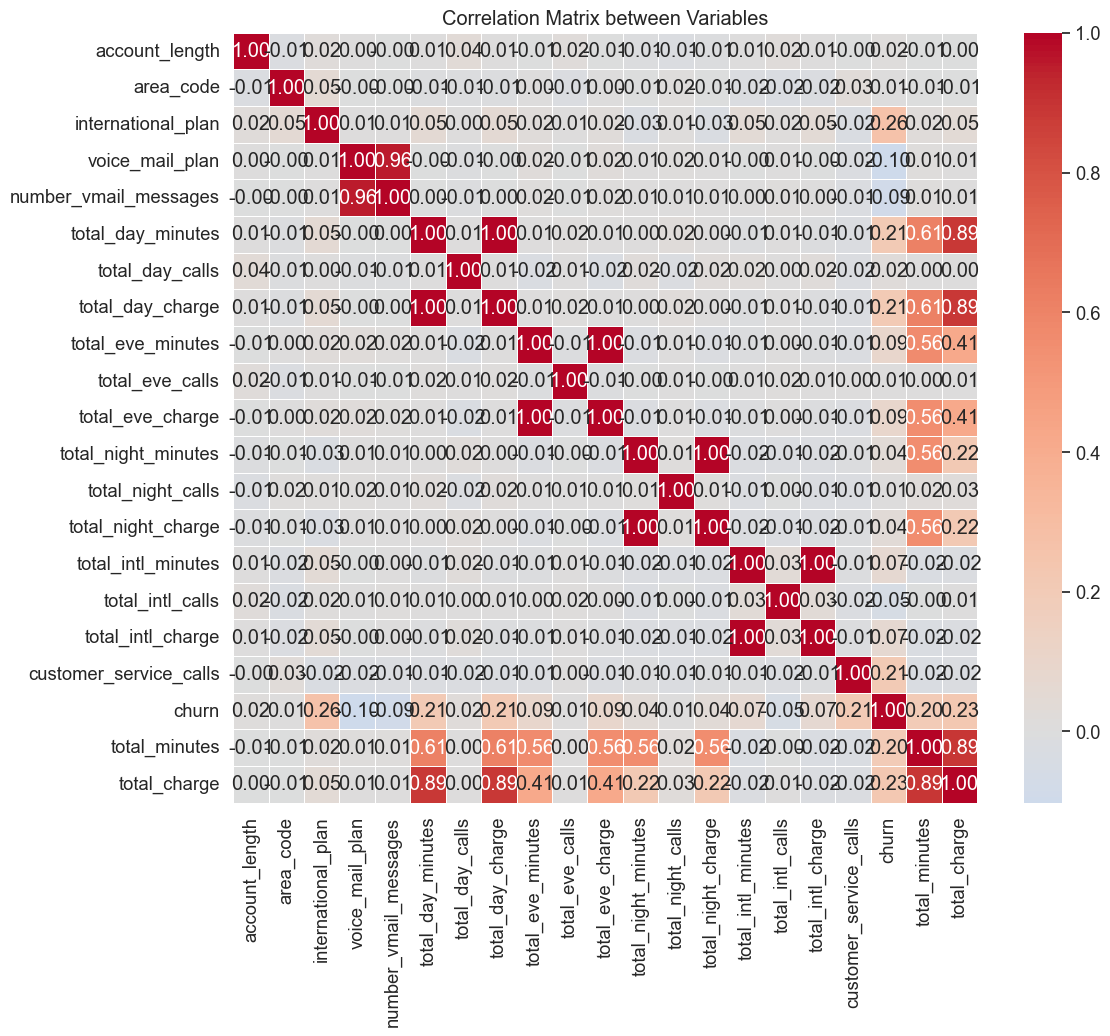

In [3858]:
# Calculate the correlation matrix
corr_matrix = numeric.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, center=0)
plt.title('Correlation Matrix between Variables')
plt.show();

### Dropping Columns/Feature Selection

This makes a lot of sense!! Of course we would see multicollinearity between features such as ''total_day_charge' and 'total_day_minutes'. They're basically telling us the same thing.

Let's drop columns we already deemed irrelevant, such as total_day_calls. They have a low correlation with our target variable, **churn**, which makes sense: the *number* of calls made doesn't matter so much as the *duration* and *charges* associated with each particular call. 

There was a *chance* these could have been helpful - what if someone has to make multiple calls, because the call keeps dropping due to techinical difficulties? However, due to the low correlations we can drop these columns. Then run the correlation matrix again.

In [3859]:
# Dropping from main and numeric dataframes
df.drop(columns=['total_day_calls', 'total_eve_calls', 'total_night_calls'], axis=1, inplace=True)

In [3860]:
numeric.drop(columns=['total_day_calls', 'total_eve_calls', 'total_night_calls'], axis=1, inplace=True)

## Price-per-Minute Rate

We can drop columns related to charges, keeping the columns logging the number of 'minutes' spent on a call yet retain the information from both columns, if we create a **conversion rate** by determining how much a call costs per minute.

Let's first do for day, eve, and night, to make sure there's consistency of charge-per-minute depending on time of day.

In [3861]:
# Calculating cost per minute by time of day
df['minute_cost_day'] = df['total_day_charge'] / df['total_day_minutes']
df['minute_cost_eve'] = df['total_eve_charge'] / df['total_eve_minutes']
df['minute_cost_night'] = df['total_night_charge'] / df['total_night_minutes']

In [3862]:
df['minute_cost_day'].describe()

count    3331.000000
mean        0.170003
std         0.000028
min         0.169231
25%         0.169989
50%         0.170004
75%         0.170017
max         0.170513
Name: minute_cost_day, dtype: float64

In [3863]:
df['minute_cost_eve'].describe()

count    3332.000000
mean        0.085001
std         0.000016
min         0.084936
25%         0.084988
50%         0.085000
75%         0.085013
max         0.085075
Name: minute_cost_eve, dtype: float64

In [3864]:
df['minute_cost_night'].describe()

count    3333.000000
mean        0.045000
std         0.000017
min         0.044828
25%         0.044988
50%         0.045000
75%         0.045013
max         0.045111
Name: minute_cost_night, dtype: float64

Fantastic!! All of our standard deviations are incredibly low, implying the data is tightly clustered around our means and very reliable.

We'll run this for international calls as well, then create a dictionary to use as a reference key, if we need to calculate the price of a phone call by the number of minutes it took.

In [3865]:
df['minute_cost_intl'] = df['total_intl_charge']  / df['total_intl_minutes']
df['minute_cost_intl'].describe()

count    3315.000000
mean        0.270057
std         0.000329
min         0.268182
25%         0.269811
50%         0.270000
75%         0.270297
max         0.272727
Name: minute_cost_intl, dtype: float64

#### Creating Price-Per-Minute key

Let's create a "key", **ppm**, that we can refer to whenever we need to remember how much a phone call costs per minute, depending on time of day and whether or not the call was international. We'll use the mean values from our calculations above, given that our 'min-to-max' ranges and standard deviations were *very* small. 

In [3866]:
# Creating dictionary with price-per-minute info
ppm = {
    'day_ppm': 0.17,
    'eve_ppm': 0.085,
    'night_ppm': 0.045,
    'intl_ppm': 0.27
}

In [3867]:
# Adding this to our main 'keys' dictionary
keys['ppm'] = ppm

In [3868]:
# Dropping columns from df
df.drop(columns=['minute_cost_day', 'minute_cost_eve', 'minute_cost_night', 'minute_cost_intl'], axis=1, inplace=True)

#### Takeaways

It looks like calls made during the day are by far more expensive than calls made during the evening, or night. International calls are also far more expensive, but that is expected.

### Dropping Columns

Now, we can drop the columns related to charges. 

In [3869]:
# Dropping from main dataframe
df.drop(columns=['total_day_charge', 'total_eve_charge', 'total_night_charge', 'total_intl_charge'], axis=1, inplace=True)

There's multicollinearity between 'total_minutes' and 'total_charge'. For this particular metric, let's drop 'total_minutes'. We can calculate that based on our minutes info for each time of day, and it might be helpful to determine which customers paid more or less over the total time of their phone plan.

In [3870]:
df.drop('total_minutes', axis=1, inplace=True)

In [3871]:
numeric = df.select_dtypes(include=['float64','int64'])

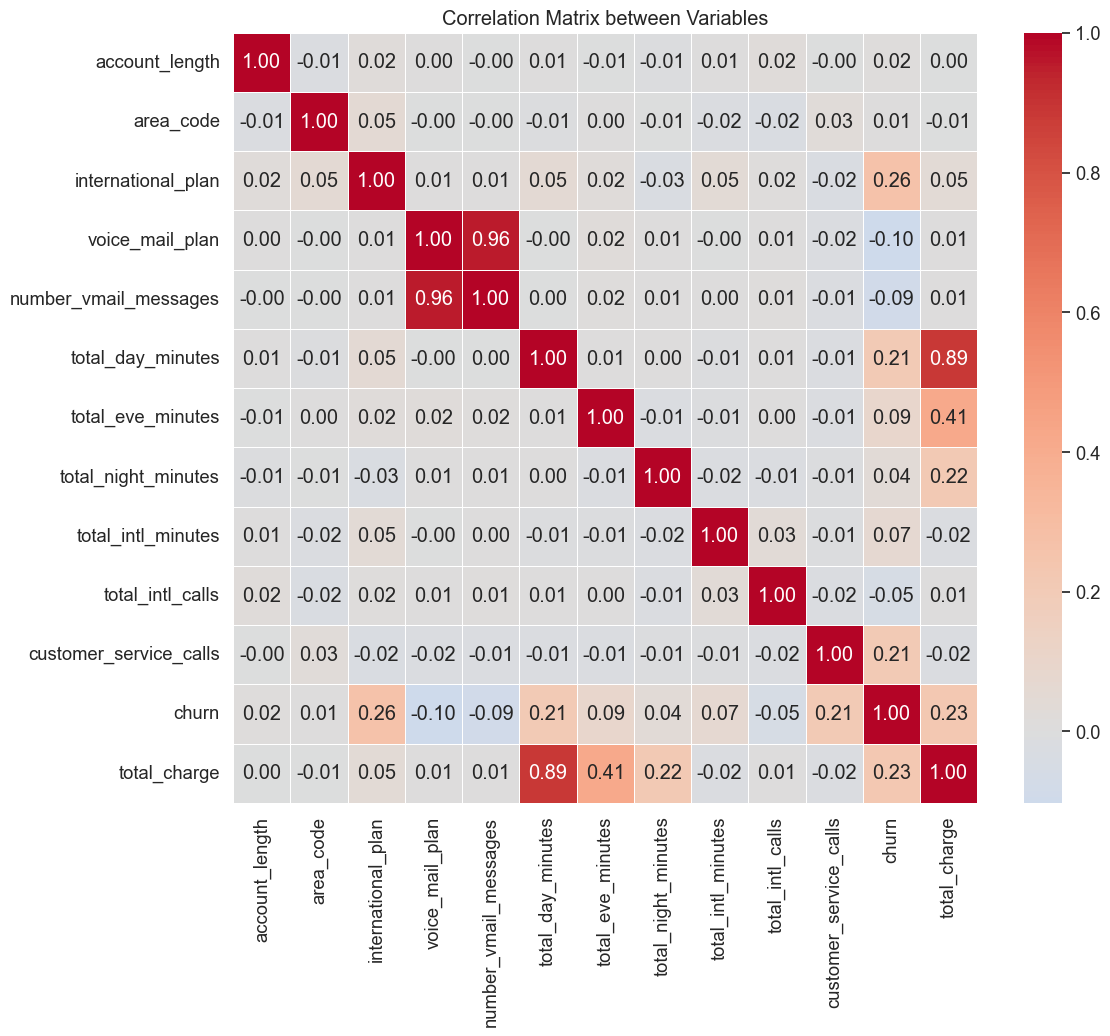

In [3872]:
# Calculate the correlation matrix
corr_matrix = numeric.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, center=0)
plt.title('Correlation Matrix between Variables')
plt.show();

Taking a closer second look...this matrix is super interesting. Our target variable 'churn' has a higher correlation with 'total_day_minutes' than the equivalent for evening or night calls...which makes sense given that we now know day phone-calls cost so much more.

However, we also know international phone calls are quite expensive, yet whether or not a person has an 'international_plan' seems to be far more impactful on churn than the 'total_intl_minutes' they spent calling. 

##### Intl # Calls vs. # Minutes

Furthermore, 'total_intl_minutes' has a positive correlation with churn, yet 'total_intl_calls' has a negative correlation.

Why is this?

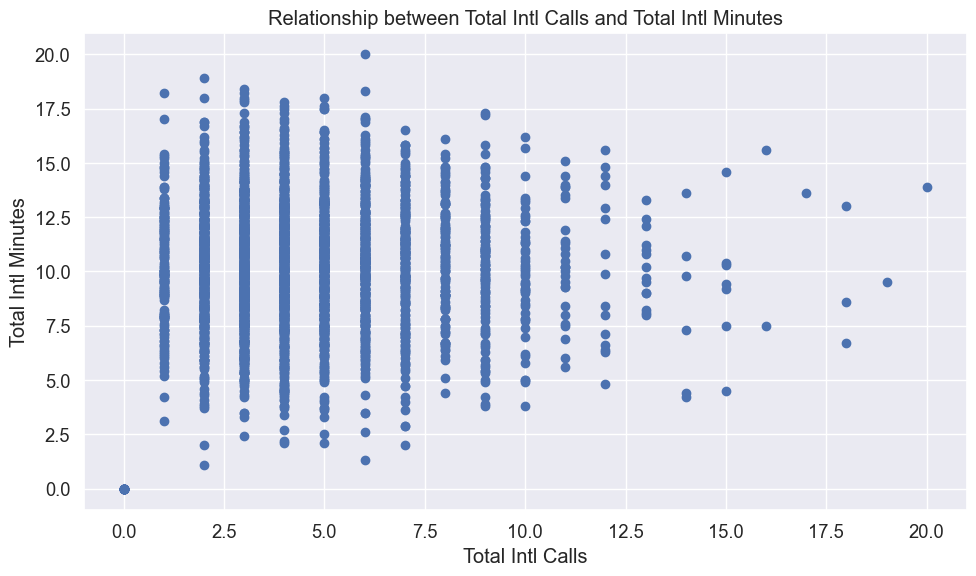

In [3873]:
# Plotting number of intl calls compared to number of intl minutes

plt.figure(figsize=(10, 6))
plt.scatter(df['total_intl_calls'], df['total_intl_minutes'], marker='o', color='b')
plt.xlabel('Total Intl Calls')
plt.ylabel('Total Intl Minutes')
plt.title('Relationship between Total Intl Calls and Total Intl Minutes')
plt.grid(True)
plt.tight_layout()
plt.show()

Interesting...Clearly there are outliers. Most of our data here is for customers who made 1-10 international calls.

Because # of intl calls is a discrete variable, let's plot this on a normalized bar graph and see how it compares to our graph above.

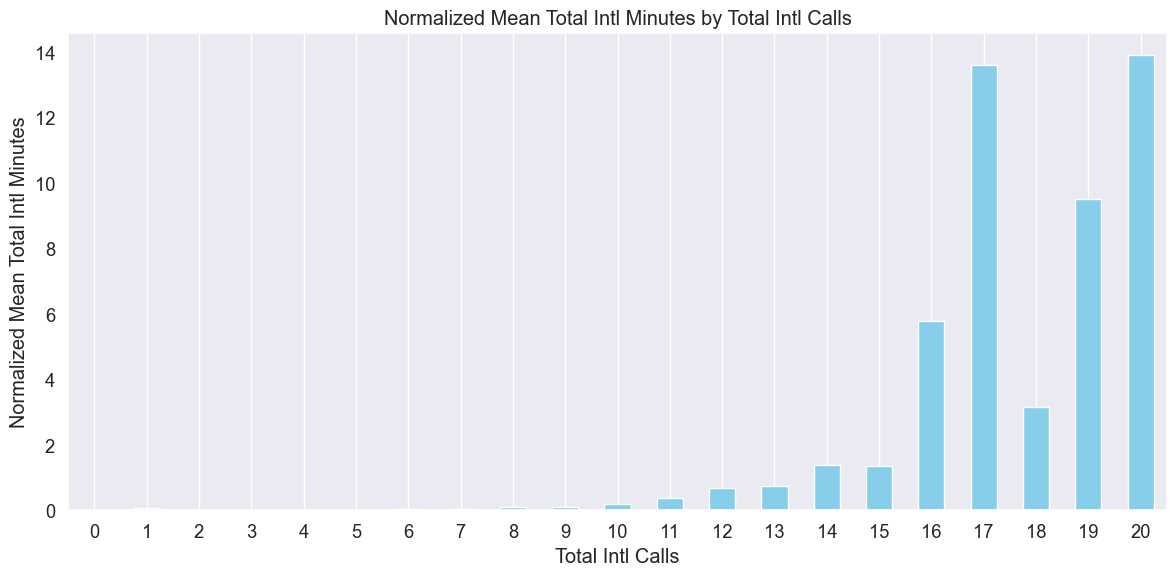

In [3874]:
# Grouping data by 'total_intl_calls' and calculating the mean 'total_intl_minutes' for each group
intl_calls_means = df.groupby('total_intl_calls')['total_intl_minutes'].mean()

# Calculating value counts for 'total_intl_calls'
intl_calls_counts = df['total_intl_calls'].value_counts()

# Normalizing by dividing means by value counts
normalized_means = intl_calls_means / intl_calls_counts

# Plotting the normalized data
plt.figure(figsize=(12, 6))
normalized_means.plot(kind='bar', color='skyblue')
plt.xlabel('Total Intl Calls')
plt.ylabel('Normalized Mean Total Intl Minutes')
plt.title('Normalized Mean Total Intl Minutes by Total Intl Calls')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y')  # Add gridlines on the y-axis
plt.tight_layout()
plt.show()

In [3875]:
df['total_intl_calls'].value_counts(normalize=True)

total_intl_calls
3     0.200420
4     0.185719
2     0.146715
5     0.141614
6     0.100810
7     0.065407
1     0.048005
8     0.034803
9     0.032703
10    0.015002
11    0.008401
0     0.005401
12    0.004500
13    0.004200
15    0.002100
14    0.001800
18    0.000900
16    0.000600
19    0.000300
20    0.000300
17    0.000300
Name: proportion, dtype: float64

It doesn't look like there's an issue of international calls "cutting out" due to technical difficulties, leading to a higher frequency of calls that need to be made to complete a conversation.

We can therefore **drop total_intl_calls**.

In [3876]:
df.drop('total_intl_calls', axis=1, inplace=True)

Furthermore, if we remember back from our data understanding...most of our customers did **not** purchase an international plan...yet this is highly correlated with churn. Let's take a look at the numbers again.

In [3877]:
df['churn'].value_counts(normalize=True)

churn
0    0.855086
1    0.144914
Name: proportion, dtype: float64

In [3878]:
df['international_plan'].value_counts(normalize=True)

international_plan
0    0.90309
1    0.09691
Name: proportion, dtype: float64

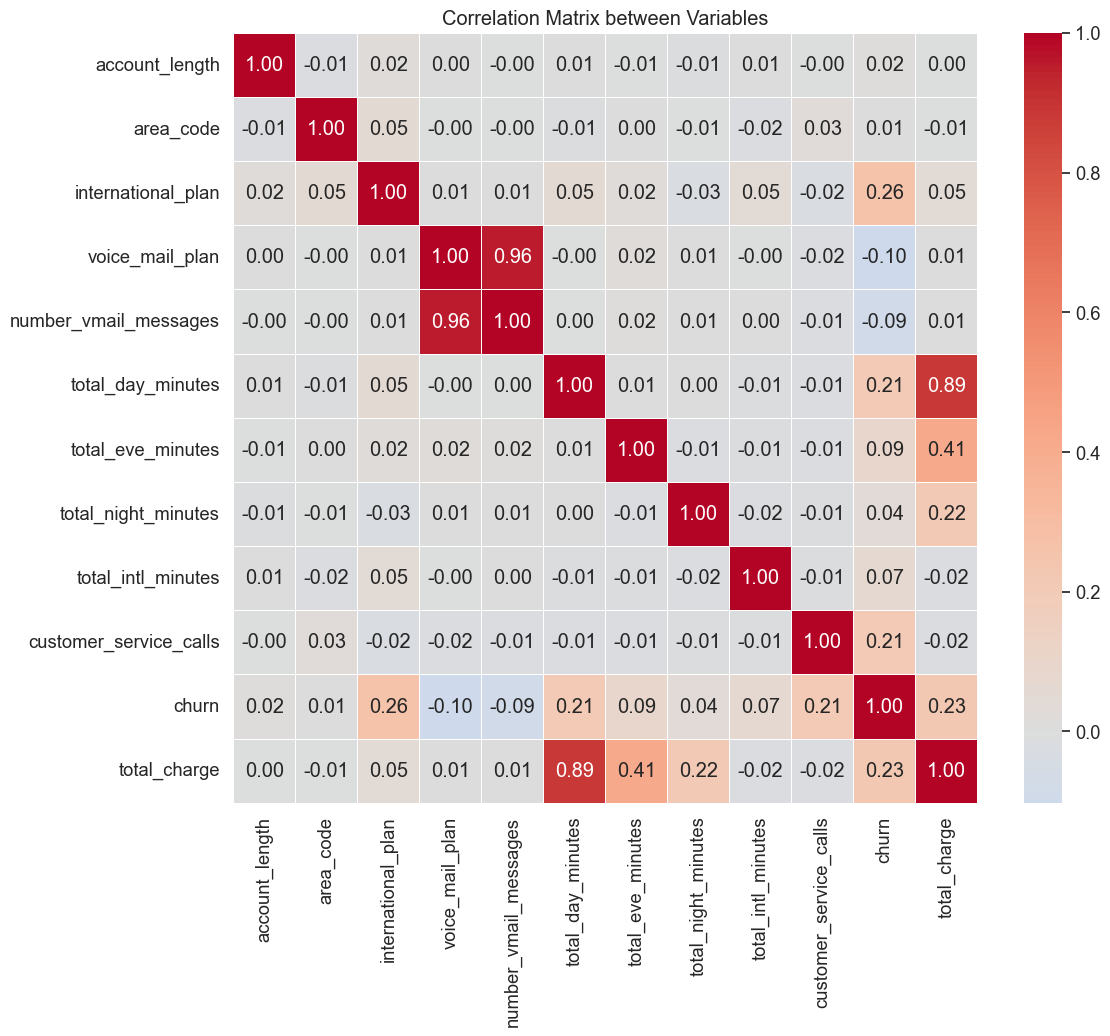

In [3879]:
numeric = df.select_dtypes(include=['float64','int64'])
# Calculate the correlation matrix
corr_matrix = numeric.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, center=0)
plt.title('Correlation Matrix between Variables')
plt.show();

# Logistic Regression

#### Imbalanced Dataset: SMOTE

Let's start running regression models, and see if this helps us better understand our data. 

Because our data is **imbalanced** with regards to our target variable 'churn', let's use SMOTE to handle this imbalance.

In [3880]:
# Assuming 'numeric' is your dataframe with numeric features and 'churn' is the target variable

# Split data into features (X) and target variable (y)
X = numeric.drop('churn', axis=1)  # Features
y = numeric['churn']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Explore target column breakdown in train data

In [3881]:
# Code to explore
y_train.value_counts(normalize=True)

churn
0    0.856714
1    0.143286
Name: proportion, dtype: float64

How accurate would that baseline be on test data?

In [3882]:
# Code to find the answer
y_test.value_counts(normalize=True)

churn
0    0.848576
1    0.151424
Name: proportion, dtype: float64

In [3883]:
# Scale the data
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3884]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

##### Logistic Regression

Regularization Strength - Identifying C value.

Let's start with the default of C=1.0. If our dataset is noisy or complex, and we suspect underfitting, we can increase C and allow the model to fit the training data more closely. If we suspect overfitting, the opposite will be true.

solver = 'lbfgs' (default max_iter of 100). 

In [3885]:
y_train_smote.value_counts()

churn
0    2284
1    2284
Name: count, dtype: int64

In [3886]:
# Initialize logistic regression model
logreg = LogisticRegression(solver='lbfgs', random_state=42)

### Finding Best Parameters Using Cross-Validation Grid Search

In [3887]:
param_grid = {'C': [0.1, 1.0, 10.0]}
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5)
grid_search.fit(X_train_smote, y_train_smote)

# Evaluate best model
best_logreg = grid_search.best_estimator_
y_pred = best_logreg.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.79      0.87       566
           1       0.41      0.80      0.54       101

    accuracy                           0.79       667
   macro avg       0.68      0.80      0.70       667
weighted avg       0.87      0.79      0.82       667



In [3888]:
# Access best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 0.1}


In [3889]:
# Apply logistic regression using optimal parameters

In [3890]:
# Create logistic regression with C=0.1
logreg = LogisticRegression(C=0.1, solver='lbfgs', random_state=42)

# Fit the model on the training data
logreg.fit(X_train_smote, y_train_smote)

# Predict on the test data
y_pred = logreg.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.79      0.87       566
           1       0.41      0.80      0.54       101

    accuracy                           0.79       667
   macro avg       0.68      0.80      0.70       667
weighted avg       0.87      0.79      0.82       667



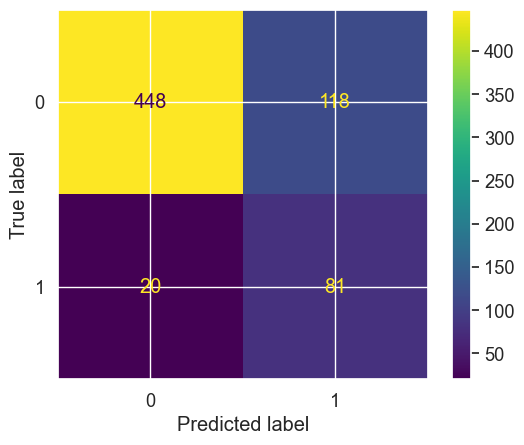

In [3891]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test_scaled, y_test)

In [3892]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.79      0.87       566
           1       0.41      0.80      0.54       101

    accuracy                           0.79       667
   macro avg       0.68      0.80      0.70       667
weighted avg       0.87      0.79      0.82       667



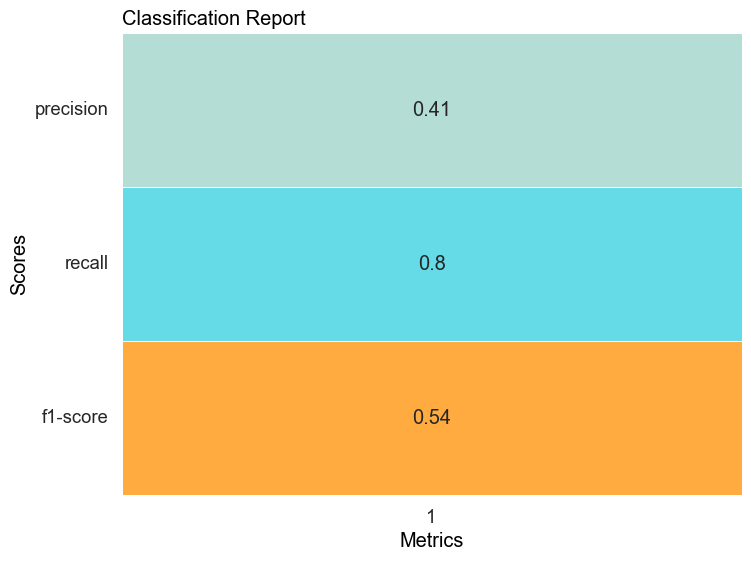

In [3893]:
# Saving heat map for powerpoint presentation

# Example classification report text
classification_report_text = '''
              precision    recall  f1-score   support

           0       0.96      0.79      0.87       566
           1       0.41      0.80      0.54       101

    accuracy                           0.79       667
   macro avg       0.68      0.80      0.70       667
weighted avg       0.87      0.79      0.82       667
'''

# Function to parse classification report
def parse_classification_report(report):
    lines = report.strip().split('\n')
    lines = [line.strip() for line in lines if line.strip()]

    # Initialize dictionary to store metrics
    report_dict = {}

    # Parse each line of the classification report
    for line in lines[2:-3]:  # Exclude header and footer lines
        row = line.split()
        if len(row) < 5:
            continue  # Skip lines that don't contain metrics
        class_name = row[0]
        metrics = [float(val) for val in row[1:]]
        report_dict[class_name] = {
            'precision': metrics[0],
            'recall': metrics[1],
            'f1-score': metrics[2],
            'support': metrics[3]
        }

    return report_dict

# Parse the classification report text
report_dict = parse_classification_report(classification_report_text)

# Convert the report dictionary to a DataFrame for easier plotting
df_report = pd.DataFrame.from_dict(report_dict, orient='index')

# Remove 'macro avg' and 'weighted avg' from the DataFrame
df_report = df_report.drop(['macro avg', 'weighted avg'], errors='ignore')

# Plotting the classification report
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

# Define custom colors
custom_colors = ['#b4ddd6', '#ffab40', '#64dbe7']

# Create heatmap with custom colors
ax = sns.heatmap(df_report[['precision', 'recall', 'f1-score']].T,
                 annot=True,
                 cmap=sns.color_palette(custom_colors),
                 cbar=False,
                 linewidths=.5)

# Set title and labels with white text
ax.set_title('Classification Report', loc='left', color='black')
ax.set_xlabel('Metrics', color='black')
ax.set_ylabel('Scores', color='black')

# Rotate yticks to horizontal
plt.yticks(rotation=0)

# Save the plot with transparent background
plt.savefig('classification_report.png', transparent=True, bbox_inches='tight')
plt.show()

### Logistic Regression: Model Interpretation

***Confusion Matrix***...

TN (True Negative): 382 predicted no-churn (0), and actually no-churn (1)

FP (False Positive): 184 predicted churn (1) but actually no-churn (0)

FN (False Negative): 13 predicted no-churn (0) but actually churn (1)

TP (True Positive): 88 predicted churn (1) and actually churn (1)


***Classification Report***...

Precision (ratio correctly predicited positive to total predicted positive)...for no-churn (0) it's 0.97. For churn (1), it's 0.32.

Recall (ratio correctly predicted positive observations to all observations in actual class)...for no-churn (0) it's 0.67. For churn (1) it's 0.87.

F1-score ("harmonic mean of precision and recall")...for no-churn (0) it's 0.80, for churn (1) it's 0.47

Accuracy (proportion of correctly predicted instances out of total instances)


High no-churn (0) precision, but lower recall for churn (1) indicates this model might correctly ideintify no-churn customers more often than churn one. Our lower F1-score for churn (1), further indicates there's room for improvement in predicting churned customers.


Hyperparameter Tuning - Cross Validation

### Calculate ROC-AUC

In [3894]:
# Calculate roc-auc
# Need predicted probabilities
test_probas = logreg.predict_proba(X_test_scaled)[:,1]

roc_auc_score(y_test, test_probas)

np.float64(0.833922261484099)

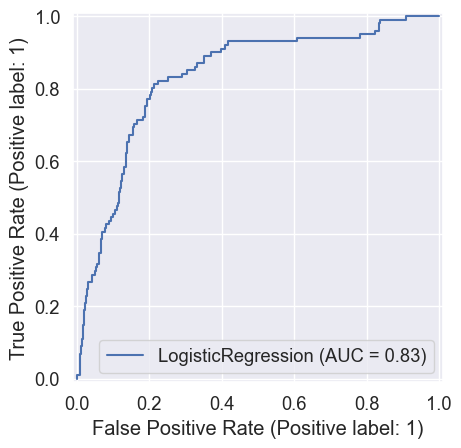

In [3895]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(logreg, X_test_scaled, y_test);

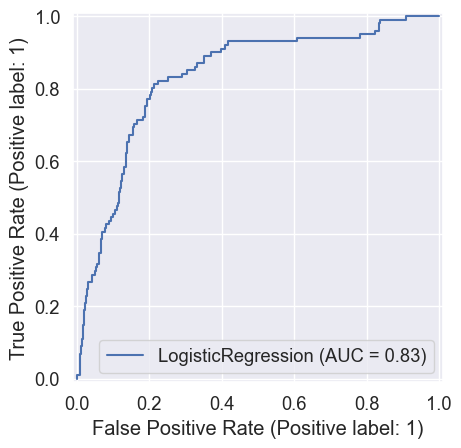

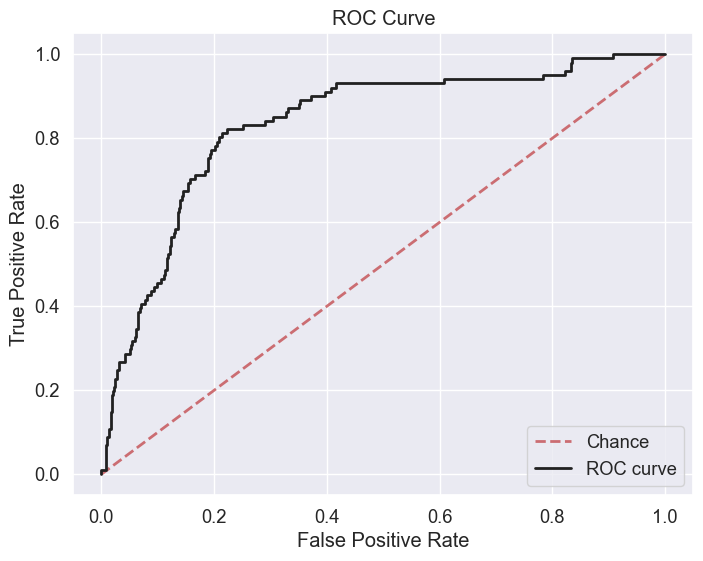

In [3896]:
# Savinging transparent for powerpoint presentation

# Plot the ROC curve
disp = RocCurveDisplay.from_estimator(logreg, X_test_scaled, y_test)

# Customize the plot
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)  # Plot the chance line
plt.plot(disp.fpr, disp.tpr, color='#212121', lw=2, label='ROC curve')  # Plot the ROC curve with custom color
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Save the plot with transparent background
plt.savefig('roc_curve_custom_color.png', transparent=True, bbox_inches='tight')
plt.show()

# Decision Tree

We'll account for an imbalance in our dataset using class_weight.

In [3897]:
# Initialize Decision Tree model
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Fit the model on the training data
dt.fit(X_train, y_train)

# Predict on the original testing data
y_pred = dt.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       566
           1       0.77      0.76      0.77       101

    accuracy                           0.93       667
   macro avg       0.86      0.86      0.86       667
weighted avg       0.93      0.93      0.93       667



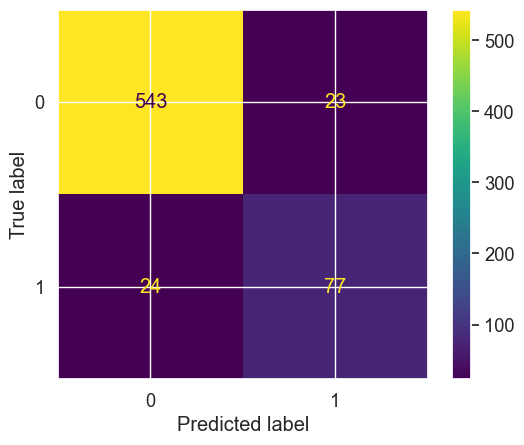

In [3898]:
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)

In [3899]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       566
           1       0.77      0.76      0.77       101

    accuracy                           0.93       667
   macro avg       0.86      0.86      0.86       667
weighted avg       0.93      0.93      0.93       667



In [3900]:
# Calculate roc-auc
# Need predicted probabilities
test_probas = dt.predict_proba(X_test)[:,1]

roc_auc_score(y_test, test_probas)

np.float64(0.8608700976104677)

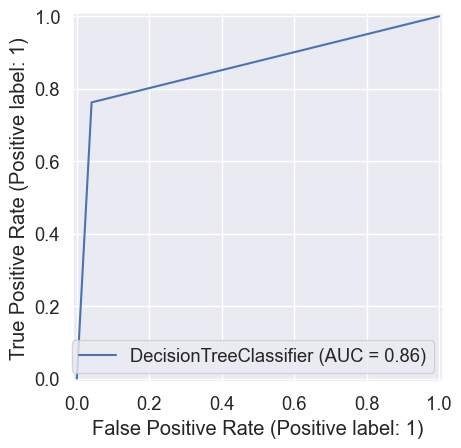

In [3901]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(dt, X_test, y_test);

### Visualizing Decision Tree - Feature Importance

Let's use our decision tree model to figure out what features are most important in predicting our target variable. We can then visualize these features.

In [3902]:
importances = dt.feature_importances_
feature_names = X_train.columns
feature_importance_pairs = list(zip(feature_names, importances))
feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)  # Sort by importance
top_features = [pair[0] for pair in feature_importance_pairs[:5]]  # Select top 5 features

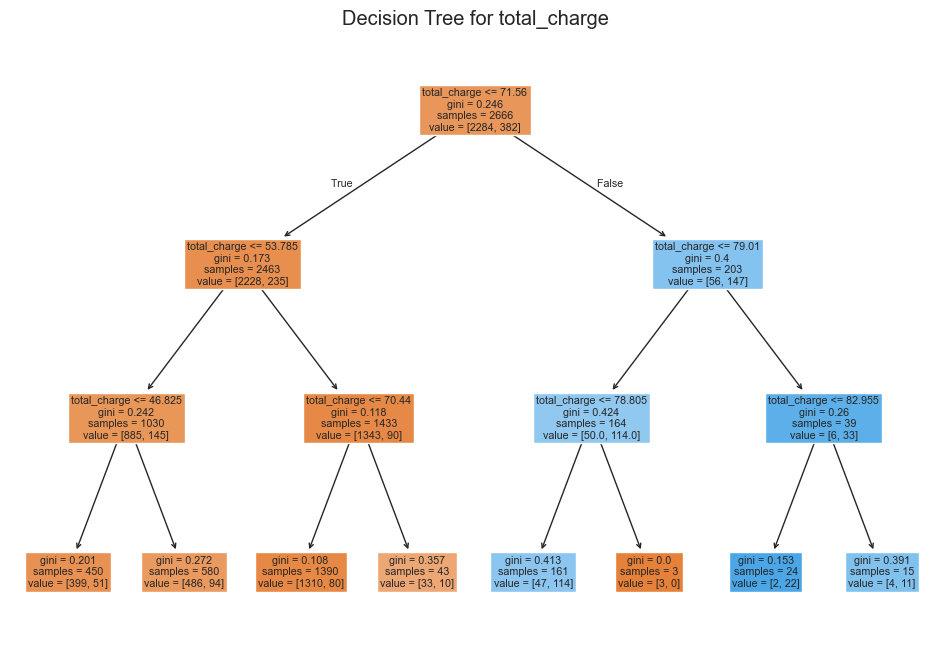

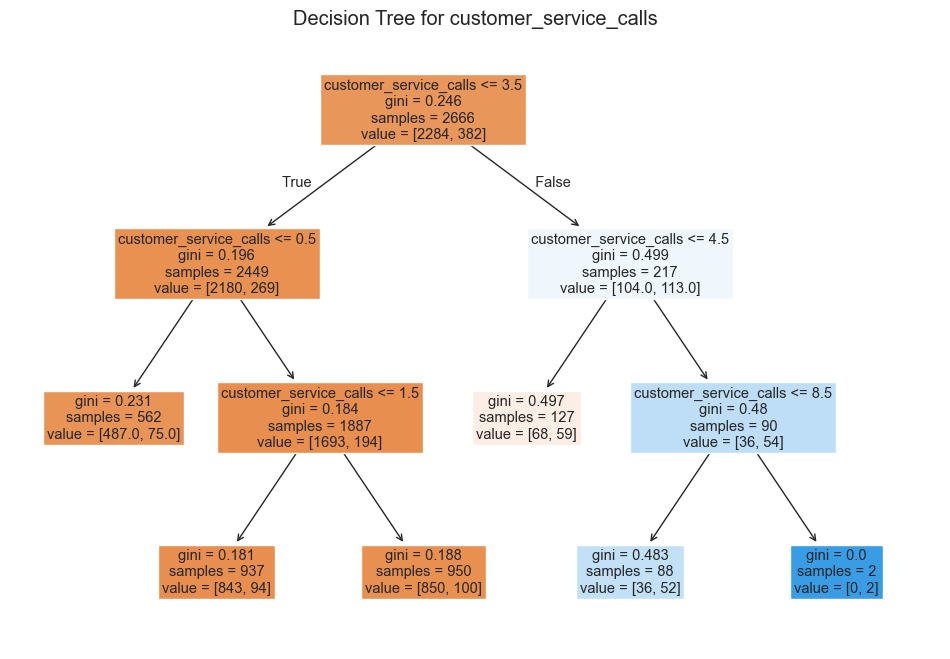

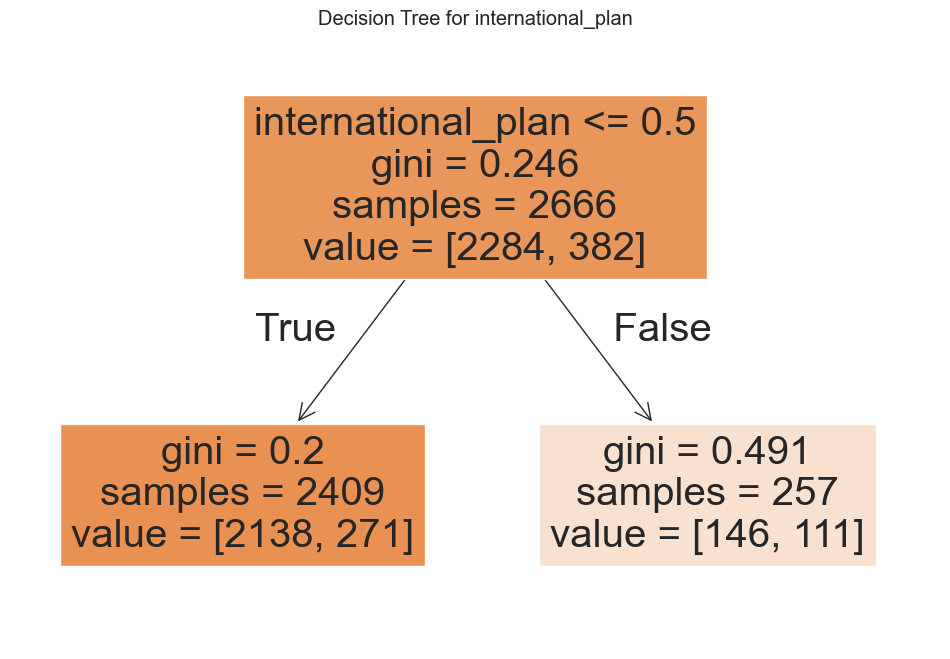

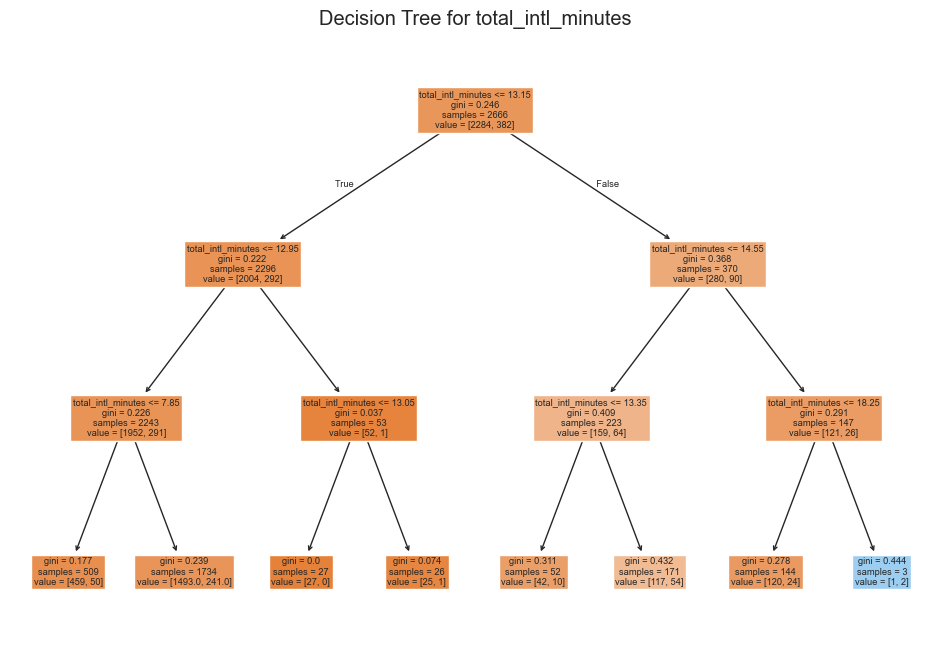

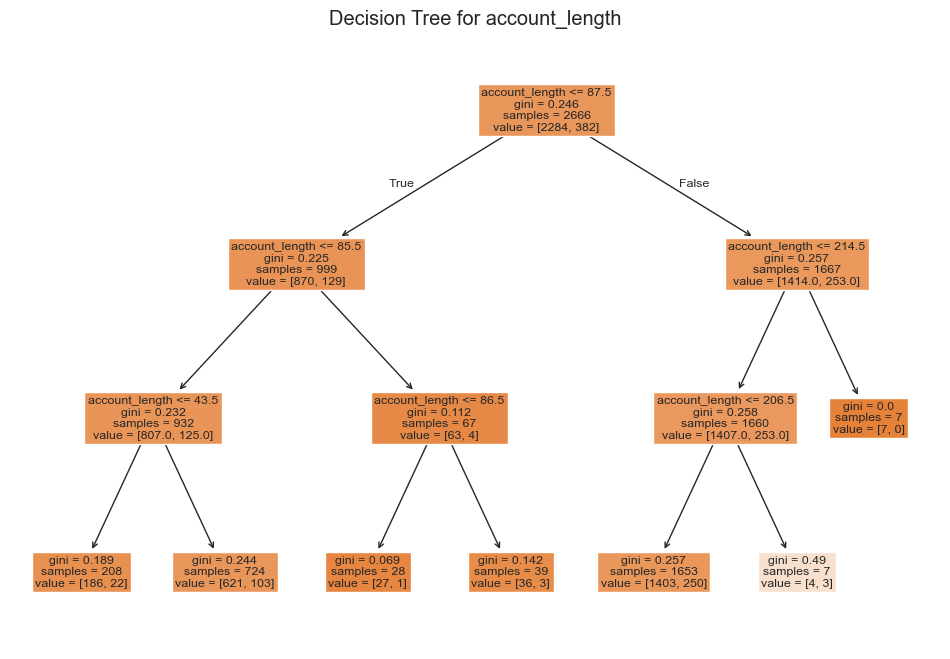

In [3903]:
# Plot
for feature in top_features:
    plt.figure(figsize=(12, 8))
    dt = DecisionTreeClassifier(random_state=42, max_depth=3)  # Limiting depth for clearer visualization
    dt.fit(X_train[[feature]], y_train)
    plot_tree(dt, feature_names=[feature], filled=True)
    plt.title(f"Decision Tree for {feature}")
    plt.show()

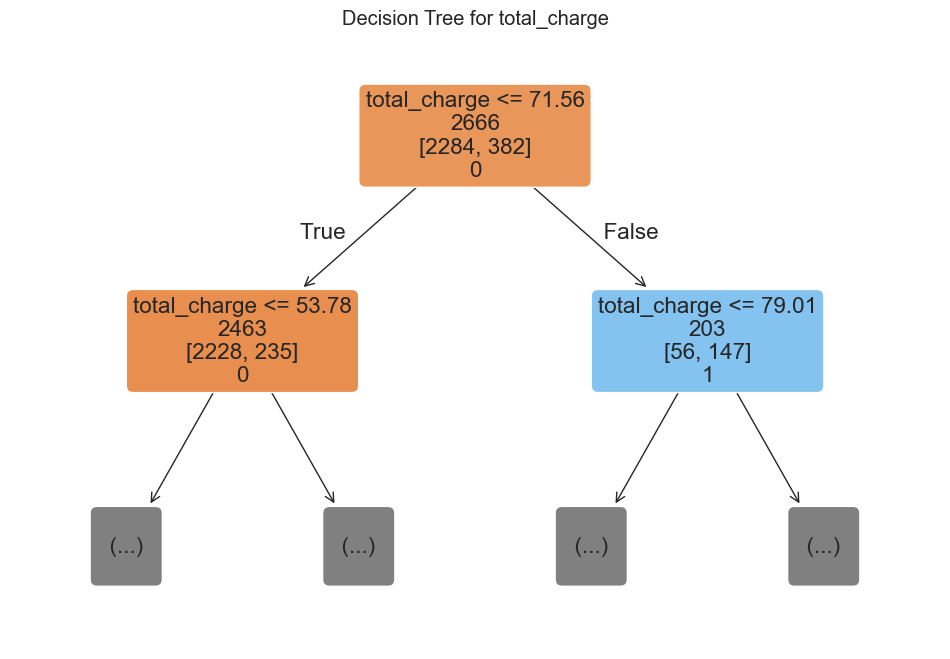

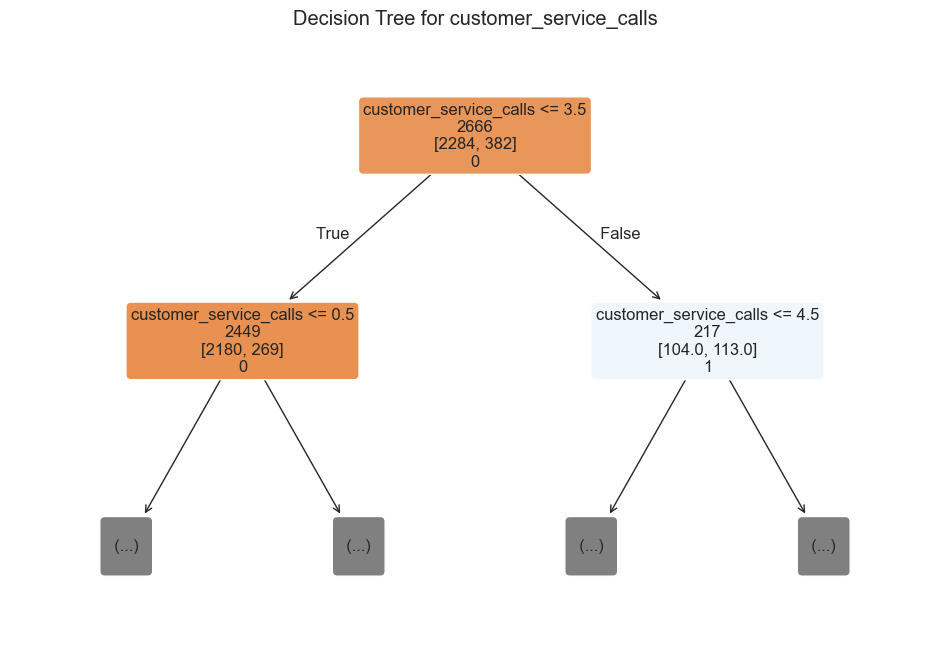

In [3904]:
# Printing for presentation 

# Define the top features to visualize
top_features = ['total_charge', 'customer_service_calls']

# Custom colors
custom_colors = ['#ffab40', '#64dbe7']

# Plotting decision trees for each feature
for feature in top_features:
    plt.figure(figsize=(12, 8))
    
    # Train decision tree model
    dt = DecisionTreeClassifier(random_state=42, max_depth=2)  # Limiting depth for clearer visualization
    dt.fit(X_train[[feature]], y_train)
    
    # Plot the decision tree with only root node and one level after the root node
    plot_tree(dt, feature_names=[feature], filled=True, max_depth=1,
              impurity=False, class_names=['0', '1'],
              label='none', rounded=True, precision=2)
    
    # Customize plot
    plt.title(f"Decision Tree for {feature}")
    plt.gca().patch.set_alpha(0.0)  # Set transparent background
    plt.savefig(f"decision_tree_{feature}_root.png", transparent=True, bbox_inches='tight')  # Save with transparent background
    plt.show()

# Feature Tuning

This is really interesting, and makes a lot of sense when you think about it. At first glance, it might seem confusing that customers with a **lower** total_charge are **more** likely to churn. Same for total_intl_minutes, or number of customer_service_calls...these seem like features that would indicate higher financial distress and/or greater technical difficulties for a person, which would in turn seem to predict churn.

However, **if a person does churn, they are likely to have lower account_length, which would make for lower numbers in all other numeric features**. We need to create new features that account for this, then run these models again.

### New Dataframe, with Normalized Features accounting for differences in account_length.

Let's create a new dataframe, with columns that account for differences in account length.

In [3905]:
# Creating dataframe with normalized columns by account_length
norm_df = df.copy()
norm_df.head()

state  account_length  area_code  international_plan  voice_mail_plan  \
0    KS             128        415                   0                1   
1    OH             107        415                   0                1   
2    NJ             137        415                   0                0   
3    OH              84        408                   1                0   
4    OK              75        415                   1                0   

   number_vmail_messages  total_day_minutes  total_eve_minutes  \
0                     25              265.1              197.4   
1                     26              161.6              195.5   
2                      0              243.4              121.2   
3                      0              299.4               61.9   
4                      0              166.7              148.3   

   total_night_minutes  total_intl_minutes  customer_service_calls  churn  \
0                244.7                10.0                       1      0   
1                254.4                13.7                       1      0   
2                162.6                12.2                       0      0   
3                196.9                 6.6                       2      0   
4                186.9                10.1                       3      0   

  prefix  total_charge  
0    382         72.86  
1    371         55.54  
2    358         59.00  
3    375         65.02  
4    330         49.36

In [3906]:
# Shortening column names for clarity - remembering we are only focusing on the total 'minutes' per time of day, 
# since we can calculate the total charge 
#Finding percentage of minutes allotted to different times of day
norm_df['total_minutes'] = norm_df['total_day_minutes'] + norm_df['total_eve_minutes'] + norm_df['total_night_minutes']

norm_df['perc_daymin'] = norm_df['total_day_minutes'] / norm_df['total_minutes']

norm_df['perc_evemin'] = norm_df['total_eve_minutes'] / norm_df['total_minutes']

norm_df['perc_nightmin'] = norm_df['total_night_minutes'] / norm_df['total_minutes']

#Finding average number of intl minutes a day
norm_df['avg_intlmin_daily'] = norm_df['total_intl_minutes'] / norm_df['account_length']

### Customer Service Calls & Vmail Messages -- Per Week

For a feature such as customer_service_calls, it will be more helpful for our stakeholders if we normalize by account_length by calculating the average number of customer service calls across a larger span of time. It's very rare that someone makes multiple customer service calls a day. 

We'll first try to find the average customer service calls made **weekly** by a customer. We can adjust depending on how helpful our numbers are.

We'll do the same for voicemail messages. As these are also far less-frequent per-day than "number of minutes" spent on a call. 

In [3907]:
# Make a new column calculating the number of weeks a customer was active
norm_df['weeks_active'] = norm_df['account_length'] / 7

norm_df['avg_custservice_weekly'] = norm_df['customer_service_calls'] / norm_df['weeks_active']

norm_df['avg_vmail_weekly'] = norm_df['number_vmail_messages'] / norm_df['weeks_active']

### Comparing Customer Engagement

It will be helpful, from a predictive standpoint, to give our stakeholders the ability to compare a customer's activity (ex. minutes spent on the phone per day) with the average customer activity...that way we can take new customers and determine how likely they are to churn or not-churn depending on where they fall in comparison to the rest of the customer base.

We can do this by calculating the average total_minutes spent calling by all the rows in our dataframe...then calculate each individual customer's standard deviation away from this mean.

In [3908]:
# Average minutes a day depending on time of day
norm_df['avg_daymin_daily'] = norm_df['total_day_minutes'] / norm_df['account_length']

norm_df['avg_evemin_daily'] = norm_df['total_eve_minutes'] / norm_df['account_length']

norm_df['avg_nightmin_daily'] = norm_df['total_night_minutes'] / norm_df['account_length']

norm_df['avg_totalmin_daily'] = norm_df['avg_daymin_daily'] + norm_df['avg_evemin_daily'] + norm_df['avg_nightmin_daily']

# Calculating mean of total_minutes for entire dataframe
mean_total_minutes = norm_df['avg_totalmin_daily'].mean()

# Calculate the deviation from the mean 
norm_df['calltime_deviation_from_mean'] = norm_df['avg_totalmin_daily'] - mean_total_minutes

Let's do the same thing for our other normalized columns - perc_intlmin_daily, cust_service_norm, and num_vmail_norm

In [3909]:
# Calculating percentage international minutes a day
mean_intl_minutes = norm_df['avg_intlmin_daily'].mean()
norm_df['intlmin_deviation_from_mean'] = norm_df['avg_intlmin_daily'] - mean_intl_minutes

# Customer service calls per week deviation
mean_weekly_custservice = norm_df['avg_custservice_weekly'].mean()
norm_df['custservice_weekly_deviation'] = norm_df['avg_custservice_weekly'] - mean_weekly_custservice

# Number voicemails per week deviation
mean_weekly_vmail = norm_df['avg_vmail_weekly'].mean()
norm_df['vmail_weekly_deviation'] = norm_df['avg_vmail_weekly'] - mean_weekly_vmail

In [3910]:
norm_df.drop('total_day_minutes', axis=1, inplace=True)
norm_df.drop('total_eve_minutes', axis=1, inplace=True)
norm_df.drop('total_night_minutes', axis=1, inplace=True)
norm_df.drop('total_intl_minutes', axis=1, inplace=True)
norm_df.drop('customer_service_calls', axis=1, inplace=True)
norm_df.drop('number_vmail_messages', axis=1, inplace=True)

In [3911]:
norm_df.head()

/opt/anaconda3/envs/learn-env-3.9/lib/python3.10/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


state  account_length  area_code  international_plan  voice_mail_plan  \
0    KS             128        415                   0                1   
1    OH             107        415                   0                1   
2    NJ             137        415                   0                0   
3    OH              84        408                   1                0   
4    OK              75        415                   1                0   

   churn prefix  total_charge  total_minutes  perc_daymin  ...  \
0      0    382         72.86          707.2     0.374859  ...   
1      0    371         55.54          611.5     0.264268  ...   
2      0    358         59.00          527.2     0.461684  ...   
3      0    375         65.02          558.2     0.536367  ...   
4      0    330         49.36          501.9     0.332138  ...   

   avg_custservice_weekly  avg_vmail_weekly  avg_daymin_daily  \
0                0.054688          1.367188          2.071094   
1                0.065421          1.700935          1.510280   
2                0.000000          0.000000          1.776642   
3                0.166667          0.000000          3.564286   
4                0.280000          0.000000          2.222667   

   avg_evemin_daily  avg_nightmin_daily  avg_totalmin_daily  \
0          1.542188            1.911719            5.525000   
1          1.827103            2.377570            5.714953   
2          0.884672            1.186861            3.848175   
3          0.736905            2.344048            6.645238   
4          1.977333            2.492000            6.692000   

   calltime_deviation_from_mean  intlmin_deviation_from_mean  \
0                     -3.602896                    -0.078866   
1                     -3.412943                    -0.028954   
2                     -5.279721                    -0.067940   
3                     -2.482658                    -0.078420   
4                     -2.435896                    -0.022325   

   custservice_weekly_deviation  vmail_weekly_deviation  
0                     -0.117001                0.431033  
1                     -0.106268                0.764780  
2                     -0.171688               -0.936155  
3                     -0.005022               -0.936155  
4                      0.108312               -0.936155  

[5 rows x 24 columns]

Let's look at our state breakdown with these new normalized numbers.

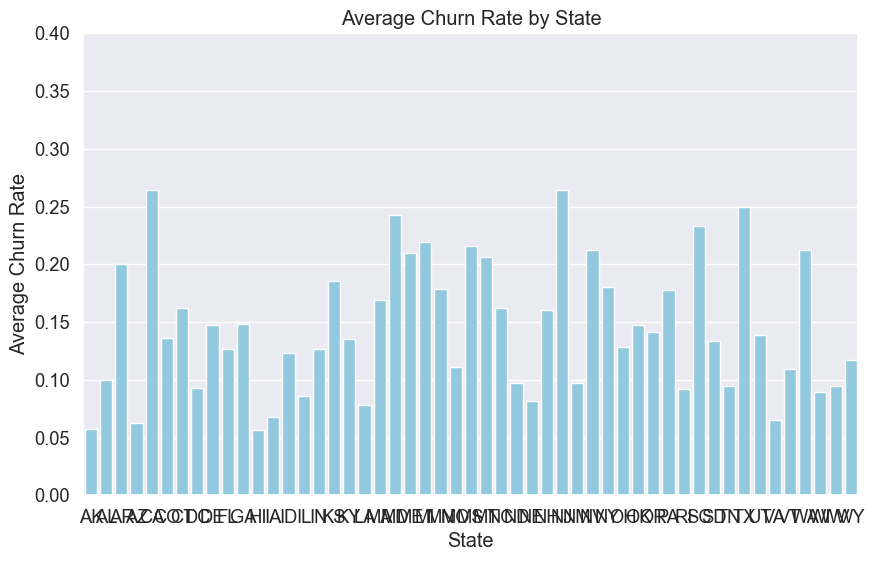

In [3912]:
# Calculate average churn rate by state
avg_churn_by_state = norm_df.groupby('state')['churn'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='state', y='churn', data=avg_churn_by_state, color='skyblue')
plt.title('Average Churn Rate by State')
plt.xlabel('State')
plt.ylabel('Average Churn Rate')
plt.ylim(0.0, 0.4)  # Set y-axis limit
plt.show()

### Minutes VS. Charge

Let's revisit our decision to drop total_minutes as opposed to total_charge. On second thought, this wasn't a great idea because total_charge is helpful in interpreting our predictions, but not making the predictions themselves...we're interested in *customer behavior* that predicts churn, not the outcome of this behavior (such as charge).

In [3913]:
# Dropping total_charge
norm_df.drop('total_charge', axis=1, inplace=True)

#### Feature Selects

Let's make another dataframe norm_selects, with selections of all the features we think we might need to predict churn (ex. something like 'account_length' is not helpful, because this again is hindsight bias rather than a predictive variable).

In [3914]:
norm_df.keys()

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'churn', 'prefix', 'total_minutes', 'perc_daymin',
       'perc_evemin', 'perc_nightmin', 'avg_intlmin_daily', 'weeks_active',
       'avg_custservice_weekly', 'avg_vmail_weekly', 'avg_daymin_daily',
       'avg_evemin_daily', 'avg_nightmin_daily', 'avg_totalmin_daily',
       'calltime_deviation_from_mean', 'intlmin_deviation_from_mean',
       'custservice_weekly_deviation', 'vmail_weekly_deviation'],
      dtype='object')

In [3915]:
norm_selects = norm_df.drop(columns=['account_length', 'weeks_active'], axis=1)

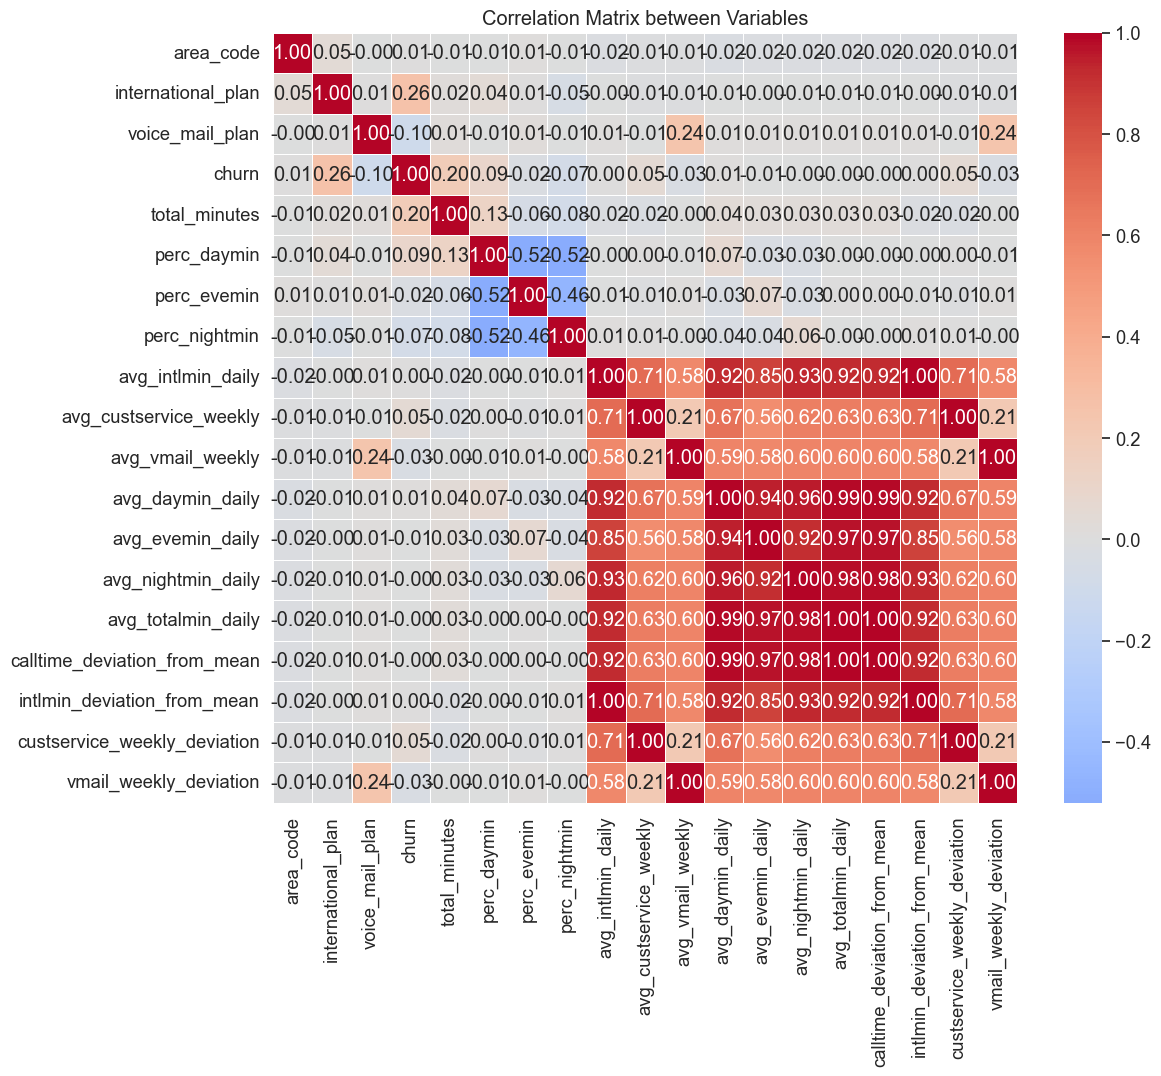

In [3916]:
# Plotting correlation matrix with normalized data
norm_numeric = norm_selects.select_dtypes(include=['float64','int64'])
# Calculate the correlation matrix
corr_matrix = norm_numeric.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, center=0)
plt.title('Correlation Matrix between Variables')
plt.show();

### Lack of Target Variable Correlation

Our new normalized features seem to have very minimal correlation with our target variable, 'churn'. This could be because they have complex, non-linear relationships. Let's use decision trees again. 

We need to account for imbalanced data. We'll use class_weight.

In [3917]:
# X contains your features, and y is your target variable
X = norm_numeric.drop('churn', axis=1)
y = norm_numeric['churn']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Decision Tree model
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Fit the model on the training data
dt.fit(X_train, y_train)

# Predict on the testing data
y_pred = dt.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       566
           1       0.58      0.55      0.57       101

    accuracy                           0.87       667
   macro avg       0.75      0.74      0.74       667
weighted avg       0.87      0.87      0.87       667



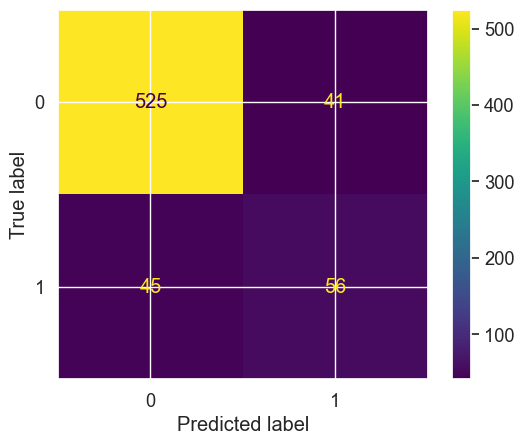

In [3918]:
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)

In [3919]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       566
           1       0.58      0.55      0.57       101

    accuracy                           0.87       667
   macro avg       0.75      0.74      0.74       667
weighted avg       0.87      0.87      0.87       667



In [3920]:
importances = dt.feature_importances_
feature_names = X_train.columns
feature_importance_pairs = list(zip(feature_names, importances))
feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)  # Sort by importance
top_features = [pair[0] for pair in feature_importance_pairs[:5]]  # Select top 5 features

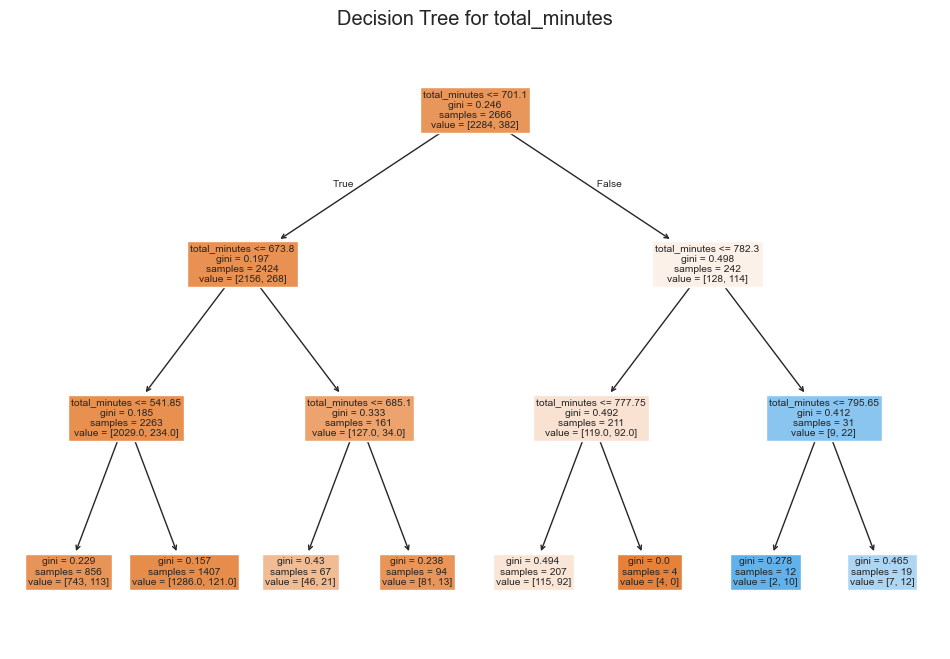

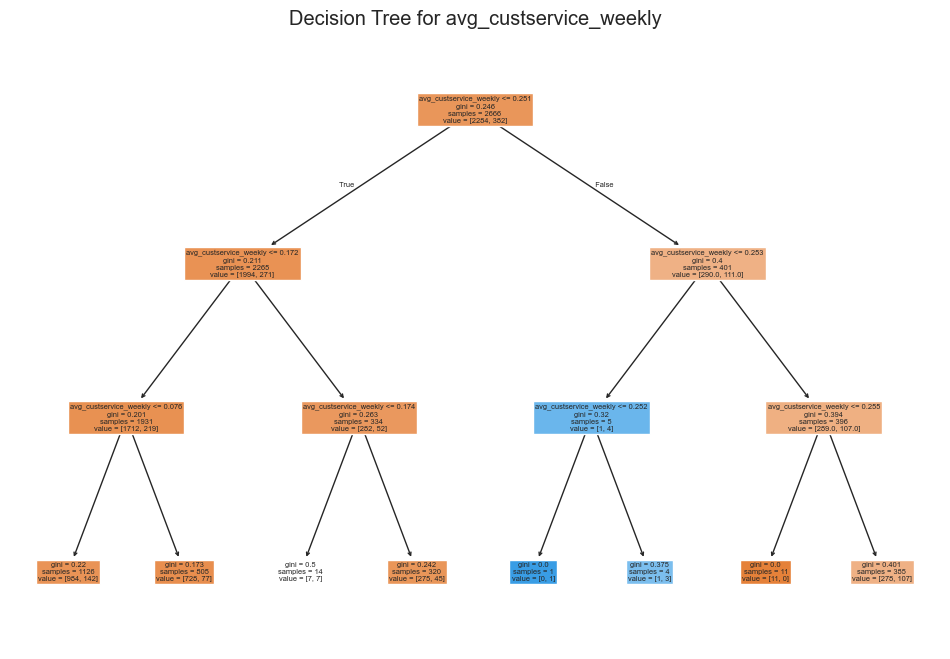

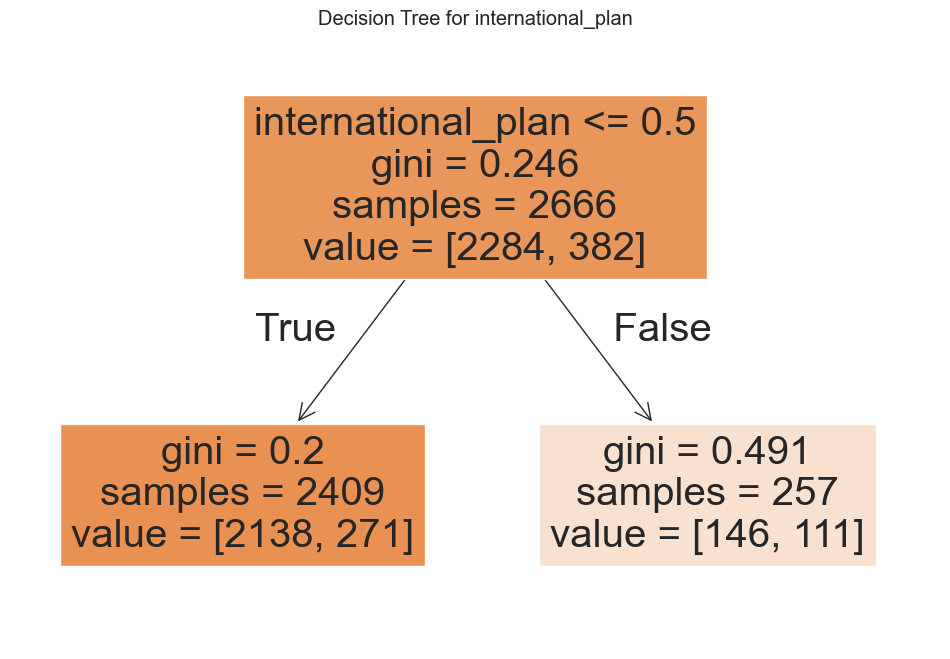

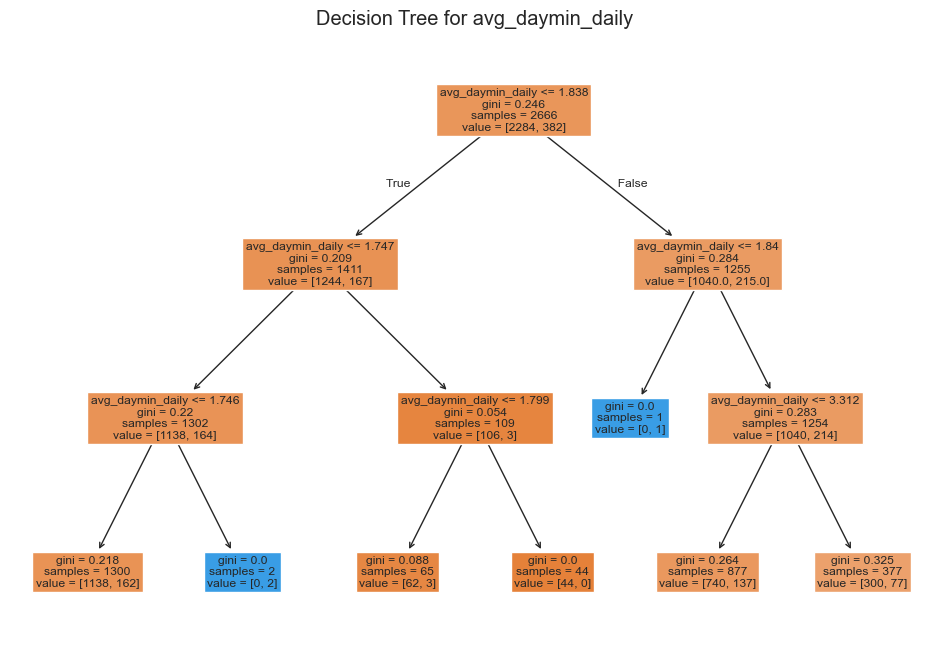

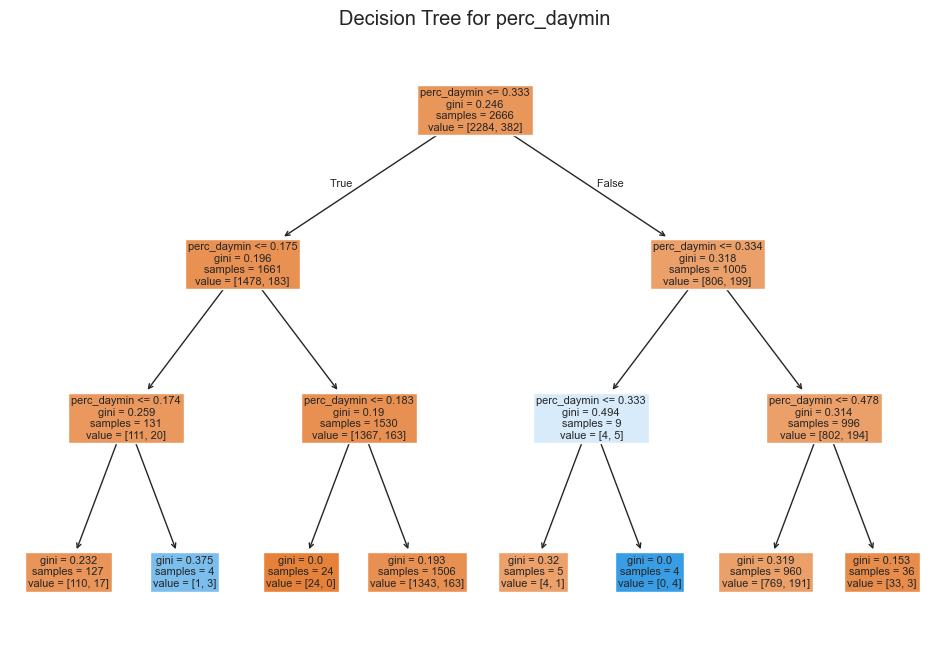

In [3921]:
# Plot
for feature in top_features:
    plt.figure(figsize=(12, 8))
    dt = DecisionTreeClassifier(random_state=42, max_depth=3)  # Limiting depth for clearer visualization
    dt.fit(X_train[[feature]], y_train)
    plot_tree(dt, feature_names=[feature], filled=True)
    plt.title(f"Decision Tree for {feature}")
    plt.show()

# Feature Importance 

Let's try and find our most important features. We can apply this to a few different models.

In [3922]:
# Create a DataFrame to display feature importances
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort features by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
print("Top 10 Most Important Features:")
print(feature_importances_df.head(10))

Top 10 Most Important Features:
                         Feature  Importance
3                  total_minutes    0.218020
8         avg_custservice_weekly    0.133596
1             international_plan    0.115031
10              avg_daymin_daily    0.094383
4                    perc_daymin    0.080733
12            avg_nightmin_daily    0.063143
5                    perc_evemin    0.043741
9               avg_vmail_weekly    0.041535
14  calltime_deviation_from_mean    0.041523
11              avg_evemin_daily    0.037053


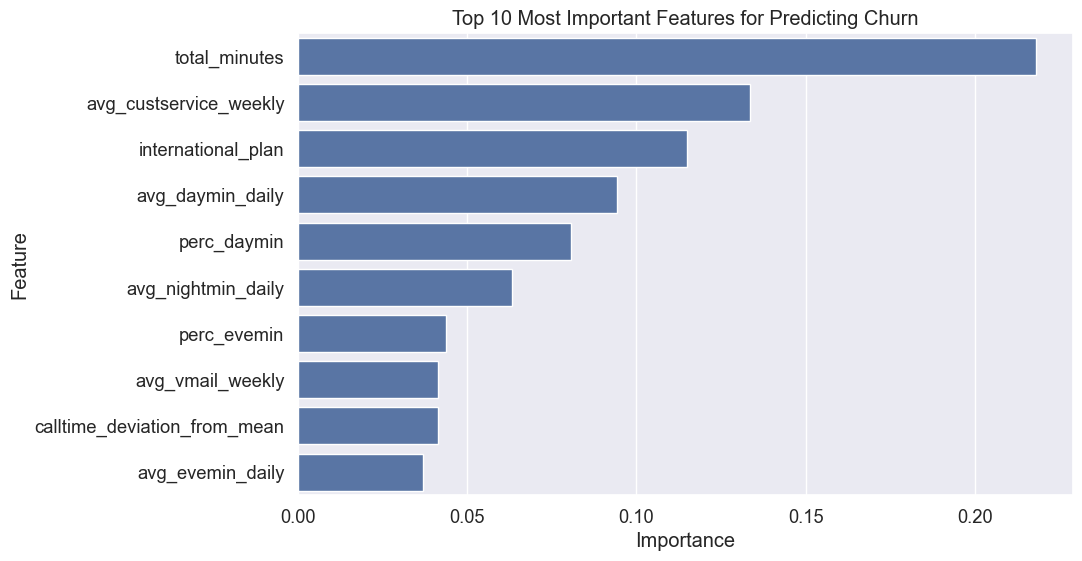

In [3923]:
# Visualize

# Plotting feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(10))
plt.title('Top 10 Most Important Features for Predicting Churn')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Random Forest

Let's try with a Random Forest model. Accounting for imbalanced data once again with class_weight.

In [3924]:
# Initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Predict on the testing data
y_pred_rf = rf.predict(X_test)

# Evaluate the model
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame to display feature importances
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort features by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
print("Top 10 Most Important Features:")
print(feature_importances_df.head(10))

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       566
           1       0.94      0.44      0.59       101

    accuracy                           0.91       667
   macro avg       0.92      0.72      0.77       667
weighted avg       0.91      0.91      0.90       667

Top 10 Most Important Features:
                         Feature  Importance
3                  total_minutes    0.185652
1             international_plan    0.089114
16  custservice_weekly_deviation    0.082610
8         avg_custservice_weekly    0.079465
4                    perc_daymin    0.076477
6                  perc_nightmin    0.059211
10              avg_daymin_daily    0.058357
12            avg_nightmin_daily    0.047209
13            avg_totalmin_daily    0.046861
15   intlmin_deviation_from_mean    0.043064


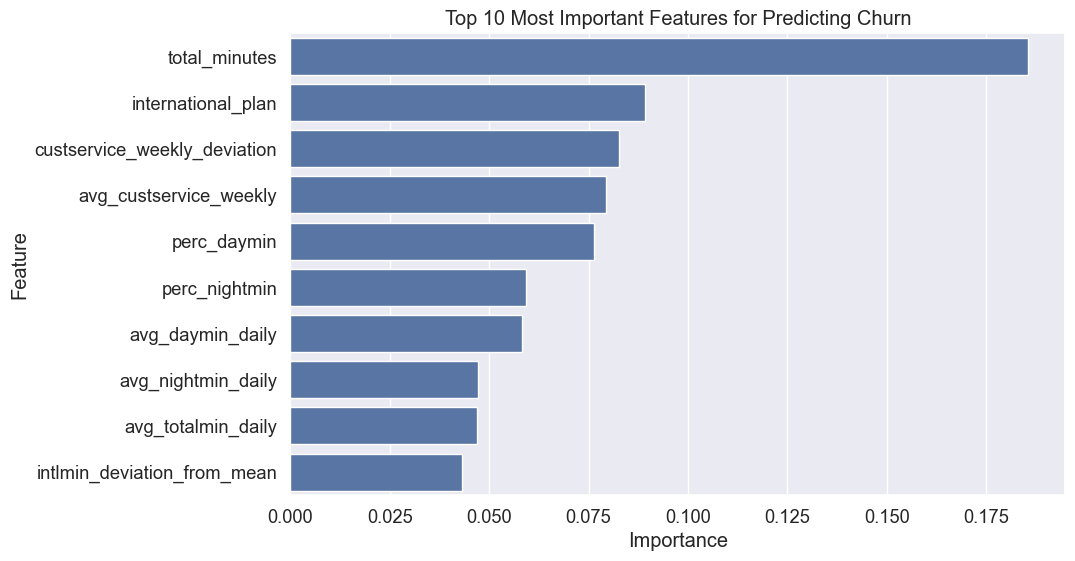

In [3925]:
# Visualize most important features

# Get feature importances from the trained Random Forest model
importances = rf.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort features by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plotting the top N most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(10))
plt.title('Top 10 Most Important Features for Predicting Churn')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Random Forest is usually more reliable for feature selection than Decision Tree. Here is a breakdown of some of the depicted features above:

**perc_custservice_weekly**: Let's drop 'perc_custservice_weekly', since it correlates with 'custservice_weekly_deviation'. Both had correlations of 0.5 with 'churn' in our correlation matrix, yet the latter was identified as more important in both our Decision Tree and Random Forest exploration.

**per_daymin_daily**: This seems to be our most important feature, which makes sense given that we know 'total_charge' was highly correlated with 'churn' and that daytime calls cost more than calls made in eve or night. We'll focus on 'perc_daymin_daily', and drop the equivalent values for eve and night, since day calls are indicative of higher charges as well. We'll keep 'perc_totalmin_daily', to still account for evening and night calls.

**international data**: It's unclear whether 'intlmin_deviation_from_mean' or 'perc_intlmin_daily' will be more helpful. We'll keep both for now.

In [3926]:
# Dropping columns from norm_selects
norm_selects = norm_selects.drop(columns=['avg_custservice_weekly', 'avg_nightmin_daily', 'avg_evemin_daily', 'avg_daymin_daily', 'perc_evemin', 'perc_nightmin'], axis=1)

#Resablishing our numeric data
norm_numeric = norm_selects.select_dtypes(include=['float64','int64'])

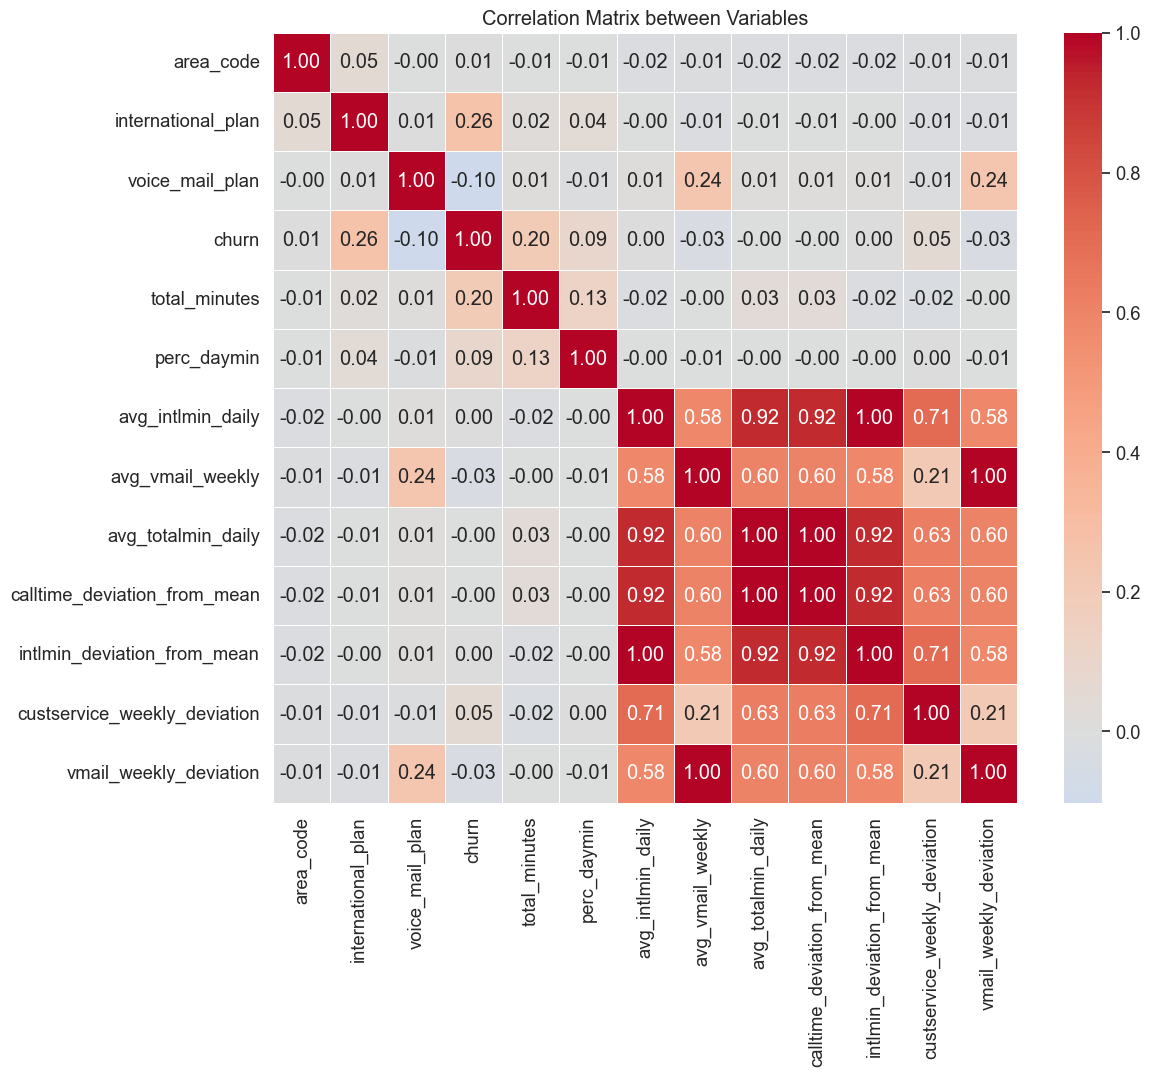

In [3927]:
# Plotting correlation matrix with normalized data
norm_numeric = norm_selects.select_dtypes(include=['float64','int64'])
# Calculate the correlation matrix
corr_matrix = norm_numeric.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, center=0)
plt.title('Correlation Matrix between Variables')
plt.show();

## Multicollinearity - Correlation Analysis, VIF and Lasso

We want to try logistic regression again, with our new normalized features. However, there's a huge risk of multicollinearity, with the strength of correlation between our predictor variables.

We can use VIF (Variance Inflation Factor) to measure how much the variance of regression coefficients are inflated because of collinearity with other predictor variables.

Lasso Regression will then penalize the absolute size of regression coefficients, which help shrink less important predictors towards zero.

Remember that our variables might **simply have a non-linear relationship**, in which case a model like Decision Tree or Random Forest will be more useful than logistic regression. However, we'll toy with our feature selection and correlation coefficients a little more before concluding whether logistic regression is a useful (or not) model.

In [3928]:
# Selecting features to run logistic regression based on correlation matrix
logreg_selects = norm_selects
logreg_selects.drop(columns=['avg_intlmin_daily', 'avg_totalmin_daily', 'calltime_deviation_from_mean', 'intlmin_deviation_from_mean'], axis=1, inplace=True)

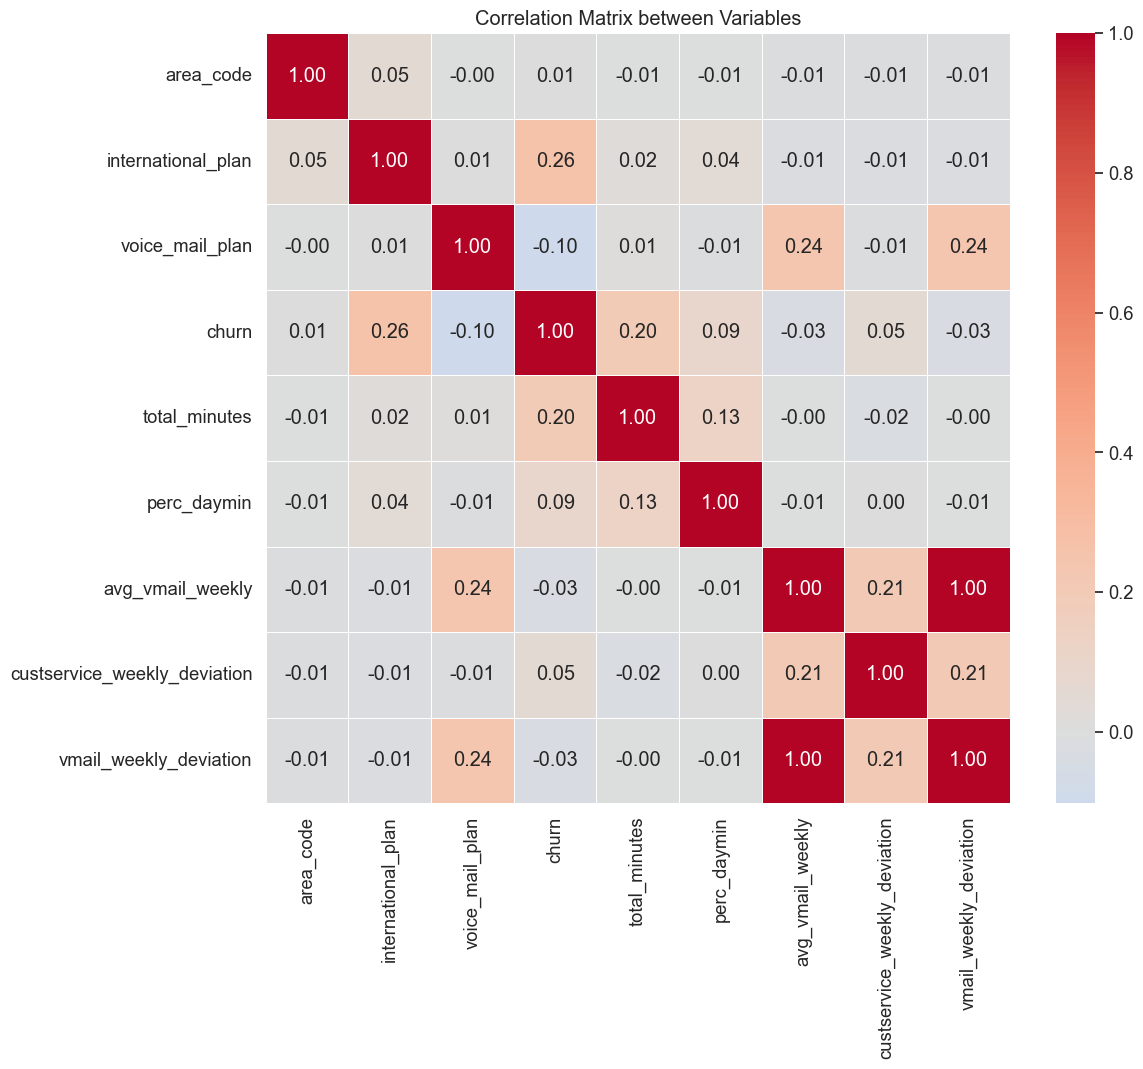

In [3929]:
# Plotting correlation matrix with normalized data
logreg_selects = logreg_selects.select_dtypes(include=['float64','int64'])
# Calculate the correlation matrix
corr_matrix = logreg_selects.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, center=0)
plt.title('Correlation Matrix between Variables')
plt.show();

In [3930]:
# Splitting into X (features) and y (target variable)
X = logreg_selects.drop('churn', axis=1)
y = logreg_selects['churn']

# Calculate VIF for each feature in X
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_df = calculate_vif(X)
print("Variance Inflation Factors:")
print(vif_df)

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform Lasso Regression
lasso = Lasso(alpha=0.01)  # Lowered alpha because of initial lack of features
lasso.fit(X_train_scaled, y_train)

# Evaluate Lasso Model
y_pred = lasso.predict(X_test_scaled)
y_pred_class = np.where(y_pred > 0.5, 1, 0)  # Assuming threshold of 0.5
print("Classification Report:")
# Zero division parameter to account for warning
print(classification_report(y_test, y_pred_class, zero_division=1))

# Selected Features by Lasso
selected_features = X.columns[lasso.coef_ != 0]
print("Selected Features by Lasso:")
print(selected_features)

Variance Inflation Factors:
                        Feature          VIF
0                     area_code     1.002646
1            international_plan     1.004998
2               voice_mail_plan     1.066604
3                 total_minutes     1.018788
4                   perc_daymin     1.019394
5              avg_vmail_weekly  7369.492355
6  custservice_weekly_deviation     1.053126
7        vmail_weekly_deviation  7209.193698
Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       566
           1       1.00      0.01      0.02       101

    accuracy                           0.85       667
   macro avg       0.92      0.50      0.47       667
weighted avg       0.87      0.85      0.78       667

Selected Features by Lasso:
Index(['international_plan', 'voice_mail_plan', 'total_minutes', 'perc_daymin',
       'custservice_weekly_deviation'],
      dtype='object')


We need to drop either perc_vmail_weekly or vmail_weekly_deviation. Let's choose to keep vmail_weekly_deviation.

In [3931]:
logreg_selects.drop('avg_vmail_weekly', axis=1, inplace=True)

## Running Logistic Regression - Selected Features

Let's run logistic regression again, now with our feature selects. 

#### One Hot Encode area code

We'll want to one hot encode our three categorical area_code values.

In [3932]:
# One Hot Encode area code 

categorical_cols = ['area_code']

# Perform one-hot encoding
logreg_selects_encoded = pd.get_dummies(logreg_selects, columns=categorical_cols, drop_first=True)

logreg_selects_encoded.head()

international_plan  voice_mail_plan  churn  total_minutes  perc_daymin  \
0                   0                1      0          707.2     0.374859   
1                   0                1      0          611.5     0.264268   
2                   0                0      0          527.2     0.461684   
3                   1                0      0          558.2     0.536367   
4                   1                0      0          501.9     0.332138   

   custservice_weekly_deviation  vmail_weekly_deviation  area_code_415  \
0                     -0.117001                0.431033           True   
1                     -0.106268                0.764780           True   
2                     -0.171688               -0.936155           True   
3                     -0.005022               -0.936155          False   
4                      0.108312               -0.936155           True   

   area_code_510  
0          False  
1          False  
2          False  
3          False  
4          False

In [3933]:
# Convert to integers
logreg_selects_encoded['area_code_415'] = logreg_selects_encoded['area_code_415'].astype(int)
logreg_selects_encoded['area_code_510'] = logreg_selects_encoded['area_code_510'].astype(int)

logreg_selects_encoded.head()

international_plan  voice_mail_plan  churn  total_minutes  perc_daymin  \
0                   0                1      0          707.2     0.374859   
1                   0                1      0          611.5     0.264268   
2                   0                0      0          527.2     0.461684   
3                   1                0      0          558.2     0.536367   
4                   1                0      0          501.9     0.332138   

   custservice_weekly_deviation  vmail_weekly_deviation  area_code_415  \
0                     -0.117001                0.431033              1   
1                     -0.106268                0.764780              1   
2                     -0.171688               -0.936155              1   
3                     -0.005022               -0.936155              0   
4                      0.108312               -0.936155              1   

   area_code_510  
0              0  
1              0  
2              0  
3              0  
4              0

In [3934]:
# Logistic Regression

X = logreg_selects_encoded.drop('churn', axis=1)
y = logreg_selects_encoded['churn']

# Standard Scaler
numeric_cols = X.columns
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [3935]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Log regression
logreg = LogisticRegression(random_state=42)

In [3936]:
# Finding best parameters using cross validation grid search
logreg = LogisticRegression(random_state=42)
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

y_pred = grid_search.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'C': 10}
Accuracy: 0.7359649122807017
Confusion Matrix:
[[453 132]
 [169 386]]


In [3937]:
# Fit logistic Regression with this C value
# Initialize Logistic Regression model with the best C value
logreg = LogisticRegression(C=1, max_iter=1000, random_state=42)

# Fit the model on training data
logreg.fit(X_train, y_train)

# Predict on test data
y_pred = logreg.predict(X_test)

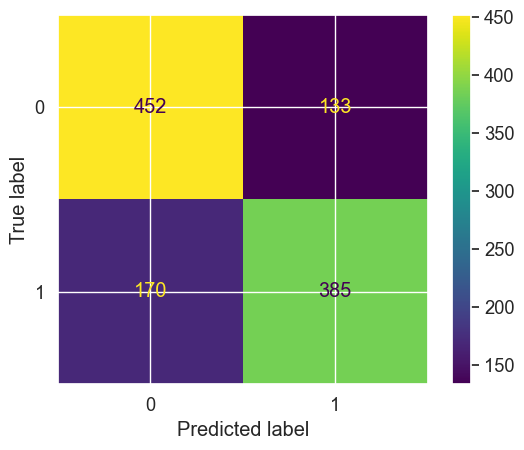

In [3938]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)

In [3939]:
# Calculate precision, recall, f1-score, and support
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       585
           1       0.74      0.69      0.72       555

    accuracy                           0.73      1140
   macro avg       0.73      0.73      0.73      1140
weighted avg       0.73      0.73      0.73      1140



## ROC-AUC

In [3940]:
# Calculate roc-auc
# Need predicted probabilities
test_probas = logreg.predict_proba(X_test)[:,1]

roc_auc_score(y_test, test_probas)

np.float64(0.7673550473550474)

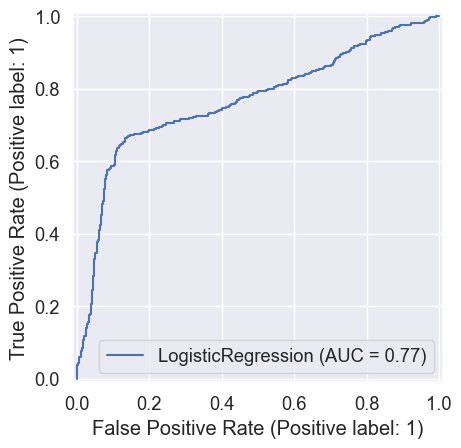

In [3941]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(logreg, X_test, y_test);

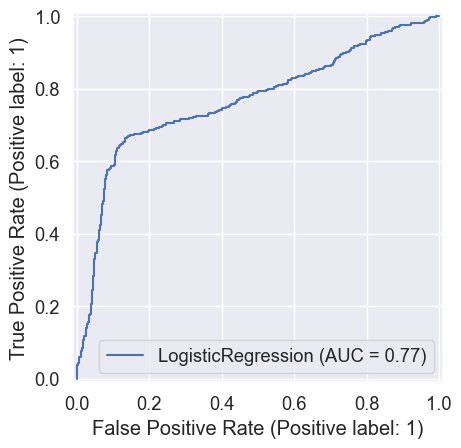

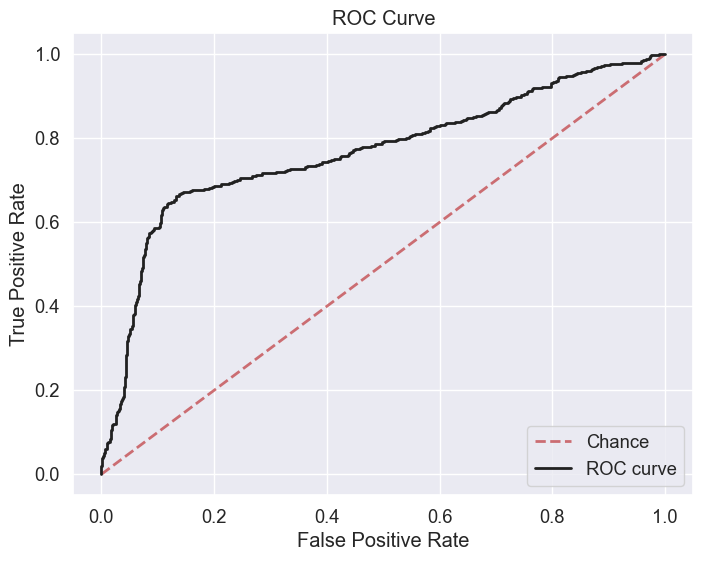

In [3942]:
# Saving transparent for powerpoint presentation

# Assuming X_test and y_test are your test data
# Plot the ROC curve
disp = RocCurveDisplay.from_estimator(logreg, X_test, y_test)

# Customize the plot
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)  # Plot the chance line
plt.plot(disp.fpr, disp.tpr, color='#212121', lw=2, label='ROC curve')  # Plot the ROC curve with custom color
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Save the plot with transparent background
plt.savefig('roc_curve_custom_color.png', transparent=True, bbox_inches='tight')
plt.show()

# Worse Model

The logistic regression is a considerably worse model with our new normalized features. However, these features are much more helpful with regards to developing concrete customer behaviors and patterns that can predict churn without the need for hindsight bias.

Let's see how are other models, Decision Tree and Random Forest, do with these same normalized features.

# Decision Tree - Normalized Features

In [3943]:
# Separate features (X) and target (y)
X = logreg_selects_encoded.drop('churn', axis=1)
y = logreg_selects_encoded['churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the model
dt_classifier.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_classifier.predict(X_test)

# Evaluate model
print("Decision Tree Classifier Performance:")
print(classification_report(y_test, y_pred_dt))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

Decision Tree Classifier Performance:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       566
           1       0.45      0.51      0.48       101

    accuracy                           0.83       667
   macro avg       0.68      0.70      0.69       667
weighted avg       0.84      0.83      0.84       667

Confusion Matrix:
[[502  64]
 [ 49  52]]


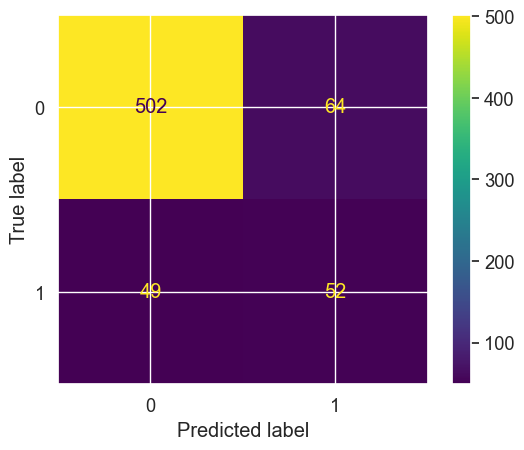

In [3944]:
# Generate confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Display confusion matrix
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=dt_classifier.classes_)
disp_dt.plot()

In [3945]:
# Calculate roc-auc
# Need predicted probabilities
test_probas = dt_classifier.predict_proba(X_test)[:,1]

roc_auc_score(y_test, test_probas)

np.float64(0.7008886401007592)

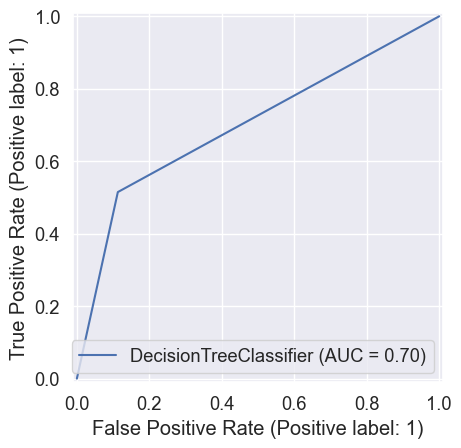

In [3946]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(dt_classifier, X_test, y_test);

# Random Forest - Normalized Features

Random Forest Classifier Performance:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       566
           1       0.73      0.48      0.57       101

    accuracy                           0.89       667
   macro avg       0.82      0.72      0.76       667
weighted avg       0.88      0.89      0.88       667

Confusion Matrix:
[[548  18]
 [ 53  48]]


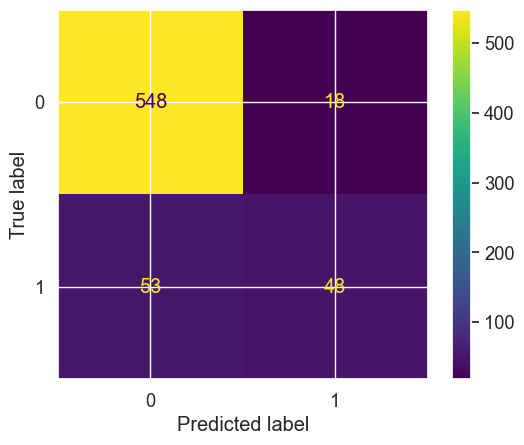

In [3947]:
# Assuming you have split your data and trained the Random Forest model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest model
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the model
rf_classifier.fit(X_train, y_train)

# Predictions on test data
y_pred_rf = rf_classifier.predict(X_test)

# Generate confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Evaluate model
print("Random Forest Classifier Performance:")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Display confusion matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_classifier.classes_)
disp_rf.plot()

In [3948]:
# Calculate roc-auc
# Need predicted probabilities
test_probas = rf_classifier.predict_proba(X_test)[:,1]

roc_auc_score(y_test, test_probas)

np.float64(0.8551324213693454)

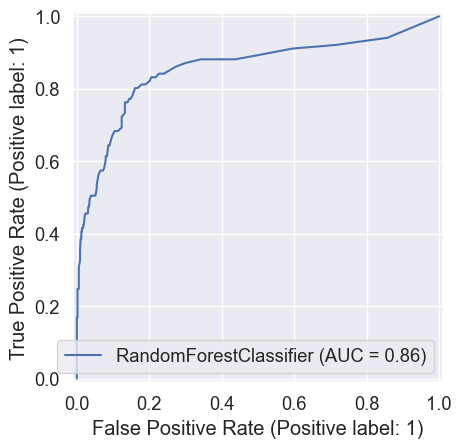

In [3949]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(rf_classifier, X_test, y_test);

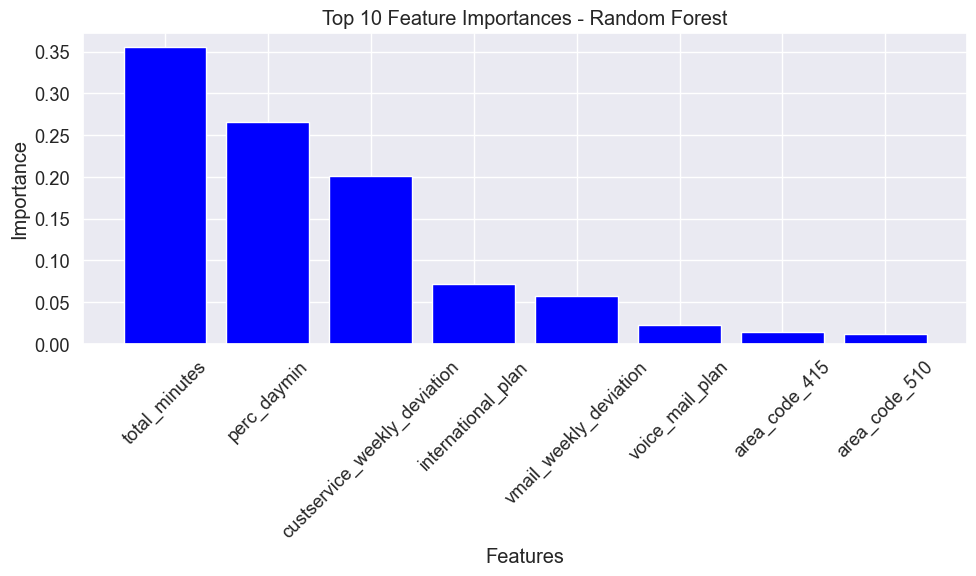

In [3950]:
# Looking at feature importance

importances = rf_classifier.feature_importances_

# Create a DataFrame to display feature importances
feature_importances = pd.DataFrame(importances, index=X.columns, columns=['Importance'])
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importances.index[:10], feature_importances['Importance'].head(10), color='blue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances - Random Forest')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Poor Models - Need Further Tuning

Unfortunately, the models with our normalized features are doing a *way worse* job predicting whether a customer will churn, when comparing their results to our original regression model. 

Let's see what other feature tuning we can possibly explore. Else, we can visit our original non-normalized features, determine which ones have high predictability in relation to churn, then interpret them in "normalized contexts".

### Account Length 

We can try examining whether there are huge differences in the account_length values of churn and no-churn customers...then rather than building a metric of "day calls per day" or "customer service calls per week", we can create a threshold such as "If a customer makes a certain number of customer service calls by day **56** of their contract, they are more likely to churn.

Let's run the numbers below...

In [3951]:
max_account_length_all = df['account_length'].max()
print(f"Max account_length in all rows: {max_account_length_all}")

max_account_length_churned = df.loc[df['churn'] == 1, 'account_length'].max()
print(f"Max account_length where churn is 1: {max_account_length_churned}")

Max account_length in all rows: 243
Max account_length where churn is 1: 225


In [3952]:
mean_account_length_all = df['account_length'].mean()
print(f"Mean account_length in all rows: {mean_account_length_all}")

mean_account_length_nochurn = df.loc[df['churn'] == 0, 'account_length'].mean()
print(f"Mean account_length where churn is 0: {mean_account_length_nochurn}")

mean_account_length_churned = df.loc[df['churn'] == 1, 'account_length'].mean()
print(f"Mean account_length where churn is 1: {mean_account_length_churned}")

Mean account_length in all rows: 101.06480648064806
Mean account_length where churn is 0: 100.79368421052632
Mean account_length where churn is 1: 102.66459627329192


Unfortunately, there seems to be nothing useful for us here. 

## State - Chi-Squared

Let's examine the geographic information provided by the 'states' column in our original dataframe. We can use a **Chi-Square Test of Independence** to determine whether the state in which a customer resides is a valid predictor of churn. If this turns out to be the case, we can find a way to adjust our models with this geographic location in mind.

In [3953]:
# df contains 'state' (categorical) and 'churn' (binary) columns
contingency_table = pd.crosstab(df['state'], df['churn'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

Chi-square statistic: 83.04379191019663
P-value: 0.002296221552011172


The high chi-square value, along with the low p-value (much lower than our alpha of 0.05), concludes there is a **significant relationship between state and churn**. 

Let's *plot the average churn per state* to get a better understanding of which states will be most influential in our model.

state
NJ    0.264706
CA    0.264706
TX    0.250000
MD    0.242857
SC    0.233333
MI    0.219178
MS    0.215385
NV    0.212121
WA    0.212121
ME    0.209677
MT    0.205882
AR    0.200000
KS    0.185714
NY    0.180723
MN    0.178571
PA    0.177778
MA    0.169231
CT    0.162162
NC    0.161765
NH    0.160714
GA    0.148148
DE    0.147541
OK    0.147541
OR    0.141026
UT    0.138889
CO    0.136364
KY    0.135593
SD    0.133333
OH    0.128205
FL    0.126984
IN    0.126761
ID    0.123288
WY    0.116883
MO    0.111111
VT    0.109589
AL    0.100000
NM    0.096774
ND    0.096774
WV    0.094340
TN    0.094340
DC    0.092593
RI    0.092308
WI    0.089744
IL    0.086207
NE    0.081967
LA    0.078431
IA    0.068182
VA    0.064935
AZ    0.062500
AK    0.057692
HI    0.056604
Name: churn, dtype: float64


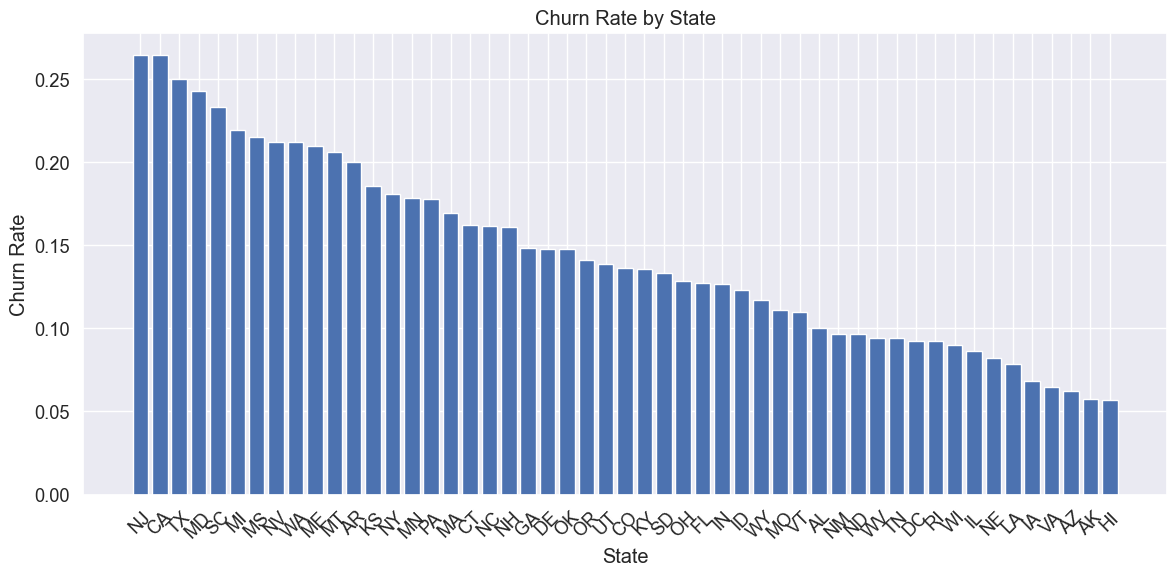

In [3954]:
churn_rate_per_state = df.groupby('state')['churn'].mean().sort_values(ascending=False)
print(churn_rate_per_state)

# Plot churn rates
plt.figure(figsize=(12, 6))
plt.bar(churn_rate_per_state.index, churn_rate_per_state.values)
plt.xticks(rotation=45)
plt.xlabel('State')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by State')
plt.tight_layout()
plt.show()

### Binary Classification for States - High or Low Churn-Rate

One-hot-enconding all of the 51 states represented in our dataset might slow down, and add greater risk of multi-collinearity to our already complex model.


Instead, let's try developing a binary classification system, where we identify whether someone is calling from a state with a **high VS. low churn-rate**. 

We need to determine our threshold for high churn-rate vs. low churn-rate. Let's look at the average churn for our entire dataset, as well as the quantile breakdowns per state.

In [3955]:
# Calculate average churn rate
average_churn_rate = df['churn'].mean()

print(f"Average churn rate: {average_churn_rate}")

Average churn rate: 0.14491449144914492


In [3956]:
# Example: Determine quantiles for thresholding
quantiles = churn_rate_per_state.quantile([0.25, 0.5, 0.75])
print("Quantiles for churn rates:")
print(quantiles)

Quantiles for churn rates:
0.25    0.095557
0.50    0.136364
0.75    0.183219
Name: churn, dtype: float64


We'll actually have *three* classifications for churn rate by state: low (below the 25th percentile), medium (between the 25th percentile and the median), and high (above the median). 

We'll apply this to all of our dataframes we've had at play, for continuity.

Our encoded area_code information does not seem so helpful in hindsight. We'll drop the dataframe logreg_selects_encoded.

In [3957]:
# Calculate churn rate percentiles
quantiles = df.groupby('state')['churn'].mean().quantile([0.25, 0.5, 0.75])

# Define thresholds based on quantiles
low_cr_threshold = quantiles[0.25]
med_cr_threshold = quantiles[0.5]
high_cr_threshold = quantiles[0.75]

# Function to categorize churn rate
def categorize_churn_rate(churn_rate):
    if churn_rate < low_cr_threshold:
        return 'low_cr_state'
    elif churn_rate < med_cr_threshold:
        return 'med_cr_state'
    else:
        return 'high_cr_state'

# Calculate mean churn rate for each state
state_churn_means = df.groupby('state')['churn'].mean()

# Apply categorization function to each state's churn rate
df['churn_category'] = df['state'].map(state_churn_means.apply(categorize_churn_rate))

# Create dummy variables for churn categories
churn_dummies = pd.get_dummies(df['churn_category']).astype(int)

# Concatenate dummies with original dataframe
df = pd.concat([df, churn_dummies], axis=1)

df.head()

state  account_length  area_code  international_plan  voice_mail_plan  \
0    KS             128        415                   0                1   
1    OH             107        415                   0                1   
2    NJ             137        415                   0                0   
3    OH              84        408                   1                0   
4    OK              75        415                   1                0   

   number_vmail_messages  total_day_minutes  total_eve_minutes  \
0                     25              265.1              197.4   
1                     26              161.6              195.5   
2                      0              243.4              121.2   
3                      0              299.4               61.9   
4                      0              166.7              148.3   

   total_night_minutes  total_intl_minutes  customer_service_calls  churn  \
0                244.7                10.0                       1      0   
1                254.4                13.7                       1      0   
2                162.6                12.2                       0      0   
3                196.9                 6.6                       2      0   
4                186.9                10.1                       3      0   

  prefix  total_charge churn_category  high_cr_state  low_cr_state  \
0    382         72.86  high_cr_state              1             0   
1    371         55.54   med_cr_state              0             0   
2    358         59.00  high_cr_state              1             0   
3    375         65.02   med_cr_state              0             0   
4    330         49.36  high_cr_state              1             0   

   med_cr_state  
0             0  
1             1  
2             0  
3             1  
4             0

In [3958]:
# Drop med_cr_state to avoid multicollinearity
df.drop('med_cr_state', axis=1, inplace=True)

In [3959]:
# Merge df with norm_df on their shared index
norm_df = norm_df.merge(df[['high_cr_state', 'low_cr_state']], how='left', left_index=True, right_index=True)

# Merge df with logreg_selects on their shared index
logreg_selects = logreg_selects.merge(df[['high_cr_state', 'low_cr_state']], how='left', left_index=True, right_index=True)

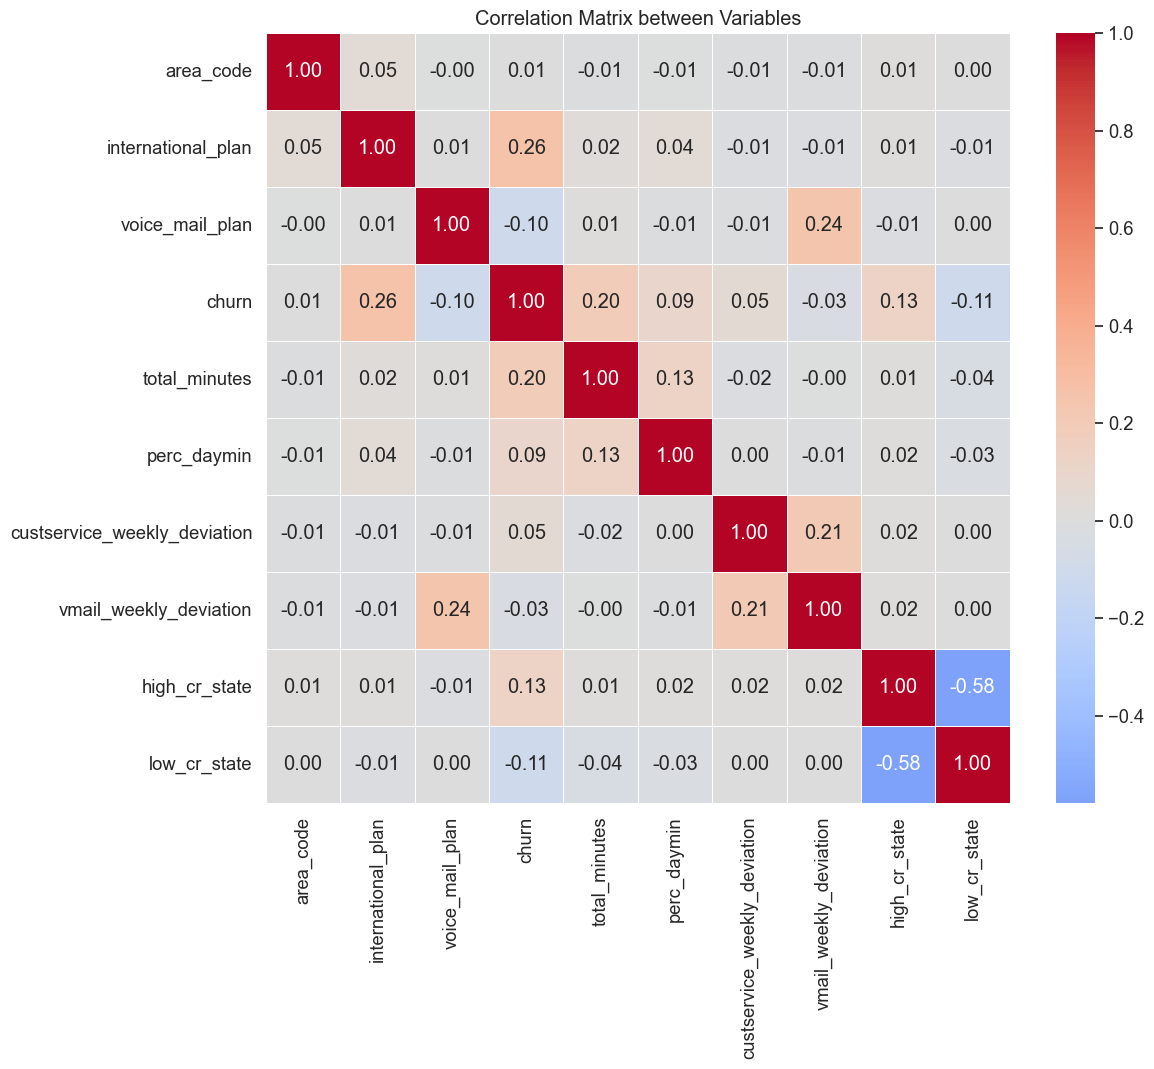

In [3960]:
# Run new correlation matrix
logreg_selects = logreg_selects.select_dtypes(include=['float64','int64'])
# Calculate the correlation matrix
corr_matrix = logreg_selects.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, center=0)
plt.title('Correlation Matrix between Variables')
plt.show();

# Plotting Same Regression Models with States Information

## Logistic Regression

In [3961]:
# Logistic Regression

X = logreg_selects.drop('churn', axis=1)
y = logreg_selects['churn']

# Standard Scaler
numeric_cols = X.columns
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [3962]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Log regression
logreg = LogisticRegression(random_state=42)

In [3963]:
# Finding best parameters using cross validation grid search
logreg = LogisticRegression(random_state=42)
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

y_pred = grid_search.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'C': 1}
Accuracy: 0.7175438596491228
Confusion Matrix:
[[424 161]
 [161 394]]


In [3964]:
# Fit logistic Regression with this C value
# Initialize Logistic Regression model with the best C value
logreg = LogisticRegression(C=0.01, max_iter=1000, random_state=42)

# Fit the model on training data
logreg.fit(X_train, y_train)

# Predict on test data
y_pred = logreg.predict(X_test)

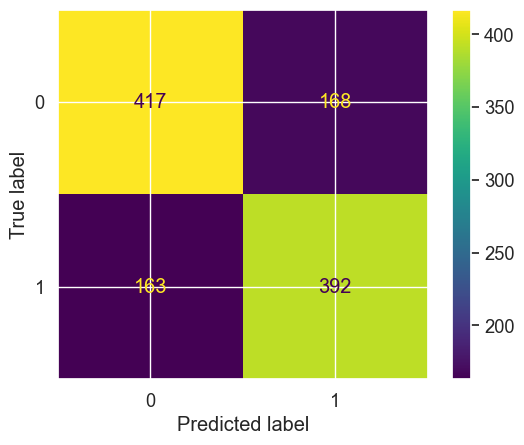

In [3965]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)

In [3966]:
# Calculate precision, recall, f1-score, and support
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.71      0.72       585
           1       0.70      0.71      0.70       555

    accuracy                           0.71      1140
   macro avg       0.71      0.71      0.71      1140
weighted avg       0.71      0.71      0.71      1140

Confusion Matrix:
[[417 168]
 [163 392]]


## ROC-AUC

In [3967]:
# Calculate roc-auc
# Need predicted probabilities
test_probas = logreg.predict_proba(X_test)[:,1]

roc_auc_score(y_test, test_probas)

np.float64(0.7689628089628091)

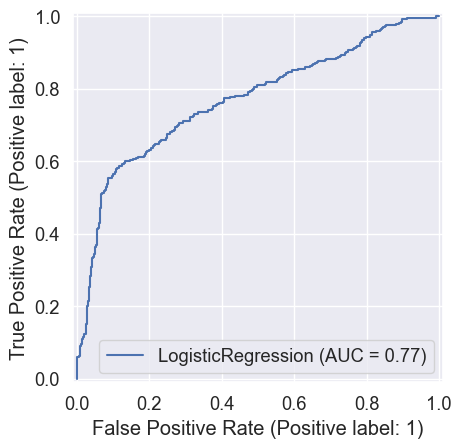

In [3968]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(logreg, X_test, y_test);

## Decision Tree

In [3969]:
# Separate features (X) and target (y)
X = logreg_selects.drop('churn', axis=1)
y = logreg_selects['churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the model
dt_classifier.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_classifier.predict(X_test)

# Evaluate model
print("Decision Tree Classifier Performance:")
print(classification_report(y_test, y_pred_dt))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

Decision Tree Classifier Performance:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       566
           1       0.47      0.55      0.51       101

    accuracy                           0.84       667
   macro avg       0.69      0.72      0.71       667
weighted avg       0.85      0.84      0.84       667

Confusion Matrix:
[[503  63]
 [ 45  56]]


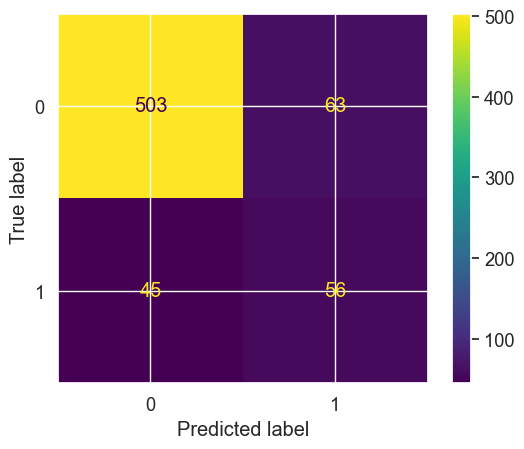

In [3970]:
# Generate confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Display confusion matrix
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=dt_classifier.classes_)
disp_dt.plot()

In [3971]:
# Calculate roc-auc
# Need predicted probabilities
test_probas = dt_classifier.predict_proba(X_test)[:,1]

roc_auc_score(y_test, test_probas)

np.float64(0.7215740125249274)

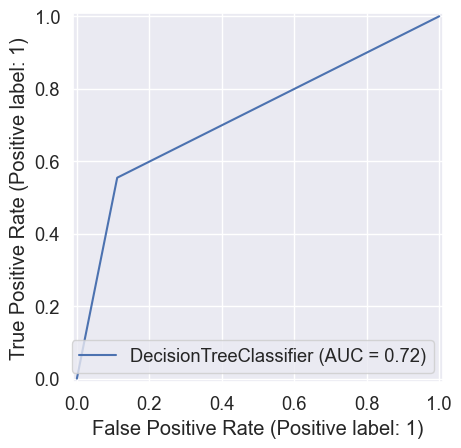

In [3972]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(dt_classifier, X_test, y_test);

## Random Forest

Random Forest Classifier Performance:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       566
           1       0.65      0.51      0.57       101

    accuracy                           0.88       667
   macro avg       0.78      0.73      0.75       667
weighted avg       0.88      0.88      0.88       667

Confusion Matrix:
[[538  28]
 [ 49  52]]


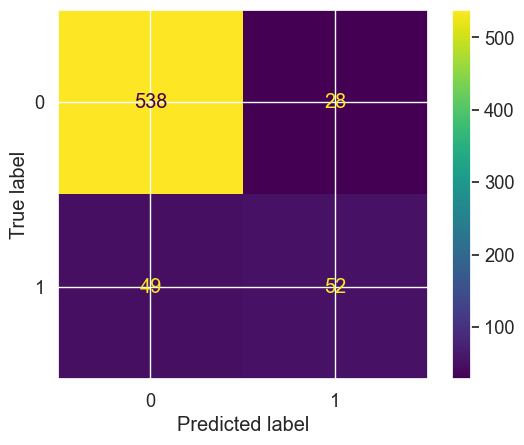

In [3973]:
# Separate features (X) and target (y)
X = logreg_selects.drop('churn', axis=1)
y = logreg_selects['churn']

# Assuming you have split your data and trained the Random Forest model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest model
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the model
rf_classifier.fit(X_train, y_train)

# Predictions on test data
y_pred_rf = rf_classifier.predict(X_test)

# Generate confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Evaluate model
print("Random Forest Classifier Performance:")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Display confusion matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_classifier.classes_)
disp_rf.plot()

In [3974]:
# Calculate roc-auc
# Need predicted probabilities
test_probas = rf_classifier.predict_proba(X_test)[:,1]

roc_auc_score(y_test, test_probas)

np.float64(0.8562169821222404)

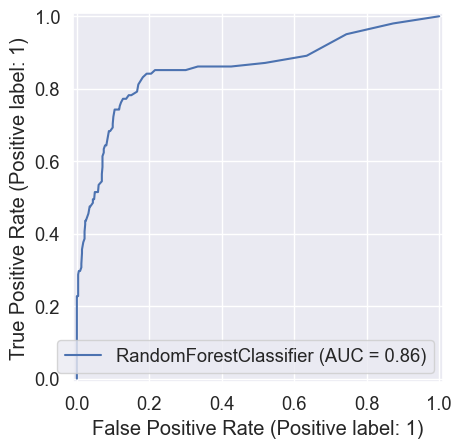

In [3975]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(rf_classifier, X_test, y_test);

Let's look at feature importance using random forest again.

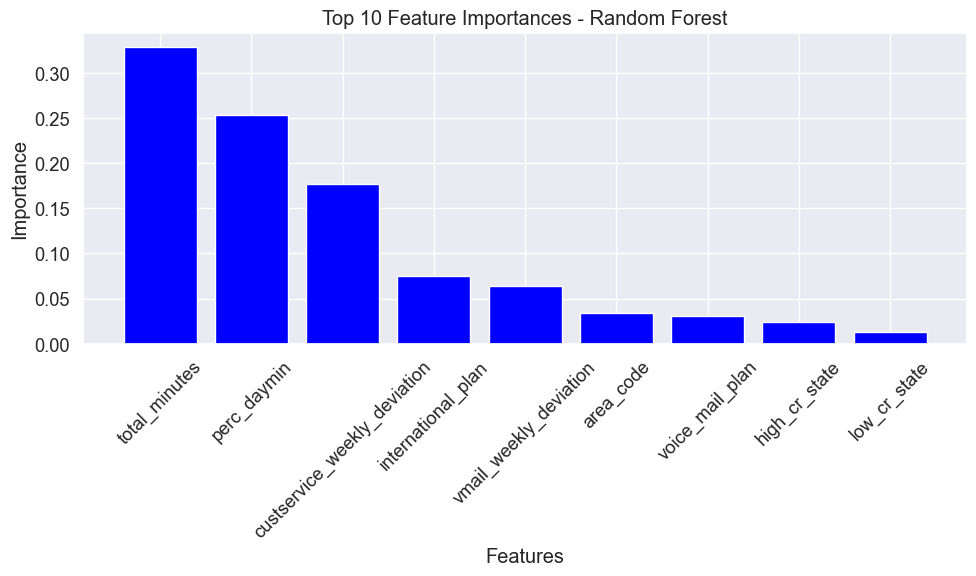

In [3976]:
# Looking at feature importance

importances = rf_classifier.feature_importances_

# Create a DataFrame to display feature importances
feature_importances = pd.DataFrame(importances, index=X.columns, columns=['Importance'])
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importances.index[:10], feature_importances['Importance'].head(10), color='blue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances - Random Forest')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

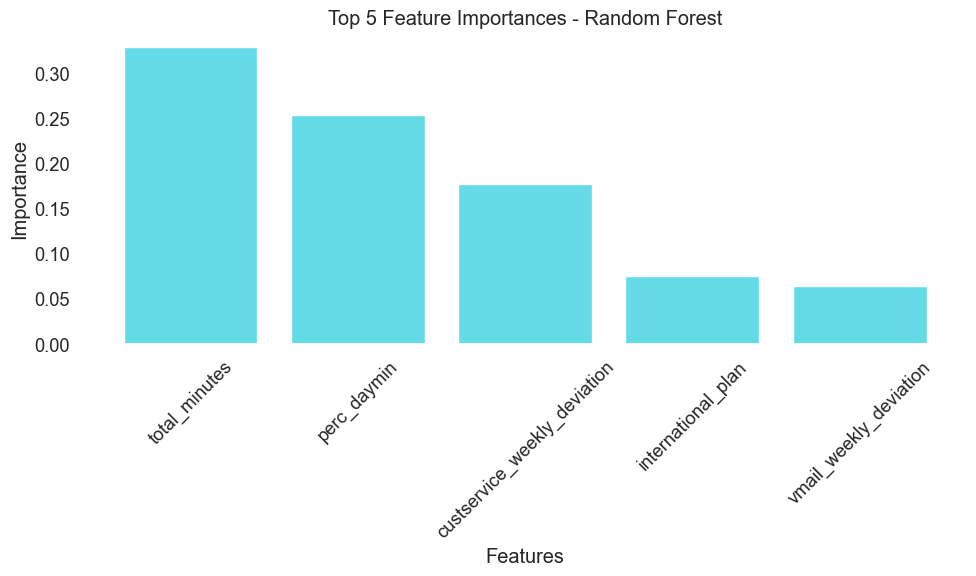

In [3977]:
# Saving for powerpoint

# Looking at feature importance

importances = rf_classifier.feature_importances_

# Create a DataFrame to display feature importances
feature_importances = pd.DataFrame(importances, index=X.columns, columns=['Importance'])
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

custom_color = '#64dbe7'

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importances.index[:5], feature_importances['Importance'].head(5), color=custom_color)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 5 Feature Importances - Random Forest')
plt.xticks(rotation=45)
plt.tight_layout()

# Set spines color to white
ax = plt.gca()
# Set background to be transparent
ax.set_facecolor('none')


# Save the plot with transparent background
plt.savefig('feature_importances.png', transparent=True, bbox_inches='tight')

plt.show()

Let's use cross-validation and regularization to try and see how we can combat overfitting. 

We'll first apply this to our logistic regression model (log_reg) that we just ran.

### Using Ridge, and Cross-Validation

We'll use Ridge (l2), since we are now trying to account for collinearity, rather than further feature selection (which would make lasso for useful).

In [3978]:
# Logistic Regression

X = logreg_selects.drop('churn', axis=1)
y = logreg_selects['churn']

# Standard Scaler
numeric_cols = X.columns
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Create logistic regression model with regularization
logreg = LogisticRegression(penalty='l2', C=0.001, solver='liblinear')

In [3979]:
# Fit the model on the entire dataset
logreg.fit(X_train, y_train)

# Optionally, perform cross-validation to evaluate the model
cv_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='accuracy')  # Adjust cv parameter as needed

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))

Cross-validation scores: [0.66118421 0.69078947 0.67324561 0.70285088 0.68311404]
Mean CV accuracy: 0.6822368421052631


Let's see what correlation med_cr_state (states with a churn-rate between the 25th and 50th percentiles), havce to churn compared with high and low churn-rate states.

In [3980]:
# Add med_cr_state column based on conditions
logreg_selects['med_cr_state'] = 0  # Initialize with 0
logreg_selects.loc[(logreg_selects['high_cr_state'] == 0) & (logreg_selects['low_cr_state'] == 0), 'med_cr_state'] = 1

# Test correlation with churn
correlation = logreg_selects[['med_cr_state', 'churn']].corr().iloc[0, 1]

print("Correlation between med_cr_state and churn:", correlation)

Correlation between med_cr_state and churn: -0.04544745978330434


In [3981]:
logreg_selects['med_cr_state'].value_counts()

med_cr_state
0    2512
1     821
Name: count, dtype: int64

In [3982]:
# Not a strong enough correlation compared to high and low states. Drop again to avoid multicollinearity.
logreg_selects.drop('med_cr_state', axis=1, inplace=True)

# Best Model: Logistic Regression

Among our models, logistic regression is the best at predicting class-1 (churn) outcomes, with these scores:

Precision: 0.62

Recall: 0.69

F-1 score: 0.65

ROC-AUC: 0.726

Our Random Forest model had a higher ROC-AUC score, yet considerably lower scores such as precision and recall when it came to accurately predicting churn. 

Our logistic regressin model still has room for improvement. Let's try one more method of tuning. If we look back at our very first logistic regression model (before we normalized all of the features), 'customer_service_calls' and 'total_day_minutes' both had higher correlations with our target variable 'churn' -- correlations of 0.21.

Since correlation is a hugely helpful metric when running logistic regression, let's try switching one these out for the normalized version of that same feature and see if it helps. We'll do customer_service_calls...it might be helpful to have the 'non-normalized' version...we can interpret this to stakeholders as "once a customer reaches *x* number of customer service calls, they are more likely to churn." Rather than determining the calls per week percentage.

In [3983]:
logreg_selects = logreg_selects.merge(df[['customer_service_calls']], left_index=True, right_index=True)

In [3984]:
# drop other customer service metric to avoid multicollinearity
logreg_selects.drop('custservice_weekly_deviation', axis=1, inplace=True)

In [3985]:
# Run regression

X = logreg_selects.drop('churn', axis=1)
y = logreg_selects['churn']

# Standard Scaler
numeric_cols = X.columns
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [3986]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Log regression
logreg = LogisticRegression(random_state=42)

In [3987]:
# Finding best parameters using cross validation grid search
logreg = LogisticRegression(random_state=42)
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

y_pred = grid_search.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'C': 0.01}
Accuracy: 0.7824561403508772
Confusion Matrix:
[[448 137]
 [111 444]]


In [3988]:
# Fit logistic Regression with this C value
# Initialize Logistic Regression model with the best C value
logreg = LogisticRegression(C=0.1, max_iter=1000, random_state=42)

# Fit the model on training data
logreg.fit(X_train, y_train)

# Predict on test data
y_pred = logreg.predict(X_test)

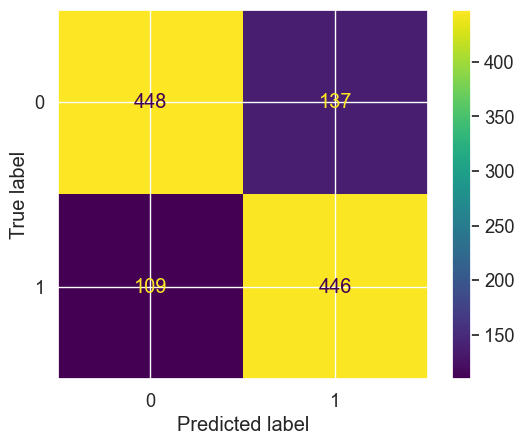

In [3989]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)

In [3990]:
# Calculate precision, recall, f1-score, and support
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.77      0.78       585
           1       0.77      0.80      0.78       555

    accuracy                           0.78      1140
   macro avg       0.78      0.78      0.78      1140
weighted avg       0.79      0.78      0.78      1140

Confusion Matrix:
[[448 137]
 [109 446]]


In [3991]:
# Calculate roc-auc
# Need predicted probabilities
test_probas = logreg.predict_proba(X_test)[:,1]

roc_auc_score(y_test, test_probas)

np.float64(0.8456364056364056)

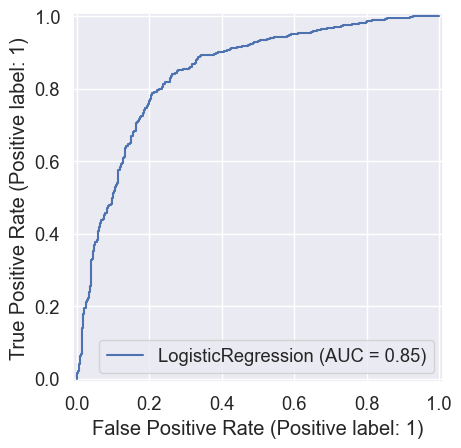

In [3992]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(logreg, X_test, y_test);

This is much better! 

##### NOTE:

We did the same thing with our 'total_day_minutes' column, swapping it for our 'perc_daymin' feature. We figured we could do the same thing regarding interpreting this 'non-normalized' value -- by saying something such as, "Once a customer has logged this many daytime minutes, they are more likely to churn."

**However**, once we did that, we had to drop total_minutes, to avoid multicollinearity...since total_day_minutes is derived from total_minutes.

Once we did this, our scores actually got slightly worse than the test above. Therefore, we'll **keep the model as is above!**

In [3993]:
df.keys()

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_eve_minutes', 'total_night_minutes', 'total_intl_minutes',
       'customer_service_calls', 'churn', 'prefix', 'total_charge',
       'churn_category', 'high_cr_state', 'low_cr_state'],
      dtype='object')

In [3994]:
logreg_selects.keys()

Index(['area_code', 'international_plan', 'voice_mail_plan', 'churn',
       'total_minutes', 'perc_daymin', 'vmail_weekly_deviation',
       'high_cr_state', 'low_cr_state', 'customer_service_calls'],
      dtype='object')

logreg_selects = logreg_selects.merge(df[['total_day_minutes']], left_index=True, right_index=True)

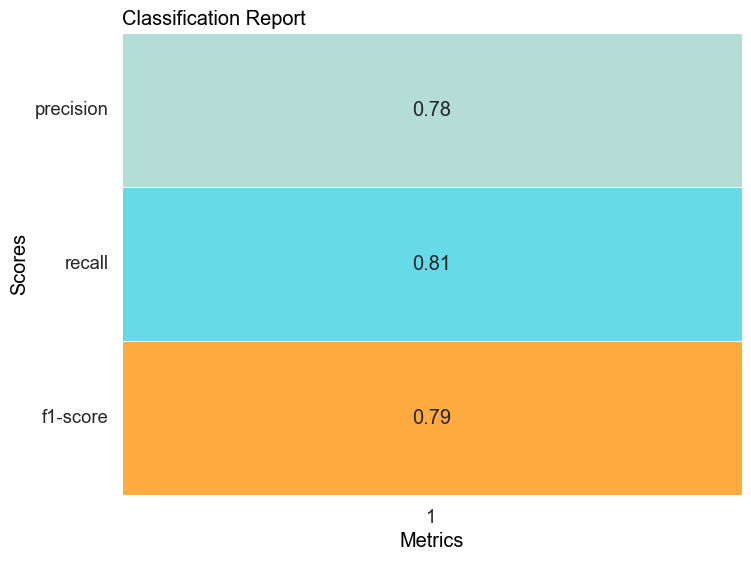

In [3995]:
# Printing heat map for powerpoint presentation

# Example classification report text
classification_report_text = '''
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       585
           1       0.78      0.81      0.79       555

    accuracy                           0.79      1140
   macro avg       0.79      0.79      0.79      1140
weighted avg       0.79      0.79      0.79      1140
'''

# Function to parse classification report
def parse_classification_report(report):
    lines = report.strip().split('\n')
    lines = [line.strip() for line in lines if line.strip()]

    # Initialize dictionary to store metrics
    report_dict = {}

    # Parse each line of the classification report
    for line in lines[2:-3]:  # Exclude header and footer lines
        row = line.split()
        if len(row) < 5:
            continue  # Skip lines that don't contain metrics
        class_name = row[0]
        metrics = [float(val) for val in row[1:]]
        report_dict[class_name] = {
            'precision': metrics[0],
            'recall': metrics[1],
            'f1-score': metrics[2],
            'support': metrics[3]
        }

    return report_dict

# Parse the classification report text
report_dict = parse_classification_report(classification_report_text)

# Convert the report dictionary to a DataFrame for easier plotting
df_report = pd.DataFrame.from_dict(report_dict, orient='index')

# Remove 'macro avg' and 'weighted avg' from the DataFrame
df_report = df_report.drop(['macro avg', 'weighted avg'], errors='ignore')

# Plotting the classification report heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

# Define custom colors
custom_colors = ['#b4ddd6', '#ffab40', '#64dbe7']

# Create heatmap with custom colors
ax = sns.heatmap(df_report[['precision', 'recall', 'f1-score']].T,
                 annot=True,
                 cmap=sns.color_palette(custom_colors),
                 cbar=False,
                 linewidths=.5)

# Set title and labels with black text
ax.set_title('Classification Report', loc='left', color='black')
ax.set_xlabel('Metrics', color='black')
ax.set_ylabel('Scores', color='black')

# Rotate yticks to horizontal
plt.yticks(rotation=0)

# Save the plot with transparent background
plt.savefig('classification_report_updated.png', transparent=True, bbox_inches='tight')
plt.show()

In [3996]:
# Calculate roc-auc
# Need predicted probabilities
test_probas = logreg.predict_proba(X_test)[:,1]

roc_auc_score(y_test, test_probas)

np.float64(0.8456364056364056)

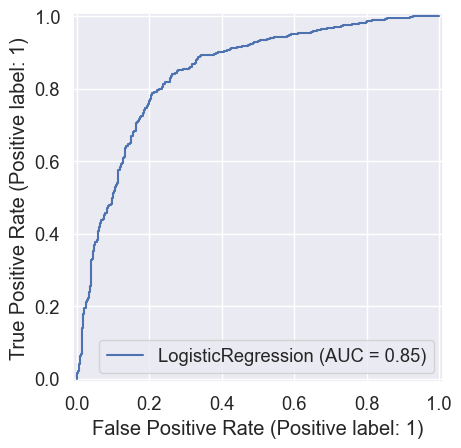

In [3997]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(logreg, X_test, y_test);

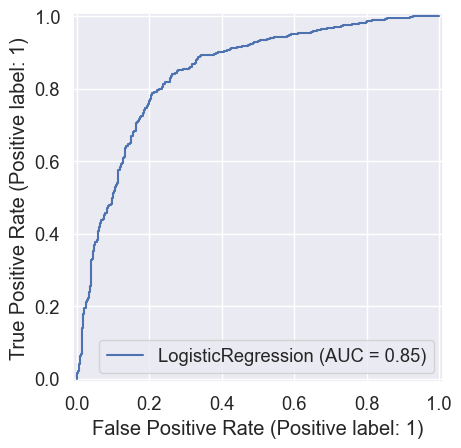

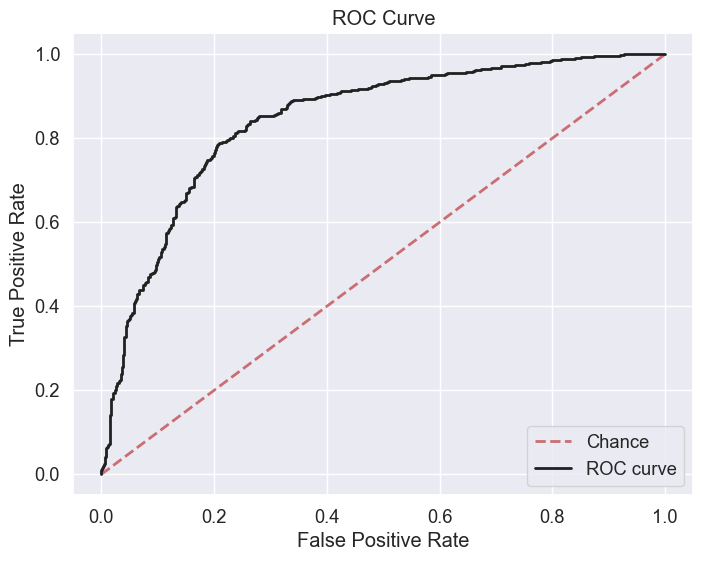

In [3998]:
# Saving transparent for powerpoint presentation

# Assuming X_test and y_test are your test data
# Plot the ROC curve
disp = RocCurveDisplay.from_estimator(logreg, X_test, y_test)

# Customize the plot
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)  # Plot the chance line
plt.plot(disp.fpr, disp.tpr, color='#212121', lw=2, label='ROC curve')  # Plot the ROC curve with custom color
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Save the plot with transparent background
plt.savefig('roc_curve_custom_color.png', transparent=True, bbox_inches='tight')
plt.show()

# OFFICIAL MODEL SELECTION: Logistic Regression

The regression above is our best model! In order to fully understand why this model runs as well as it does, and make informed suggestions to stakeholders...let's examine the features that went into making a model that accurately predicts customer churn.

We can print the coefficients, and plot them for all of our features.

In [3999]:
# Get coefficients and their corresponding feature names
coefficients = logreg.coef_[0]
feature_names = X_train.columns

# Create a DataFrame to display coefficients
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': abs(coefficients)  # Absolute value for magnitude comparison
})

# Sort by absolute coefficient value to see most influential features
importance_df = importance_df.sort_values(by='Abs_Coefficient', ascending=False)

print(importance_df)

                  Feature  Coefficient  Abs_Coefficient
8  customer_service_calls     0.772330         0.772330
3           total_minutes     0.762390         0.762390
1      international_plan     0.682616         0.682616
2         voice_mail_plan    -0.363850         0.363850
6           high_cr_state     0.353306         0.353306
4             perc_daymin     0.259314         0.259314
7            low_cr_state    -0.151205         0.151205
5  vmail_weekly_deviation    -0.141662         0.141662
0               area_code     0.012345         0.012345


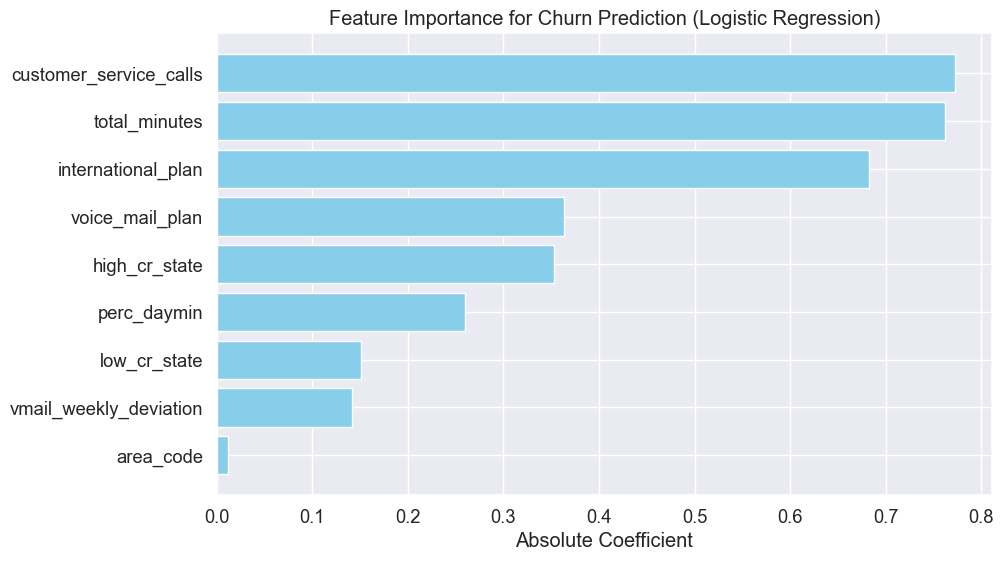

In [4000]:
# Plot feature importance based on logistic regression
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Abs_Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient')
plt.title('Feature Importance for Churn Prediction (Logistic Regression)')
plt.gca().invert_yaxis()  # Invert y-axis to display most important features on top
plt.show()

### Interpreting State Columns

Let's make plots of what states belong to our high, medium, and low churn-rates. To have a better understanding when presenting to our stakeholders.

#### High Churn-Rate States

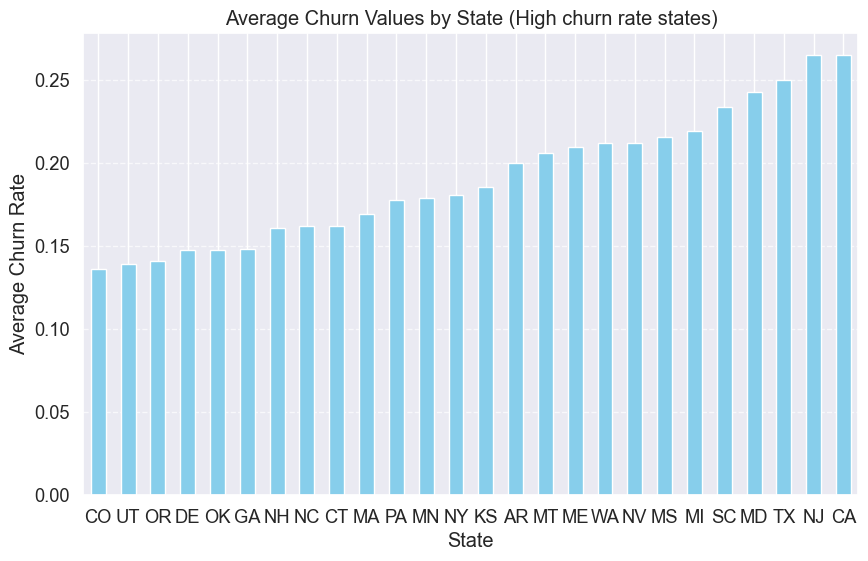

In [4001]:
# Filter rows where high_cr_state is equal to 1
df_filtered = df[df['high_cr_state'] == 1]

# Group by 'state' and calculate average churn rate
avg_churn_by_state = df_filtered.groupby('state')['churn'].mean()

# Sort average churn rates in ascending order
avg_churn_by_state_high_sorted = avg_churn_by_state.sort_values()

# Plotting
plt.figure(figsize=(10, 6))
avg_churn_by_state_high_sorted.plot(kind='bar', color='skyblue')
plt.title('Average Churn Values by State (High churn rate states)')
plt.xlabel('State')
plt.ylabel('Average Churn Rate')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Medium Churn-Rate States

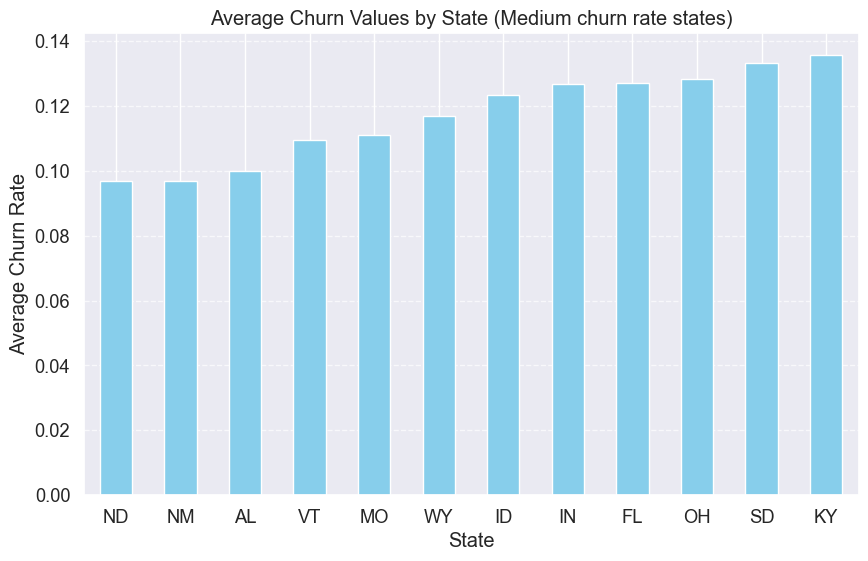

In [4002]:
# Add med_cr_state column back into dataframe
df['med_cr_state'] = 0  # Initialize with 0
df.loc[(df['high_cr_state'] == 0) & (df['low_cr_state'] == 0), 'med_cr_state'] = 1

# Filter rows where med_cr_state is equal to 1
df_med_cr_state = df[df['med_cr_state'] == 1]

# Group by 'state' and calculate average churn rate
avg_churn_by_state_med = df_med_cr_state.groupby('state')['churn'].mean()

# Sort average churn rates in ascending order
avg_churn_by_state_med_sorted = avg_churn_by_state_med.sort_values()

# Plotting for med_cr_state
plt.figure(figsize=(10, 6))
avg_churn_by_state_med_sorted.plot(kind='bar', color='skyblue')
plt.title('Average Churn Values by State (Medium churn rate states)')
plt.xlabel('State')
plt.ylabel('Average Churn Rate')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Low Churn Rate States

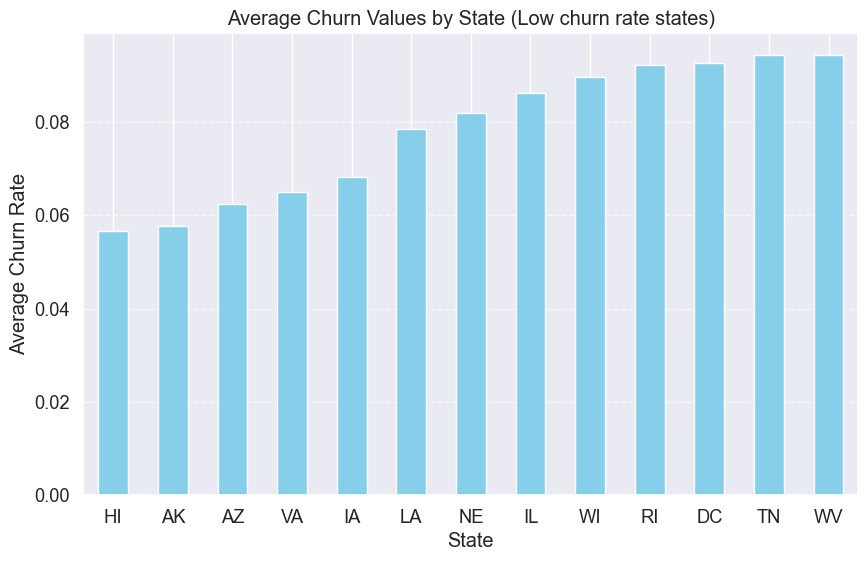

In [4003]:
# Filter rows where low_cr_state is equal to 1
df_low_cr_state = df[df['low_cr_state'] == 1]

# Group by 'state' and calculate average churn rate
avg_churn_by_state_low = df_low_cr_state.groupby('state')['churn'].mean()

# Sort average churn rates in ascending order
avg_churn_by_state_low_sorted = avg_churn_by_state_low.sort_values()

# Plotting for low_cr_state
plt.figure(figsize=(10, 6))
avg_churn_by_state_low_sorted.plot(kind='bar', color='skyblue')
plt.title('Average Churn Values by State (Low churn rate states)')
plt.xlabel('State')
plt.ylabel('Average Churn Rate')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Extreme High-Churn Rate

Our high-churn rate has a larger number of states, because it's everything above the 50th quantile (the median). Let's narrow our focus to the states with extreme high churn-rate averages (about the 75th percentile).

In [4004]:
# Adding Extreme High-Churn Rate
# Calculate mean churn rate for each state
state_churn_means = df.groupby('state')['churn'].mean()

# Calculate churn rate percentiles
quantiles = state_churn_means.quantile([0.25, 0.5, 0.75])

# Define threshold based on 75th quantile
high_cr_threshold = quantiles[0.75]

# Function to categorize churn rate
def categorize_churn_rate(churn_rate):
    if churn_rate > high_cr_threshold:
        return 1
    else:
        return 0

# Apply categorization function to each state's churn rate
df['extreme_high_cr_state'] = df['state'].map(state_churn_means.apply(categorize_churn_rate))

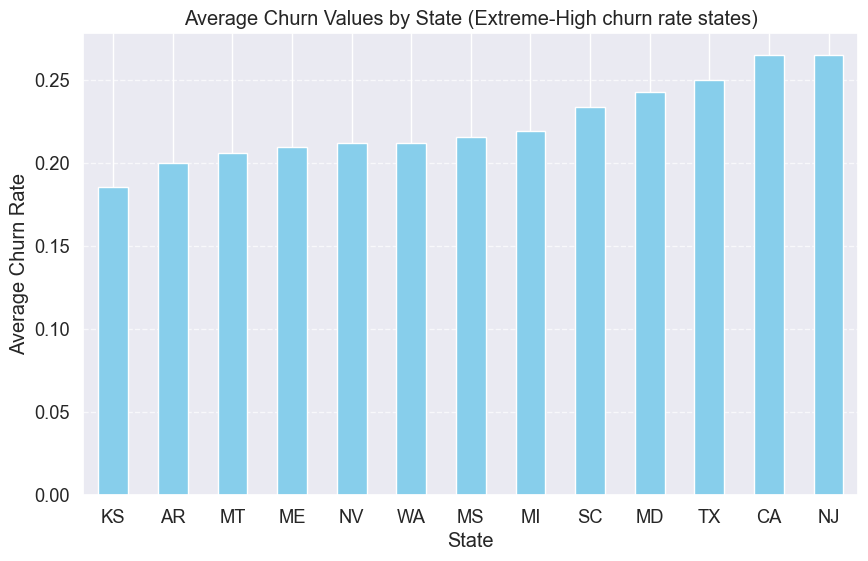

In [4005]:
# Plot these states
# Filter rows where high_cr_state is equal to 1
df_filtered = df[df['extreme_high_cr_state'] == 1]

# Group by 'state' and calculate average churn rate
avg_churn_by_state = df_filtered.groupby('state')['churn'].mean()

# Sort average churn rates in ascending order
avg_churn_by_state_exthigh_sorted = avg_churn_by_state.sort_values()

# Plotting
plt.figure(figsize=(10, 6))
avg_churn_by_state_exthigh_sorted.plot(kind='bar', color='skyblue')
plt.title('Average Churn Values by State (Extreme-High churn rate states)')
plt.xlabel('State')
plt.ylabel('Average Churn Rate')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Plot Average Daytime Calltime per Extreme-High Churn Rate State

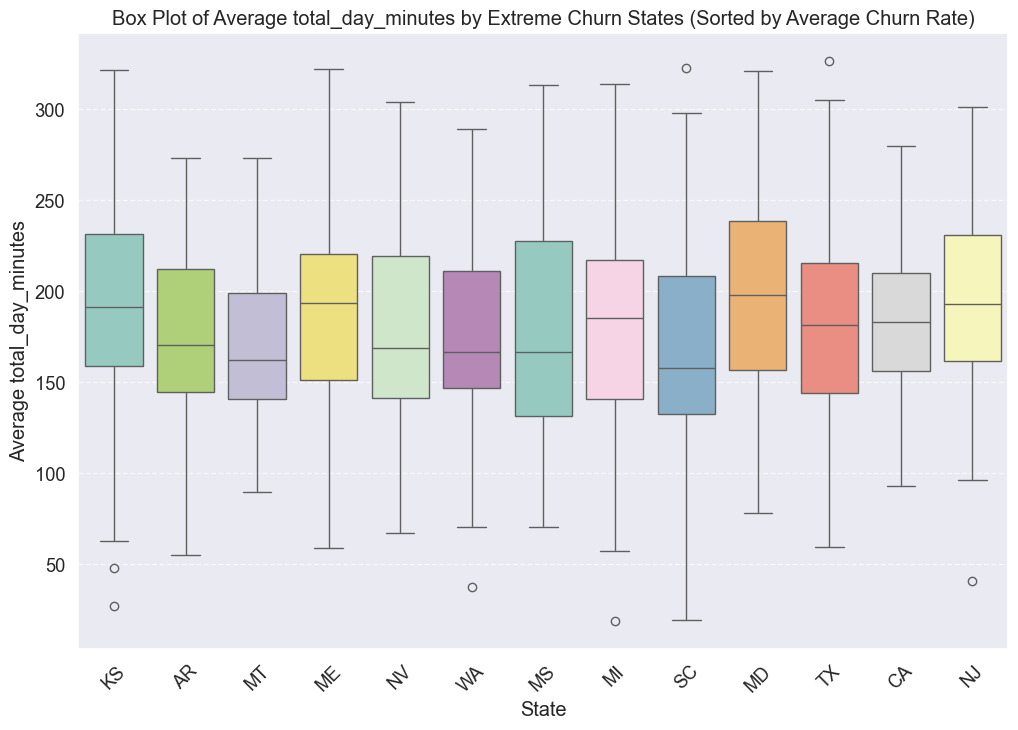

In [4006]:
# Calculate average churn rate for each state
avg_churn_by_state = df_filtered.groupby('state')['churn'].mean().sort_values()

# Plotting box plots in sorted order
plt.figure(figsize=(12, 8))
sns.boxplot(x='state', y='total_day_minutes', data=df_filtered, order=avg_churn_by_state.index, palette='Set3', hue='state', legend=False)
plt.title('Box Plot of Average total_day_minutes by Extreme Churn States (Sorted by Average Churn Rate)')
plt.xlabel('State')
plt.ylabel('Average total_day_minutes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

##### Also plot average customer service calls

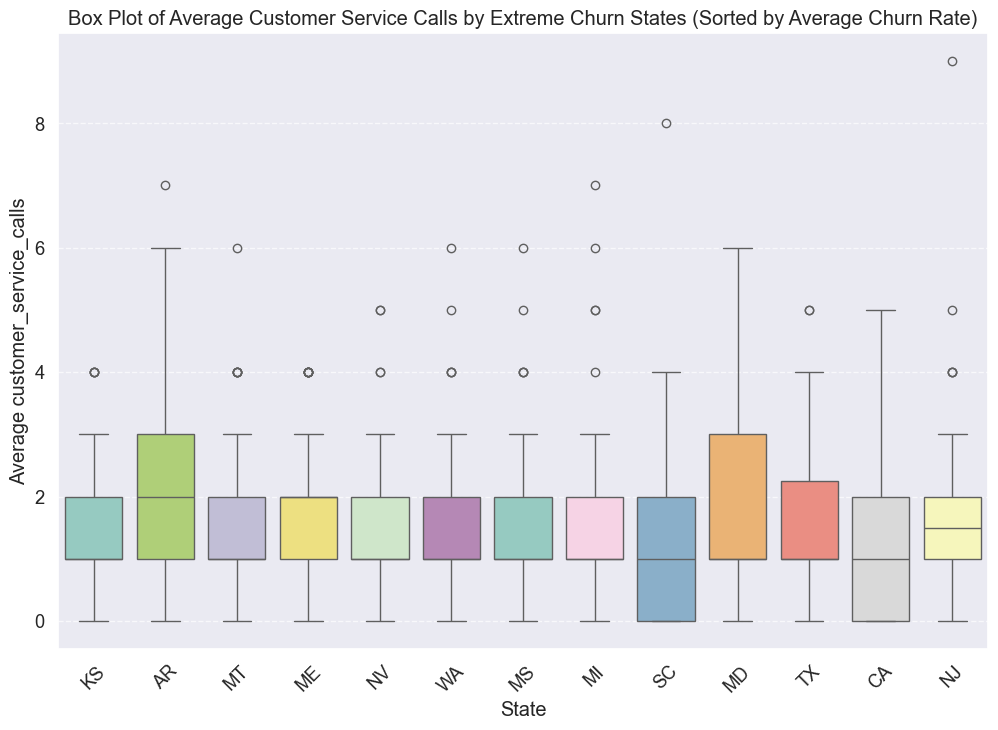

In [4007]:
# Calculate average churn rate for each state
avg_churn_by_state = df_filtered.groupby('state')['churn'].mean().sort_values()

# Plotting box plots in sorted order
plt.figure(figsize=(12, 8))
sns.boxplot(x='state', y='customer_service_calls', data=df_filtered, order=avg_churn_by_state.index, palette='Set3', hue='state', legend=False)
plt.title('Box Plot of Average Customer Service Calls by Extreme Churn States (Sorted by Average Churn Rate)')
plt.xlabel('State')
plt.ylabel('Average customer_service_calls')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

#### Plot the same for Low Churn States

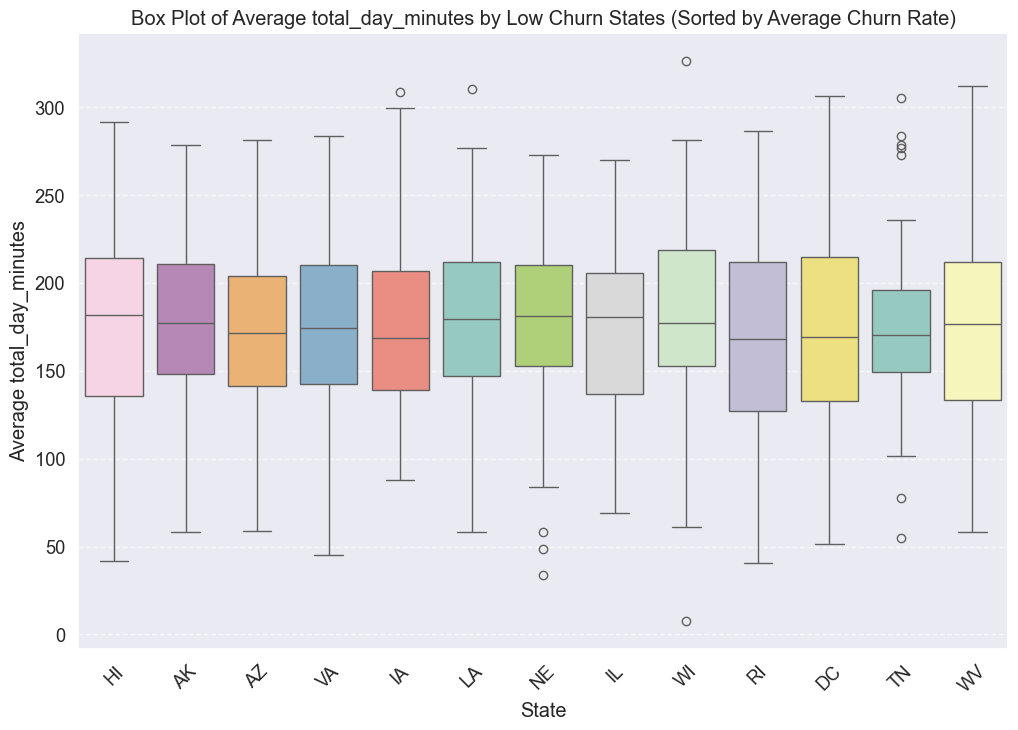

In [4008]:
# Filter rows where low_cr_state is equal to 1
df_low_cr_state = df[df['low_cr_state'] == 1]

# Group by 'state' and calculate average churn rate
avg_churn_by_state_low = df_low_cr_state.groupby('state')['churn'].mean().sort_values()

# Plotting box plots in sorted order
plt.figure(figsize=(12, 8))
sns.boxplot(x='state', y='total_day_minutes', data=df_low_cr_state, order=avg_churn_by_state_low.index, palette='Set3', hue='state', legend=False)
plt.title('Box Plot of Average total_day_minutes by Low Churn States (Sorted by Average Churn Rate)')
plt.xlabel('State')
plt.ylabel('Average total_day_minutes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

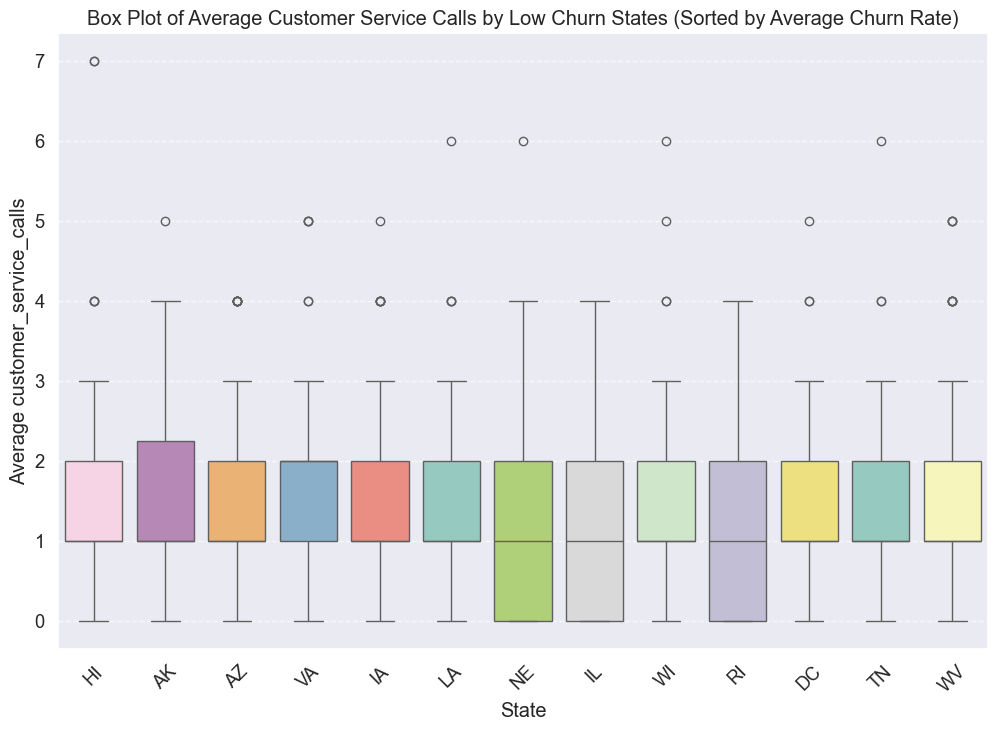

In [4009]:
# Filter rows where low_cr_state is equal to 1
df_low_cr_state = df[df['low_cr_state'] == 1]

# Group by 'state' and calculate average churn rate
avg_churn_by_state_low = df_low_cr_state.groupby('state')['churn'].mean().sort_values()

# Plotting box plots in sorted order
plt.figure(figsize=(12, 8))
sns.boxplot(x='state', y='customer_service_calls', data=df_low_cr_state, order=avg_churn_by_state_low.index, palette='Set3', hue='state', legend=False)
plt.title('Box Plot of Average Customer Service Calls by Low Churn States (Sorted by Average Churn Rate)')
plt.xlabel('State')
plt.ylabel('Average customer_service_calls')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

#### Using original dataframe to contextualize predictive variables.

Let's see if any of the keys in our original dataframe, df, can help us better understand our selected features in our model

In [4010]:
df.keys()

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_eve_minutes', 'total_night_minutes', 'total_intl_minutes',
       'customer_service_calls', 'churn', 'prefix', 'total_charge',
       'churn_category', 'high_cr_state', 'low_cr_state', 'med_cr_state',
       'extreme_high_cr_state'],
      dtype='object')

In [4011]:
logreg_selects.keys()

Index(['area_code', 'international_plan', 'voice_mail_plan', 'churn',
       'total_minutes', 'perc_daymin', 'vmail_weekly_deviation',
       'high_cr_state', 'low_cr_state', 'customer_service_calls'],
      dtype='object')

In [4012]:
keys

{'area_codes': {415: 'San Francisco, CA',
  510: 'East Bay cities, Northern CA',
  408: 'San Jose, CA'},
 'ppm': {'day_ppm': 0.17,
  'eve_ppm': 0.085,
  'night_ppm': 0.045,
  'intl_ppm': 0.27}}

#### Prefix

Let's revisit a phone's prefix, and see if there's any meaningful information there. We can run a chi-squared test like we did to determine the relevancy of 'state' values with regards to predicting churn.

In [4013]:
# df contains 'state' (categorical) and 'churn' (binary) columns
contingency_table = pd.crosstab(df['prefix'], df['churn'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

Chi-square statistic: 85.65522068582706
P-value: 0.7430389045455594


Nope! Way too high of a p-value to reject null hypothesis. Moving on!

### International Plan

We know whether or not a person purchased the 'international_plan' is highly correlated to whether they churn. Let's examine what this means a little more...can a person only make international calls when they have an international_plan? If not, is there a difference in the charges made to a call?

In [4014]:
df['international_plan'].value_counts()

international_plan
0    3010
1     323
Name: count, dtype: int64

In [4015]:
# Filter rows with no international plan
filtered_df = df[df['international_plan'] == 0]

# Calculate value counts for total_intl_minutes, checking if they had the ability to make intl calls
value_counts = filtered_df['total_intl_minutes'].value_counts()

print("Value counts for total_intl_minutes where international_plan == 0:")
print(value_counts)

Value counts for total_intl_minutes where international_plan == 0:
total_intl_minutes
10.0    55
11.3    54
9.8     53
10.2    53
10.6    51
        ..
18.9     1
18.4     1
2.7      1
2.2      1
2.5      1
Name: count, Length: 159, dtype: int64


Hm...Let's calculate the average total_intl_charge per minute for people who did and did not purchase an international plan.

In [4016]:
df_copy.keys()

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn', 'prefix', 'total_minutes',
       'total_charge'],
      dtype='object')

In [4017]:
# Assign 'total_intl_charge' from df_copy to df
df['total_intl_charge'] = df_copy['total_intl_charge']

In [4018]:
df['intl_minute_cost'] = df['total_intl_charge'] / df['total_intl_minutes']

In [4019]:
# Filter rows with no international plan
no_intlplan = df[df['international_plan'] == 0]

# Same with intl plan
intlplan = df[df['international_plan'] == 1]

In [4020]:
# Print both
print("Breakdown of cost per minute for customers with no international plan:")
no_intlplan['intl_minute_cost'].describe()

Breakdown of cost per minute for customers with no international plan:


count    2992.000000
mean        0.270059
std         0.000332
min         0.268182
25%         0.269811
50%         0.270000
75%         0.270297
max         0.272727
Name: intl_minute_cost, dtype: float64

In [4021]:
print("Breakdown of cost per minute for customers with international plan:")
intlplan['intl_minute_cost'].describe()

Breakdown of cost per minute for customers with international plan:


count    323.000000
mean       0.270038
std        0.000300
min        0.269231
25%        0.269801
50%        0.270000
75%        0.270259
max        0.271429
Name: intl_minute_cost, dtype: float64

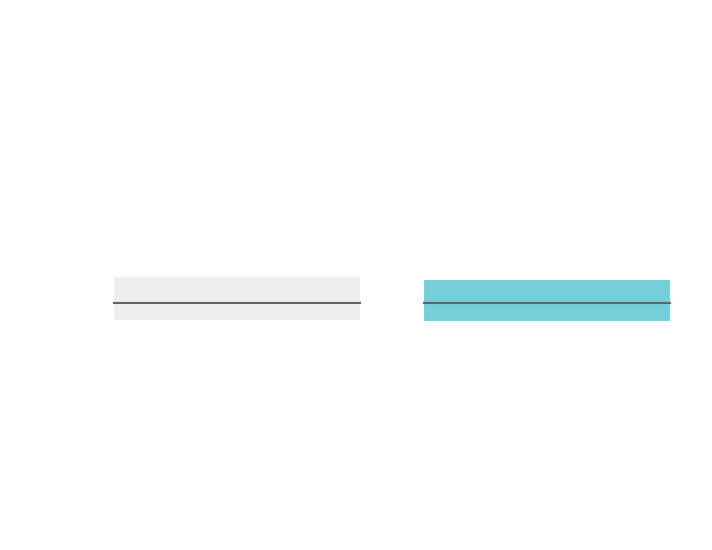

In [4058]:
# Printing for presentation

# Define custom colors
custom_color_1 = '#64dbe7'
custom_color_2 = '#eeeeee'

# Concatenate data with 'intlplan' as hue
combined_data = pd.concat([
    no_intlplan.assign(intlplan='No'),
    intlplan.assign(intlplan='Yes')
])

# Plotting the box plots with custom colors
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid", rc={"axes.edgecolor": "white"})  # Set edge color of axis to white
sns.boxplot(x='intlplan', y='intl_minute_cost', hue='intlplan', data=combined_data,
            palette={'Yes': custom_color_1, 'No': custom_color_2}, dodge=False,
            linewidth=1.5, boxprops=dict(edgecolor='white', linewidth=1.5),
            flierprops=dict(marker='o', markerfacecolor='white', markeredgecolor='white', markersize=8, linestyle='none'),
            whiskerprops=dict(color='white', linewidth=1.5), capprops=dict(color='white', linewidth=1.5))

# Set plot title and labels with white text
plt.title("Cost per Minute by International Plan", color='white')
plt.xlabel("International Plan", color='white')
plt.ylabel("Intl Minute Cost", color='white')

# Set ticks color to white
plt.xticks(color='white')
plt.yticks(color='white')

# Set grid color to white (with alpha for transparency)
plt.grid(color='white', alpha=0.2)

# Save the plot with transparent background
plt.savefig('intl_minute_cost_boxplot.png', transparent=True, bbox_inches='tight')
plt.show()

### No difference in intl call cost between plan and non-plan customers

It looks like there's no price reduction on international calls for customers who purchased an international plan! No wonder they were more likely to churn! 

What could this plan possibly provide? Maybe a greater number of intl calls, and/or a greater length (per minute) of intl calls that can be made? Let's check. 

In [4022]:
# Print both
print("Breakdown of call-time for customers with no international plan:")
no_intlplan['total_intl_minutes'].describe()

Breakdown of call-time for customers with no international plan:


count    3010.000000
mean       10.195349
std         2.798937
min         0.000000
25%         8.400000
50%        10.200000
75%        12.100000
max        18.900000
Name: total_intl_minutes, dtype: float64

In [4023]:
print("Breakdown of call-time for customers with international plan:")
intlplan['total_intl_minutes'].describe()

Breakdown of call-time for customers with international plan:


count    323.000000
mean      10.628173
std        2.697787
min        1.300000
25%        9.000000
50%       10.800000
75%       12.200000
max       20.000000
Name: total_intl_minutes, dtype: float64

In [4024]:
# Adding 'total_intl_calls' from df_copy to df
df['total_intl_calls'] = df_copy['total_intl_calls']

# Restablish filtered dataframes
# Filter rows with no international plan
no_intlplan = df[df['international_plan'] == 0]

# Same with intl plan
intlplan = df[df['international_plan'] == 1]

In [4025]:
# Print both
print("Breakdown of # of calls for customers with no international plan:")
no_intlplan['total_intl_calls'].describe()

Breakdown of # of calls for customers with no international plan:


count    3010.000000
mean        4.465449
std         2.442486
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        19.000000
Name: total_intl_calls, dtype: float64

In [4026]:
print("Breakdown of # of calls for customers with international plan:")
intlplan['total_intl_calls'].describe()

Breakdown of # of calls for customers with international plan:


count    323.000000
mean       4.609907
std        2.629768
min        1.000000
25%        3.000000
50%        4.000000
75%        6.000000
max       20.000000
Name: total_intl_calls, dtype: float64

This international plan really does not seem to provide any benefits, as far as we can see. The average number, length, and cost of international calls made is around the same for both international_plan subscribers, and non-subscribers.

### Voicemail Plan

Subscription to the voicemail plan actually had a *negative* correlation and coefficient with regards to predicting churn. Let's run similar tests, to determine what benefits this provide.

With voice_mail_plan, we can check whether or not customers seemed able to leave more or less voicemails.

In [4027]:
# Filter rows with no international plan
no_vmailplan = df[df['voice_mail_plan'] == 0]

# Same with intl plan
vmailplan = df[df['voice_mail_plan'] == 1]

In [4028]:
# Print both
print("Breakdown of # of voicemails for customers with no voicemail plan:")
no_vmailplan['number_vmail_messages'].describe()

Breakdown of # of voicemails for customers with no voicemail plan:


count    2411.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: number_vmail_messages, dtype: float64

In [4029]:
# Print both
print("Breakdown of # of voicemails for customers with voicemail plan:")
vmailplan['number_vmail_messages'].describe()

Breakdown of # of voicemails for customers with voicemail plan:


count    922.000000
mean      29.277657
std        7.559027
min        4.000000
25%       24.000000
50%       29.000000
75%       34.000000
max       51.000000
Name: number_vmail_messages, dtype: float64

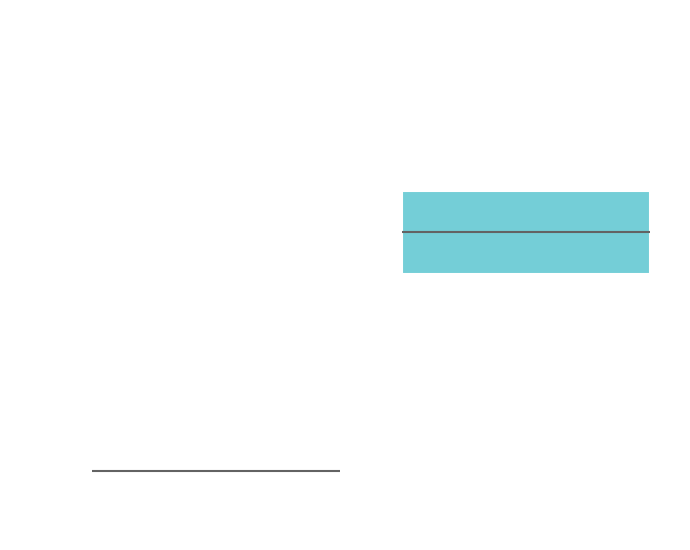

In [4059]:
# Printing for presentation

# Define custom colors
custom_color_1 = '#64dbe7'
custom_color_2 = '#eeeeee'

# Concatenate data with 'intlplan' as hue
combined_data = pd.concat([
    no_vmailplan.assign(vmailplan='No'),
    vmailplan.assign(vmailplan='Yes')
])

# Plotting the box plots with custom colors
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid", rc={"axes.edgecolor": "white"})  # Set edge color of axis to white
sns.boxplot(x='vmailplan', y='number_vmail_messages', hue='vmailplan', data=combined_data,
            palette={'Yes': custom_color_1, 'No': custom_color_2}, dodge=False,
            linewidth=1.5, boxprops=dict(edgecolor='white', linewidth=1.5),
            flierprops=dict(marker='o', markerfacecolor='white', markeredgecolor='white', markersize=8, linestyle='none'),
            whiskerprops=dict(color='white', linewidth=1.5), capprops=dict(color='white', linewidth=1.5))

# Set plot title and labels with white text
plt.title("Number Voicemails by Voicemail-Plan", color='white')
plt.xlabel("Voicemail Plan", color='white')
plt.ylabel("Number Voicemails", color='white')

# Set ticks color to white
plt.xticks(color='white')
plt.yticks(color='white')

# Set grid color to white (with alpha for transparency)
plt.grid(color='white', alpha=0.2)

# Save the plot with transparent background
plt.savefig('num_vmails_boxplot.png', transparent=True, bbox_inches='tight')
plt.show()

This plan seems a lot more intuitive. There are clear benefits to a subscription to a voicemail plan (AKA the ability to leave voicemails). Gaining true benefits would reasonably lead to lowered churn rates.

Knowing this, we can probably drop 'vmail_weekly_deviation' as a feature in our future logistic regression models.

In [4030]:
logreg_selects.drop('vmail_weekly_deviation', axis=1, inplace=True)

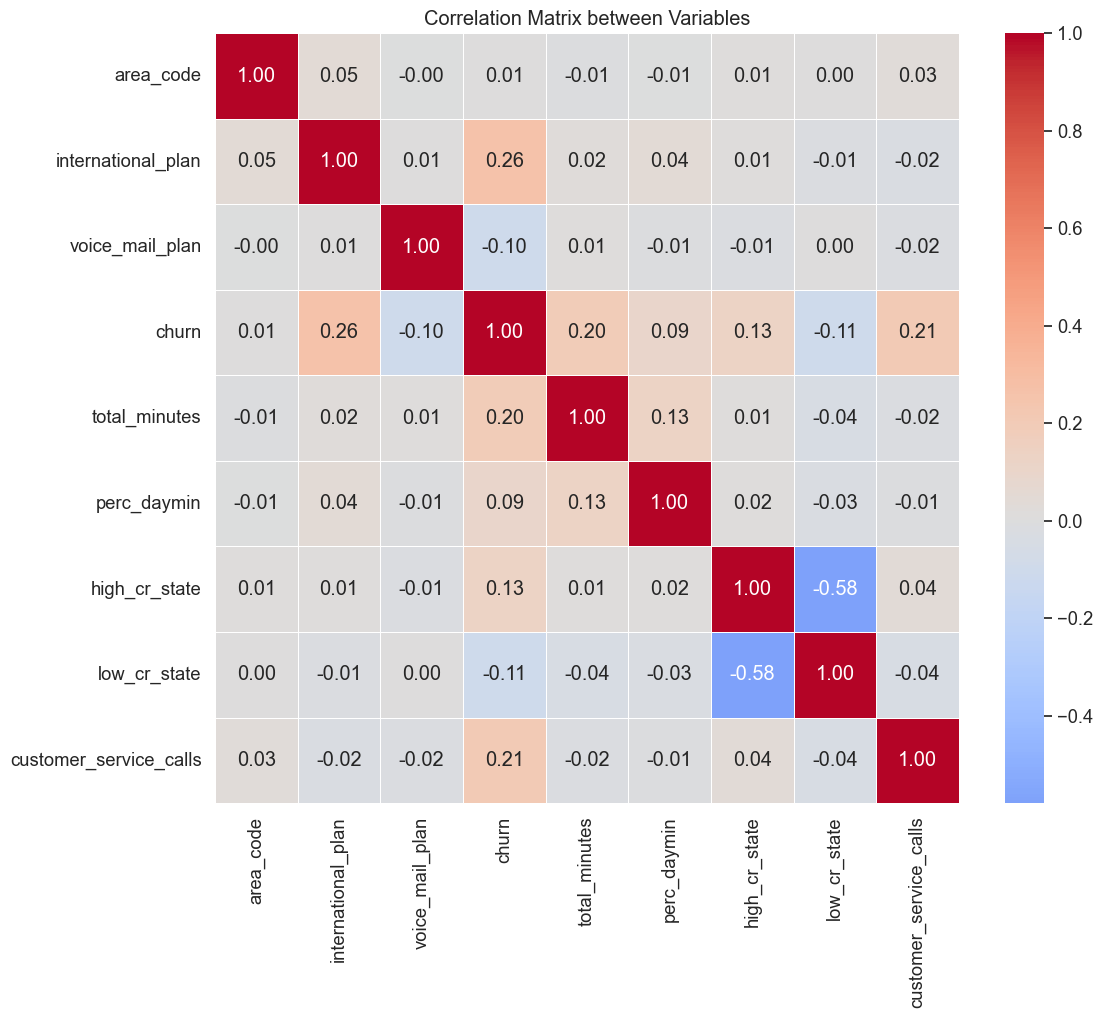

In [4031]:
# Run new correlation matrix
logreg_selects = logreg_selects.select_dtypes(include=['float64','int64'])
# Calculate the correlation matrix
corr_matrix = logreg_selects.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, center=0)
plt.title('Correlation Matrix between Variables')
plt.show();

In [4032]:
df_copy.keys()

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn', 'prefix', 'total_minutes',
       'total_charge'],
      dtype='object')

In [4033]:
df.keys()

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_eve_minutes', 'total_night_minutes', 'total_intl_minutes',
       'customer_service_calls', 'churn', 'prefix', 'total_charge',
       'churn_category', 'high_cr_state', 'low_cr_state', 'med_cr_state',
       'extreme_high_cr_state', 'total_intl_charge', 'intl_minute_cost',
       'total_intl_calls'],
      dtype='object')

In [4034]:
norm_df.keys()

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'churn', 'prefix', 'total_minutes', 'perc_daymin',
       'perc_evemin', 'perc_nightmin', 'avg_intlmin_daily', 'weeks_active',
       'avg_custservice_weekly', 'avg_vmail_weekly', 'avg_daymin_daily',
       'avg_evemin_daily', 'avg_nightmin_daily', 'avg_totalmin_daily',
       'calltime_deviation_from_mean', 'intlmin_deviation_from_mean',
       'custservice_weekly_deviation', 'vmail_weekly_deviation',
       'high_cr_state', 'low_cr_state'],
      dtype='object')

In [4035]:
df['total_minutes'] = df_copy['total_minutes']

In [4036]:
df['perc_daytime_minutes'] = df['total_day_minutes'] / df['total_minutes']

# OOP CLASSIFICATION SYSTEM

Lastly, as icing on the cake...Let's make an OOP (Object Oriented Programming) Classification system for our stakeholders. So they can easily access a phone_numbers details, by different categories of information.

Well make a new dataframe **oop** for this.

In [4037]:
oop = norm_df
oop['phone_number'] = df_copy['phone_number']
oop.keys()

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'churn', 'prefix', 'total_minutes', 'perc_daymin',
       'perc_evemin', 'perc_nightmin', 'avg_intlmin_daily', 'weeks_active',
       'avg_custservice_weekly', 'avg_vmail_weekly', 'avg_daymin_daily',
       'avg_evemin_daily', 'avg_nightmin_daily', 'avg_totalmin_daily',
       'calltime_deviation_from_mean', 'intlmin_deviation_from_mean',
       'custservice_weekly_deviation', 'vmail_weekly_deviation',
       'high_cr_state', 'low_cr_state', 'phone_number'],
      dtype='object')

In [4038]:
# Identify columns to add
columns_to_add = [col for col in df_copy.columns if col not in oop.columns]

# Add columns from df_copy to oop
oop = pd.concat([oop, df_copy[columns_to_add]], axis=1)

In [4039]:
oop['extreme_high_cr_state'] = df['extreme_high_cr_state']
oop['med_cr_state'] = df['med_cr_state']

In [4040]:
oop.keys()

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'churn', 'prefix', 'total_minutes', 'perc_daymin',
       'perc_evemin', 'perc_nightmin', 'avg_intlmin_daily', 'weeks_active',
       'avg_custservice_weekly', 'avg_vmail_weekly', 'avg_daymin_daily',
       'avg_evemin_daily', 'avg_nightmin_daily', 'avg_totalmin_daily',
       'calltime_deviation_from_mean', 'intlmin_deviation_from_mean',
       'custservice_weekly_deviation', 'vmail_weekly_deviation',
       'high_cr_state', 'low_cr_state', 'phone_number',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'customer_service_calls', 'total_charge',
       'extreme_high_cr_state', 'med_cr_state'],
      dtype='object')

In [4041]:
keys

{'area_codes': {415: 'San Francisco, CA',
  510: 'East Bay cities, Northern CA',
  408: 'San Jose, CA'},
 'ppm': {'day_ppm': 0.17,
  'eve_ppm': 0.085,
  'night_ppm': 0.045,
  'intl_ppm': 0.27}}

In [4042]:
# Example PhoneCallDetails class (as defined previously)
class PhoneCallDetails:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        self.oop = oop

    def customer_info(self):
        return (
            f"Days Account Active: {self.account_length}\n"
            f"Weeks Account Active: {self.weeks_active}\n"
            f"Churn: {'YES' if self.churn == 1 else 'NO'}\n"
        )

    def location_info(self):
        
        if self.area_code == 415:
            location = 'San Francisco, CA'
        elif self.area_code == 510:
            location = 'East Bay cities, Northern CA'
        elif self.area_code == 408:
            location = 'San Jose, CA'
        else:
            location = 'Unknown Area'

        filtered_rows = self.oop[self.oop['state'] == self.state]
        state_churn_avg = filtered_rows['churn'].mean()

        if self.extreme_high_cr_state == 1:
            churn_rate = 'EXTREME'
        elif self.med_cr_state == 1:
            churn_rate = 'MEDIUM'
        elif self.low_cr_state == 1:
            churn_rate = 'LOW'
        else:
            churn_rate = 'HIGH'
            
        return (
            f"Area Code ({self.area_code}): {location}\n"
            f"Prefix: {self.prefix}\n"
            f"State: {self.state}\n"
            f"State Average Churn-Rate: {state_churn_avg}\n"
            f"State Churn-Rate Rating: {churn_rate}\n"
        )       

    def day_call_info(self):
        if self.total_day_minutes > 0:
            perc_minutes = (self.total_day_minutes / self.total_minutes) * 100
            avg_num_calls_daily = (self.total_day_calls / self.account_length)
            return (
                f"Total Calls: {self.total_day_calls}\n"
                f"Average Number of Calls Daily: {avg_num_calls_daily}\n"
                f"Total Minutes: {self.total_day_minutes}\n"
                f"Price-per-minute: 0.17\n"
                f"Total Charge: {self.total_day_charge}\n"
                f"Percentage Minutes Daytime: {perc_minutes}%\n"
            )
        else:
            return "No daytime calls for this phone number."
            
    def eve_call_info(self):
        if self.total_eve_minutes > 0:
            perc_minutes = (self.total_eve_minutes / self.total_minutes) * 100
            avg_num_calls_daily = (self.total_eve_calls / self.account_length)
            return (
                f"Total Calls: {self.total_eve_calls}\n"
                f"Average Number of Calls Daily: {avg_num_calls_daily}\n"
                f"Total Minutes: {self.total_eve_minutes}\n"
                f"Price-per-minute: 0.085\n"
                f"Total Charge: {self.total_eve_charge}\n"
                f"Percentage Minutes Evening: {perc_minutes}%\n"
            )
        else:
            return "No evening calls for this phone number."
            
    def night_call_info(self):
        if self.total_night_minutes > 0:
            perc_minutes = (self.total_night_minutes / self.total_minutes) * 100
            avg_num_calls_daily = (self.total_night_calls / self.account_length)
            return (
                f"Total Calls: {self.total_night_calls}\n"
                f"Average Number of Calls Daily: {avg_num_calls_daily}\n"
                f"Total Minutes: {self.total_night_minutes}\n"
                f"Price-per-minute: 0.045\n"
                f"Total Charge: {self.total_night_charge}\n"
                f"Percentage Minutes Nighttime: {perc_minutes}%\n"
            )
        else:
            return "No nighttime calls for this phone number."

    def intl_info(self):
        if self.total_intl_minutes > 0:
            avg_num_calls_daily = (self.total_intl_calls / self.account_length)
            return (
                f"This customer does {'have' if self.international_plan == 1 else 'not have'} an international plan.\n"
                f"Total Calls: {self.total_intl_calls}\n"
                f"Average Number of Calls Daily: {avg_num_calls_daily}\n"
                f"Total Minutes: {self.total_intl_minutes}\n"
                f"Deviation from Avg. Minutes of All Consumers: {self.intlmin_deviation_from_mean}\n"
                f"Price-per-minute: 0.27\n"
                f"Total Charge: {self.total_intl_charge}\n"
            )
        else:
            return (
                f"No international calls for this phone number.\n"
                f"This customer does {'have' if self.international_plan == 1 else 'not have'} an international plan.\n"
            )

    def vmail_info(self):
        if self.number_vmail_messages > 0:
            return (
                f"This customer does {'have' if self.voice_mail_plan == 1 else 'not have'} a voicemail plan.\n"
                f"Number Voicemail Messages: {self.number_vmail_messages}\n"
                f"Average Number Voicemails Weekly: {perc_vmail_weekly}\n"
                f"Deviation from Weekly Voicemails of All Consumers: {self.vmail_weekly_deviation}\n"
            )
        else:
            return (
                f"This customer left no voicemails.\n"
                f"This customer does{'have' if self.voice_mail_plan == 1 else 'not have'} a voicemail plan.\n"
            )

    def cust_service_info(self):
        if self.customer_service_calls > 0:
            return (
                f"Number Customer Service Calls: {self.customer_service_calls}\n"
                f"Average Number Calls Weekly: {self.perc_custservice_weekly}\n"
                f"Deviation from Weekly Cust-Service Calls of All Consumers: {self.custservice_weekly_deviation}\n"
            )

# Formatting phone_number values correctly
oop['phone_number'] = oop['phone_number'].str.replace('-', '')

# Function to create PhoneCallDetails objects from DataFrame rows
def phone_number_details(phone_number):
    try:
        row = oop.loc[oop['phone_number'] == phone_number].iloc[0]
        print(f"Metrics Available to Print: \n"
        f"number.customer_info \n"
        f"number.location_info \n"
        f"number.day_call_info \n"
        f"number.eve_call_info \n"
        f"number.night_call_info \n"
        f"number.intl_call_info \n"
        f"number.vmail_info \n"
        )
        return PhoneCallDetails(**row)
    except IndexError:
        print(f"Please input your number as a string: '3824657' rather than 3824657")
        return None

In [4043]:
oop['phone_number'].value_counts()

phone_number
3824657    1
3487071    1
3896082    1
4153689    1
3792503    1
          ..
3521127    1
3681288    1
4035279    1
3979333    1
4004344    1
Name: count, Length: 3333, dtype: int64

In [4044]:
number = phone_number_details('3824657')

print(number.customer_info())

Metrics Available to Print: 
number.customer_info 
number.location_info 
number.day_call_info 
number.eve_call_info 
number.night_call_info 
number.intl_call_info 
number.vmail_info 

Days Account Active: 128
Weeks Account Active: 18.285714285714285
Churn: NO



In [4045]:
# Create churn_rate_category column based on conditions (if not already done)
df['churn_rate_category'] = df.apply(lambda row: 
                                     'Low' if row['low_cr_state'] == 1 else
                                     'Medium' if row['med_cr_state'] == 1 else
                                     'Extreme-High' if row['extreme_high_cr_state'] == 1 else
                                     'High', axis=1)

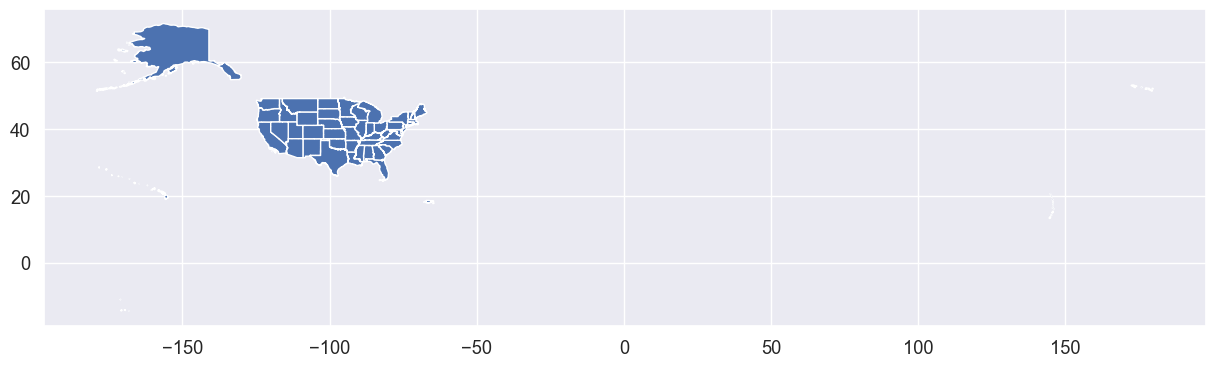

In [4046]:
# Load US states shapefile
fp = "tl_2023_us_state.shp"  # Replace with the actual path to your downloaded shapefile
map_df = gpd.read_file(fp)

# Plotting example
fig, ax = plt.subplots(1, figsize=(15, 10))
map_df.plot(ax=ax)
plt.show()

In [4081]:
# Merge data with shapefile using two-letter state abbreviations
# Dropping nans
map_df.dropna(subset=['STUSPS'], inplace=True)
merged = map_df.set_index('STUSPS').join(df.set_index('state'))

In [4082]:
print(merged['churn_rate_category'].unique())

['Low' 'Medium' 'High' 'Extreme-High' nan]


For some reason, there seem to be some NaNs. This might be due to a problem converting the state names when transferring data to our new merged dataframe, with the downloaded map. 

Lets count how many there are. If there are very few, we'll drop them.

In [4083]:
merged['churn_rate_category'].value_counts()

churn_rate_category
High            867
Extreme-High    829
Medium          821
Low             816
Name: count, dtype: int64

In [4066]:
missing_values_count = merged['churn_rate_category'].isna().sum()
missing_values_count

np.int64(5)

In [4084]:
# Dropping nans
merged.dropna(subset=['churn_rate_category'], inplace=True)

In [4085]:
merged = merged.reset_index()

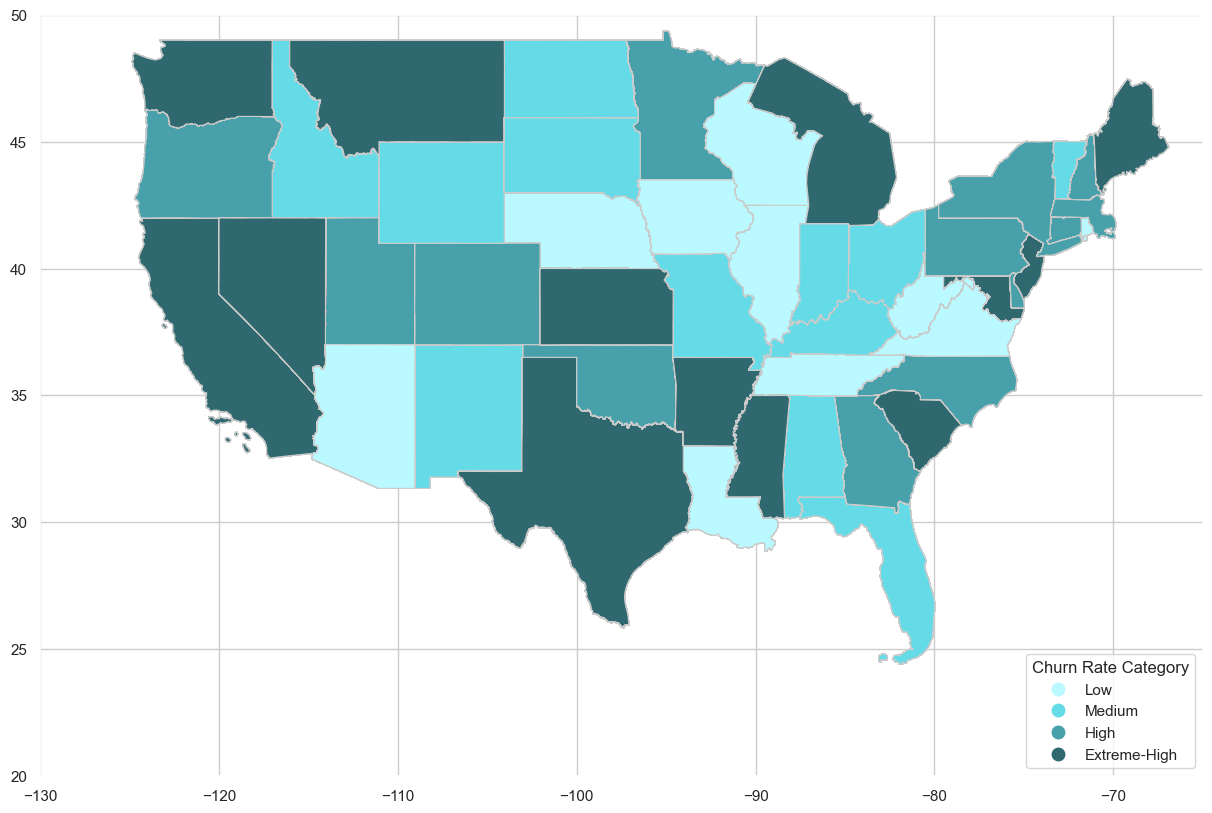

In [4097]:
# Define colors for each category
colors = {
    'Low': '#baf9ff',         
    'Medium': '#64dbe7',      
    'High': '#48a1aa',        
    'Extreme-High': '#2f696f' 
}

# Define categories in the correct order
categories = ['Low', 'Medium', 'High', 'Extreme-High']

merged['churn_rate_category'] = pd.Categorical(merged['churn_rate_category'], categories=categories)

# Create a colormap based on the defined colors
cmap = ListedColormap([colors[cat] for cat in categories])

# Create figure and axes
fig, ax = plt.subplots(1, figsize=(15, 25))

# Set custom limits for x-axis and y-axis
ax.set_xlim([-130, -65])  # Adjusted x-axis range to crop out Hawaii
ax.set_ylim([20, 50]) # Only plotting continental US

# Plot the map using the colormap
merged.plot(column='churn_rate_category', categorical=True, legend=True,
            linewidth=0.8, ax=ax, edgecolor='0.8', cmap=cmap,  # Specify the colormap here
            legend_kwds={'loc': 'lower right', 'title': 'Churn Rate Category',
                         'labels': categories})

# Add legend color patches
for category, color in colors.items():
    ax.add_patch(plt.Rectangle((0, 0), 1, 1, color=color, label=category))

# Save plot with transparent background
plt.savefig('churn_rate_map.png', bbox_inches='tight', pad_inches=0, transparent=True)

# Show plot
plt.show()

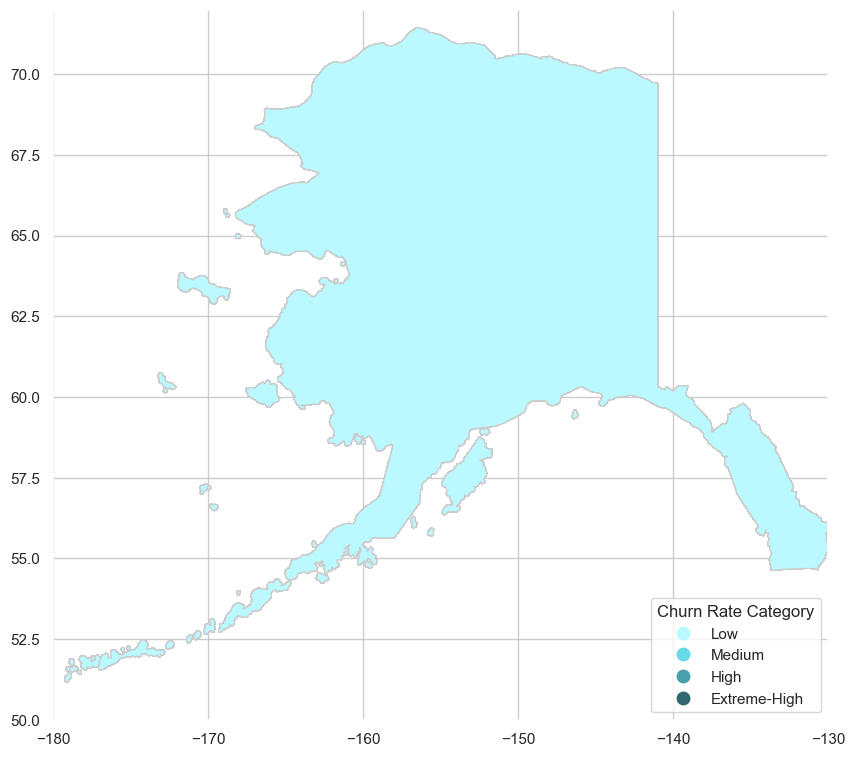

In [4098]:
# Plot for Alaska
fig_alaska, ax_alaska = plt.subplots(figsize=(10, 10))  # Adjust size as needed
ax_alaska.set_xlim([-180, -130])  # Adjusted x-axis range for Alaska
ax_alaska.set_ylim([50, 72])      # Adjusted y-axis range for Alaska
merged[merged['STUSPS'] == 'AK'].plot(column='churn_rate_category', categorical=True, legend=True,
                                      linewidth=0.8, ax=ax_alaska, edgecolor='0.8', cmap=cmap,
                                      legend_kwds={'loc': 'lower right', 'title': 'Churn Rate Category',
                                                   'labels': categories})
for category, color in colors.items():
    ax_alaska.add_patch(plt.Rectangle((0, 0), 1, 1, color=color, label=category))

# Save plot for Alaska with transparent background
fig_alaska.savefig('churn_rate_map_alaska.png', bbox_inches='tight', pad_inches=0, transparent=True)

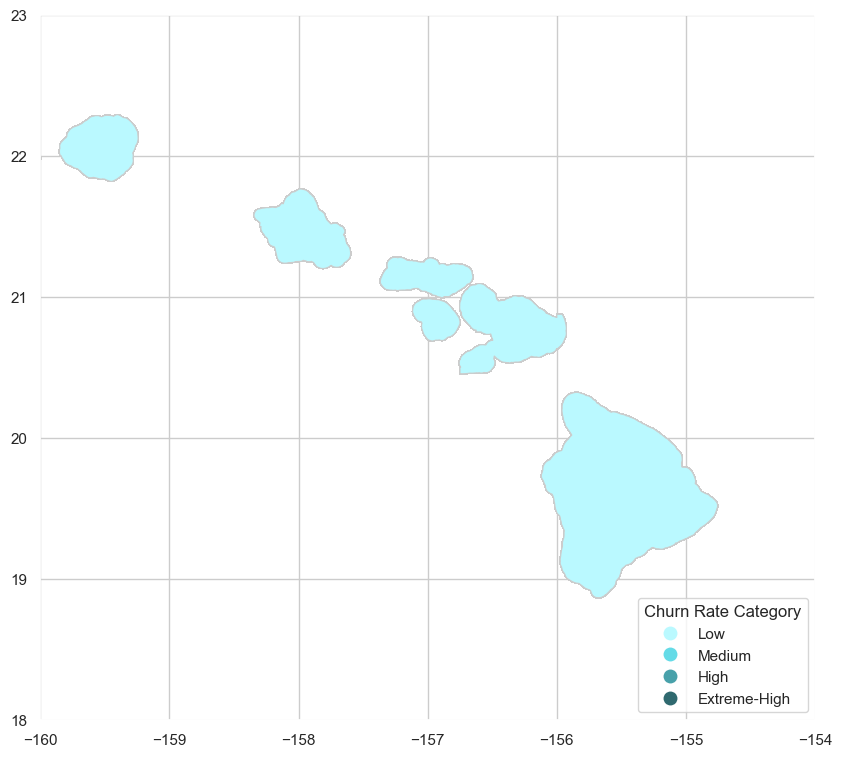

In [4101]:
# Plot for Hawaii
fig_hawaii, ax_hawaii = plt.subplots(figsize=(10, 10))  # Adjust size as needed
ax_hawaii.set_xlim([-160, -154])  # Adjusted x-axis range for Hawaii
ax_hawaii.set_ylim([18, 23])      # Adjusted y-axis range for Hawaii
merged[merged['STUSPS'] == 'HI'].plot(column='churn_rate_category', categorical=True, legend=True,
                                      linewidth=0.8, ax=ax_hawaii, edgecolor='0.8', cmap=cmap,
                                      legend_kwds={'loc': 'lower right', 'title': 'Churn Rate Category',
                                                   'labels': categories})
for category, color in colors.items():
    ax_hawaii.add_patch(plt.Rectangle((0, 0), 1, 1, color=color, label=category))

# Save plot for Hawaii with transparent background
fig_hawaii.savefig('churn_rate_map_hawaii.png', bbox_inches='tight', pad_inches=0, transparent=True)

In [4048]:
df.head()

state  account_length  area_code  international_plan  voice_mail_plan  \
0    KS             128        415                   0                1   
1    OH             107        415                   0                1   
2    NJ             137        415                   0                0   
3    OH              84        408                   1                0   
4    OK              75        415                   1                0   

   number_vmail_messages  total_day_minutes  total_eve_minutes  \
0                     25              265.1              197.4   
1                     26              161.6              195.5   
2                      0              243.4              121.2   
3                      0              299.4               61.9   
4                      0              166.7              148.3   

   total_night_minutes  total_intl_minutes  ...  high_cr_state  low_cr_state  \
0                244.7                10.0  ...              1             0   
1                254.4                13.7  ...              0             0   
2                162.6                12.2  ...              1             0   
3                196.9                 6.6  ...              0             0   
4                186.9                10.1  ...              1             0   

  med_cr_state  extreme_high_cr_state total_intl_charge  intl_minute_cost  \
0            0                      1              2.70          0.270000   
1            1                      0              3.70          0.270073   
2            0                      1              3.29          0.269672   
3            1                      0              1.78          0.269697   
4            0                      0              2.73          0.270297   

   total_intl_calls  total_minutes  perc_daytime_minutes  churn_rate_category  
0                 3          707.2              0.374859         Extreme-High  
1                 3          611.5              0.264268               Medium  
2                 5          527.2              0.461684         Extreme-High  
3                 7          558.2              0.536367               Medium  
4                 3          501.9              0.332138                 High  

[5 rows x 25 columns]

In [4049]:
merged.head()

REGION DIVISION STATEFP   STATENS GEOID      GEOIDFQ           NAME  \
STUSPS                                                                       
WV          3        5      54  01779805    54  0400000US54  West Virginia   
WV          3        5      54  01779805    54  0400000US54  West Virginia   
WV          3        5      54  01779805    54  0400000US54  West Virginia   
WV          3        5      54  01779805    54  0400000US54  West Virginia   
WV          3        5      54  01779805    54  0400000US54  West Virginia   

       LSAD  MTFCC FUNCSTAT  ...  high_cr_state  low_cr_state med_cr_state  \
STUSPS                       ...                                             
WV       00  G4000        A  ...            0.0           1.0          0.0   
WV       00  G4000        A  ...            0.0           1.0          0.0   
WV       00  G4000        A  ...            0.0           1.0          0.0   
WV       00  G4000        A  ...            0.0           1.0          0.0   
WV       00  G4000        A  ...            0.0           1.0          0.0   

       extreme_high_cr_state total_intl_charge  intl_minute_cost  \
STUSPS                                                             
WV                       0.0              3.02          0.269643   
WV                       0.0              3.56          0.269697   
WV                       0.0              3.24          0.270000   
WV                       0.0              2.57          0.270526   
WV                       0.0              1.92          0.270423   

        total_intl_calls  total_minutes  perc_daytime_minutes  \
STUSPS                                                          
WV                   5.0          807.0              0.320446   
WV                   2.0          728.6              0.276009   
WV                   2.0          605.2              0.354098   
WV                   5.0          693.8              0.284088   
WV                   2.0          596.2              0.377390   

        churn_rate_category  
STUSPS                       
WV                      Low  
WV                      Low  
WV                      Low  
WV                      Low  
WV                      Low  

[5 rows x 39 columns]

In [4077]:
ca_data = merged[merged['STUSPS'] == 'CA']

In [4078]:
ca_data

STUSPS REGION DIVISION STATEFP   STATENS GEOID      GEOIDFQ        NAME  \
913     CA      4        9      06  01779778    06  0400000US06  California   
914     CA      4        9      06  01779778    06  0400000US06  California   
915     CA      4        9      06  01779778    06  0400000US06  California   
916     CA      4        9      06  01779778    06  0400000US06  California   
917     CA      4        9      06  01779778    06  0400000US06  California   
918     CA      4        9      06  01779778    06  0400000US06  California   
919     CA      4        9      06  01779778    06  0400000US06  California   
920     CA      4        9      06  01779778    06  0400000US06  California   
921     CA      4        9      06  01779778    06  0400000US06  California   
922     CA      4        9      06  01779778    06  0400000US06  California   
923     CA      4        9      06  01779778    06  0400000US06  California   
924     CA      4        9      06  01779778    06  0400000US06  California   
925     CA      4        9      06  01779778    06  0400000US06  California   
926     CA      4        9      06  01779778    06  0400000US06  California   
927     CA      4        9      06  01779778    06  0400000US06  California   
928     CA      4        9      06  01779778    06  0400000US06  California   
929     CA      4        9      06  01779778    06  0400000US06  California   
930     CA      4        9      06  01779778    06  0400000US06  California   
931     CA      4        9      06  01779778    06  0400000US06  California   
932     CA      4        9      06  01779778    06  0400000US06  California   
933     CA      4        9      06  01779778    06  0400000US06  California   
934     CA      4        9      06  01779778    06  0400000US06  California   
935     CA      4        9      06  01779778    06  0400000US06  California   
936     CA      4        9      06  01779778    06  0400000US06  California   
937     CA      4        9      06  01779778    06  0400000US06  California   
938     CA      4        9      06  01779778    06  0400000US06  California   
939     CA      4        9      06  01779778    06  0400000US06  California   
940     CA      4        9      06  01779778    06  0400000US06  California   
941     CA      4        9      06  01779778    06  0400000US06  California   
942     CA      4        9      06  01779778    06  0400000US06  California   
943     CA      4        9      06  01779778    06  0400000US06  California   
944     CA      4        9      06  01779778    06  0400000US06  California   
945     CA      4        9      06  01779778    06  0400000US06  California   
946     CA      4        9      06  01779778    06  0400000US06  California   

    LSAD  MTFCC  ... high_cr_state  low_cr_state  med_cr_state  \
913   00  G4000  ...           1.0           0.0           0.0   
914   00  G4000  ...           1.0           0.0           0.0   
915   00  G4000  ...           1.0           0.0           0.0   
916   00  G4000  ...           1.0           0.0           0.0   
917   00  G4000  ...           1.0           0.0           0.0   
918   00  G4000  ...           1.0           0.0           0.0   
919   00  G4000  ...           1.0           0.0           0.0   
920   00  G4000  ...           1.0           0.0           0.0   
921   00  G4000  ...           1.0           0.0           0.0   
922   00  G4000  ...           1.0           0.0           0.0   
923   00  G4000  ...           1.0           0.0           0.0   
924   00  G4000  ...           1.0           0.0           0.0   
925   00  G4000  ...           1.0           0.0           0.0   
926   00  G4000  ...           1.0           0.0           0.0   
927   00  G4000  ...           1.0           0.0           0.0   
928   00  G4000  ...           1.0           0.0           0.0   
929   00  G4000  ...           1.0           0.0           0.0   
930   00  G4000  ...           1.0           0.0  

In [4102]:
df.keys()

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_eve_minutes', 'total_night_minutes', 'total_intl_minutes',
       'customer_service_calls', 'churn', 'prefix', 'total_charge',
       'churn_category', 'high_cr_state', 'low_cr_state', 'med_cr_state',
       'extreme_high_cr_state', 'total_intl_charge', 'intl_minute_cost',
       'total_intl_calls', 'total_minutes', 'perc_daytime_minutes',
       'churn_rate_category'],
      dtype='object')

In [4104]:
churned_customers = df.loc[df['churn'] == 1, 'customer_service_calls']
description = churned_customers.describe()
description

count    483.000000
mean       2.229814
std        1.853275
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max        9.000000
Name: customer_service_calls, dtype: float64